Starting Comprehensive Anomaly Detection EDA...
This will generate 9 detailed visualization files
Expected runtime: 5-15 minutes depending on dataset size
COMPREHENSIVE ANOMALY DETECTION EDA
Loading datasets for comprehensive EDA...
Data loaded successfully:
  Train: (30504, 145)
  Valid: (5370, 145)
  Test: (13426, 144)
  Validation anomaly rate: 12.607%
Creating dataset overview...


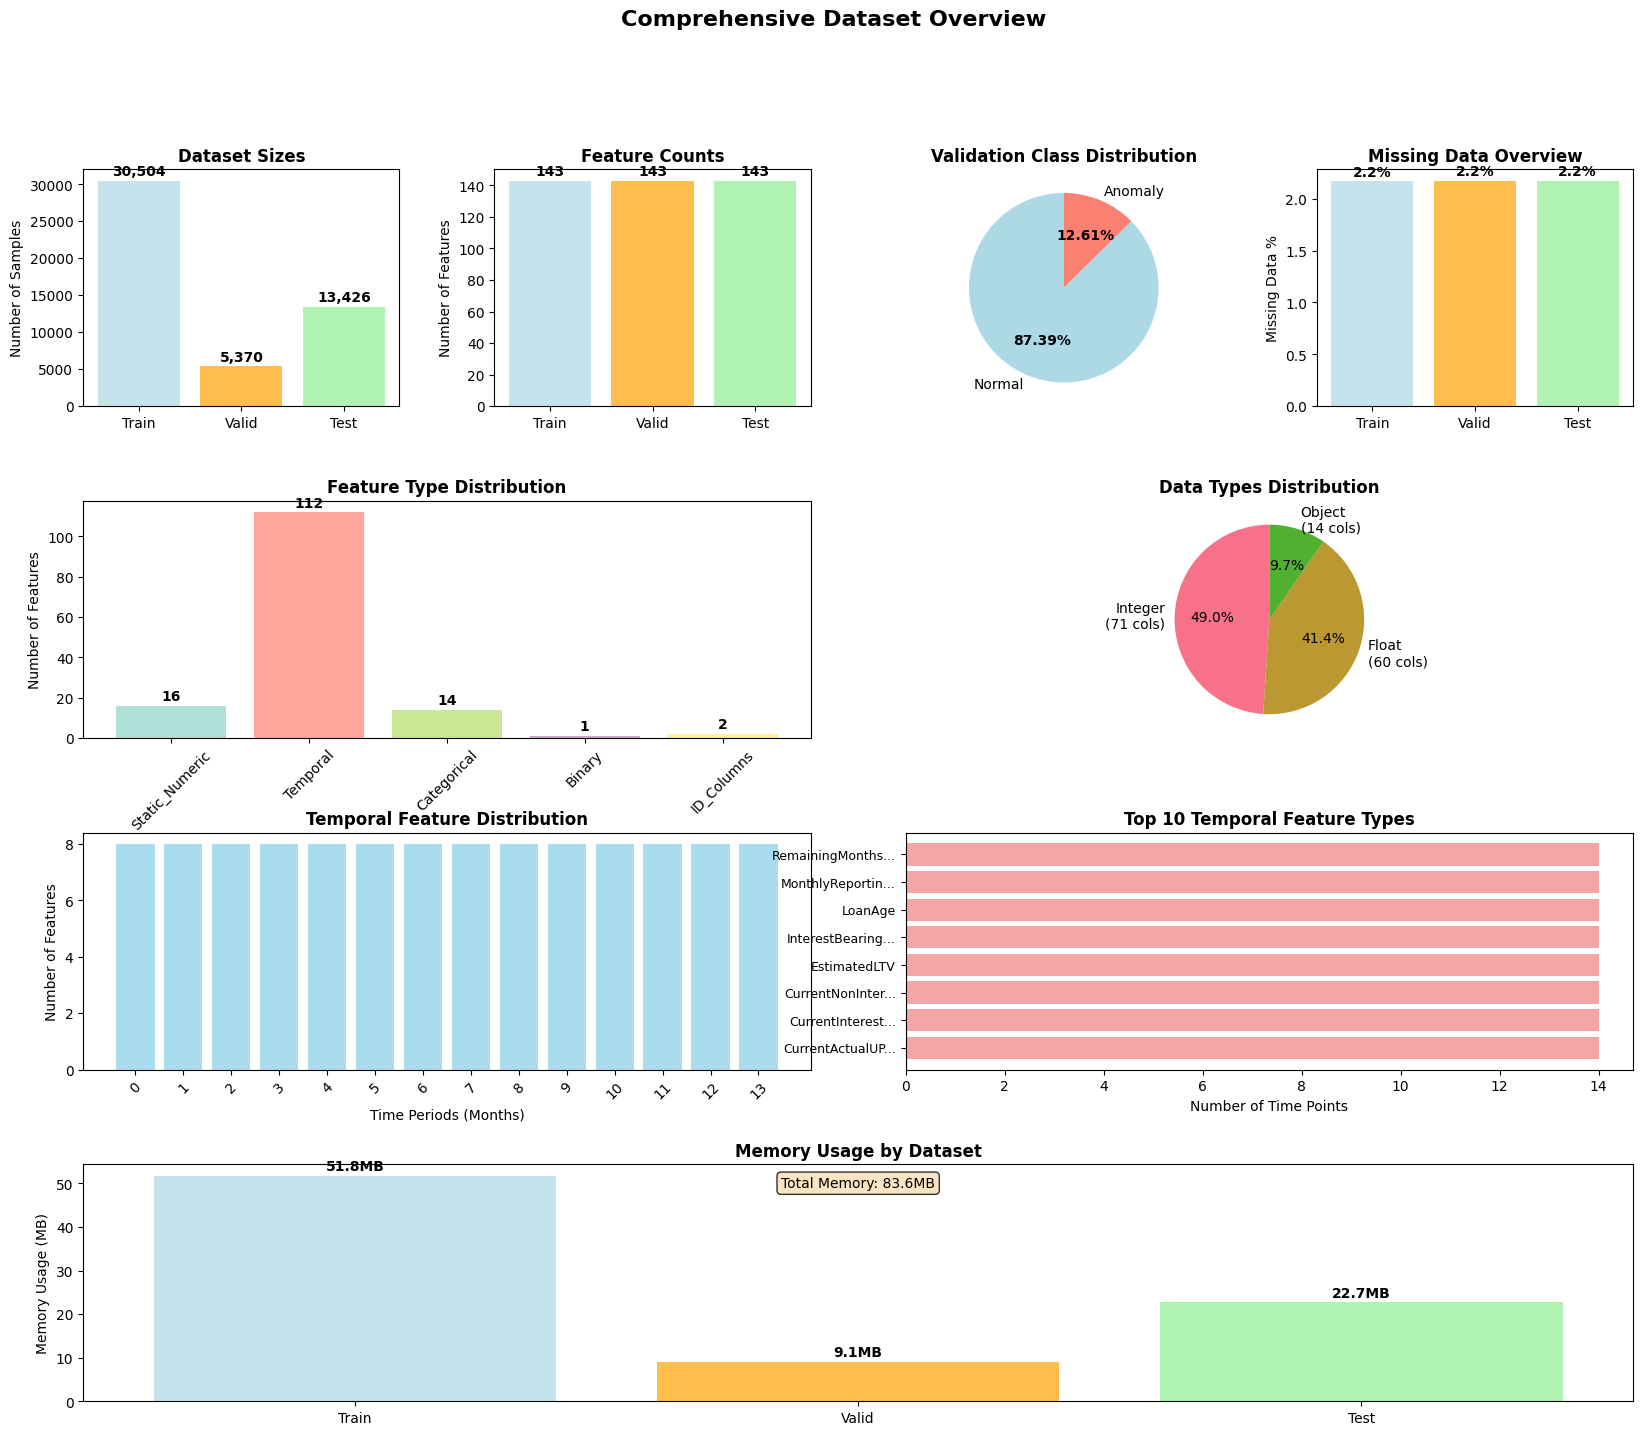

Analyzing missing data patterns...


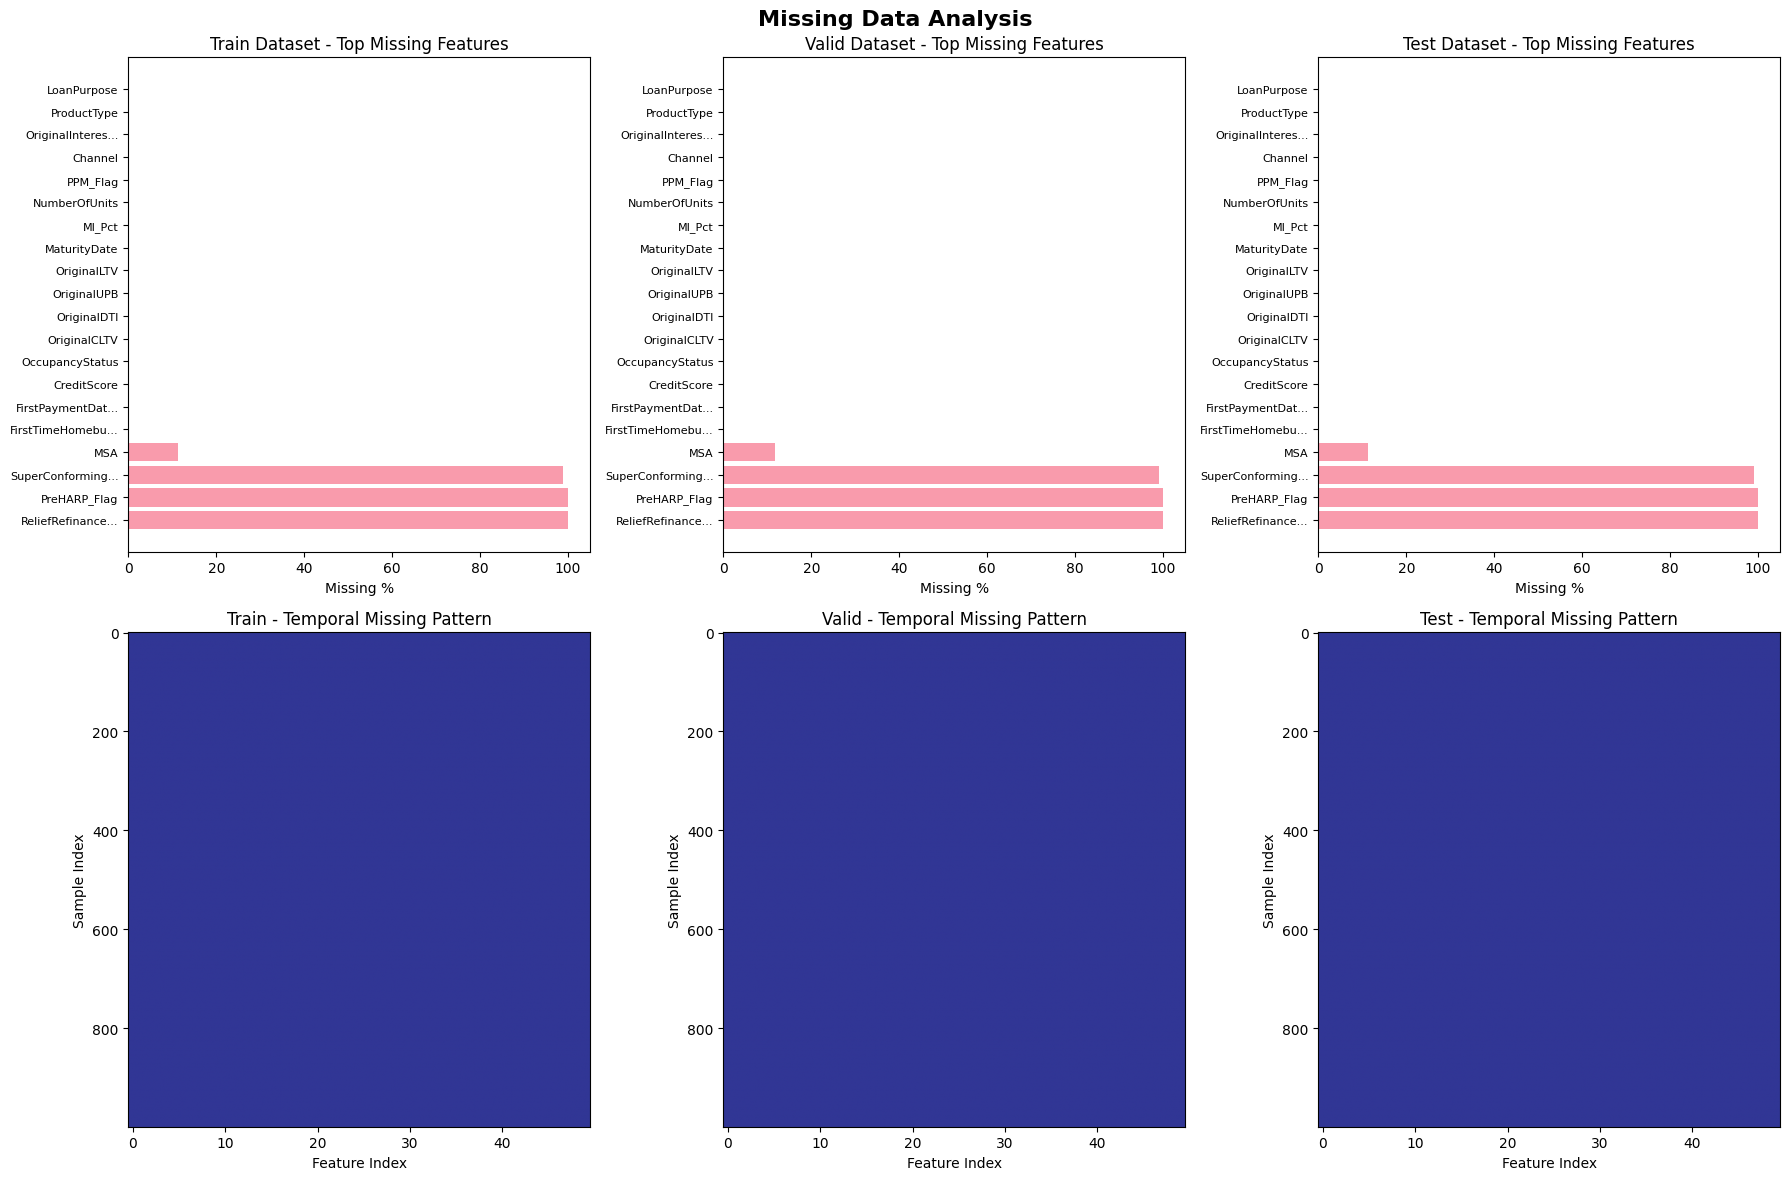

Analyzing anomaly distributions...


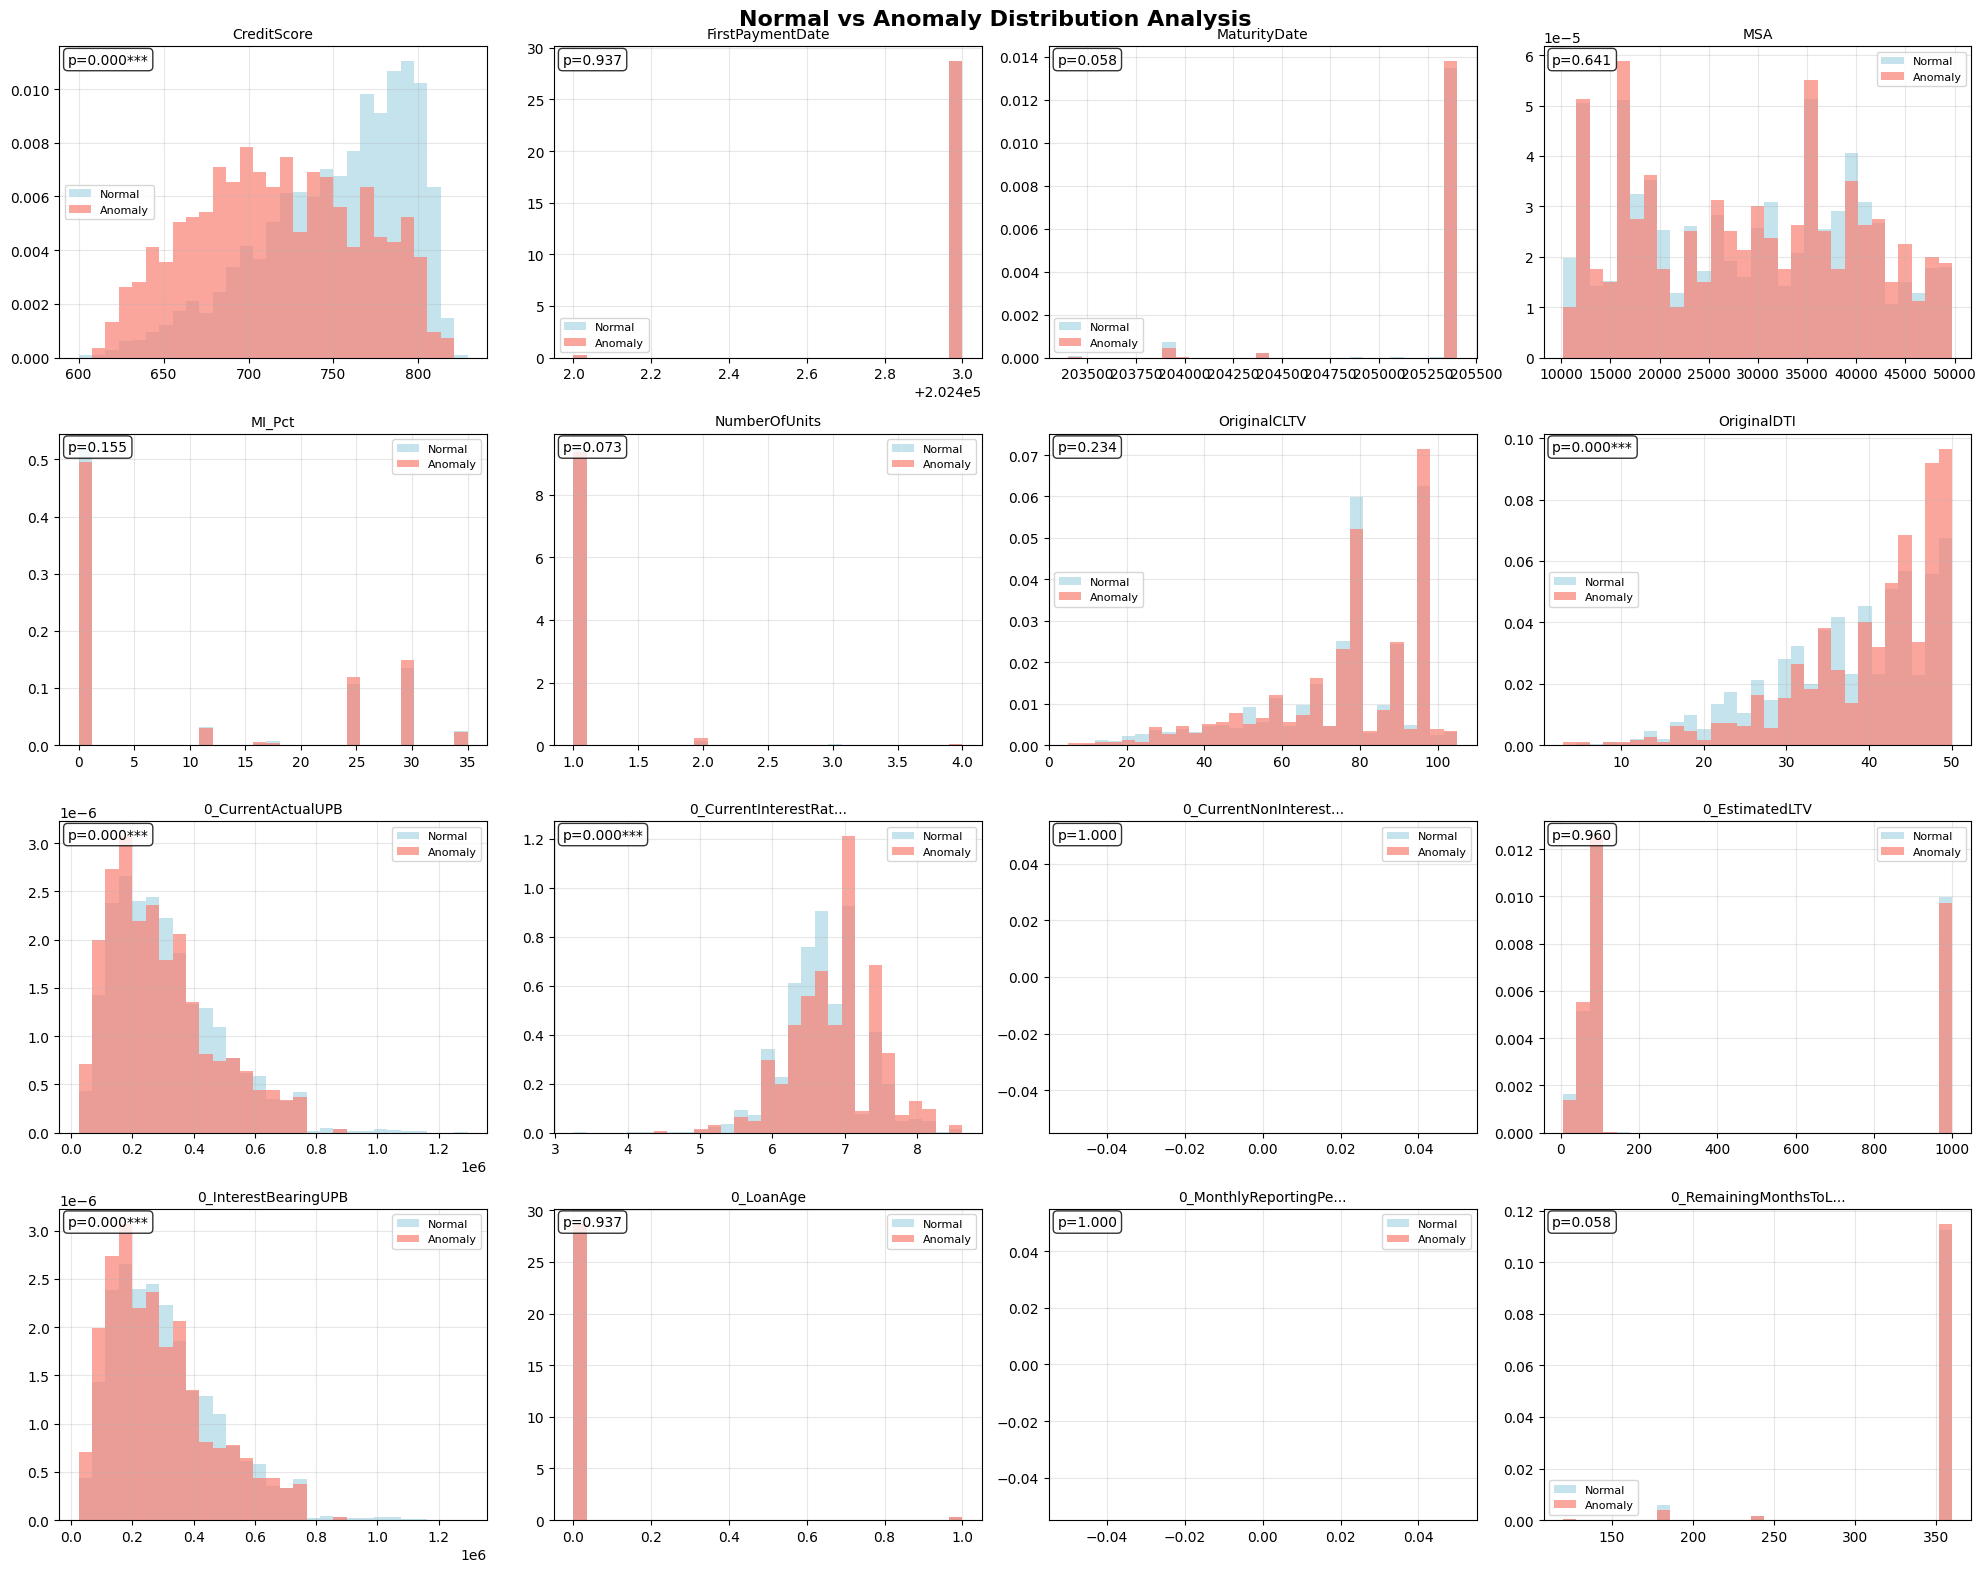

Analyzing temporal patterns...


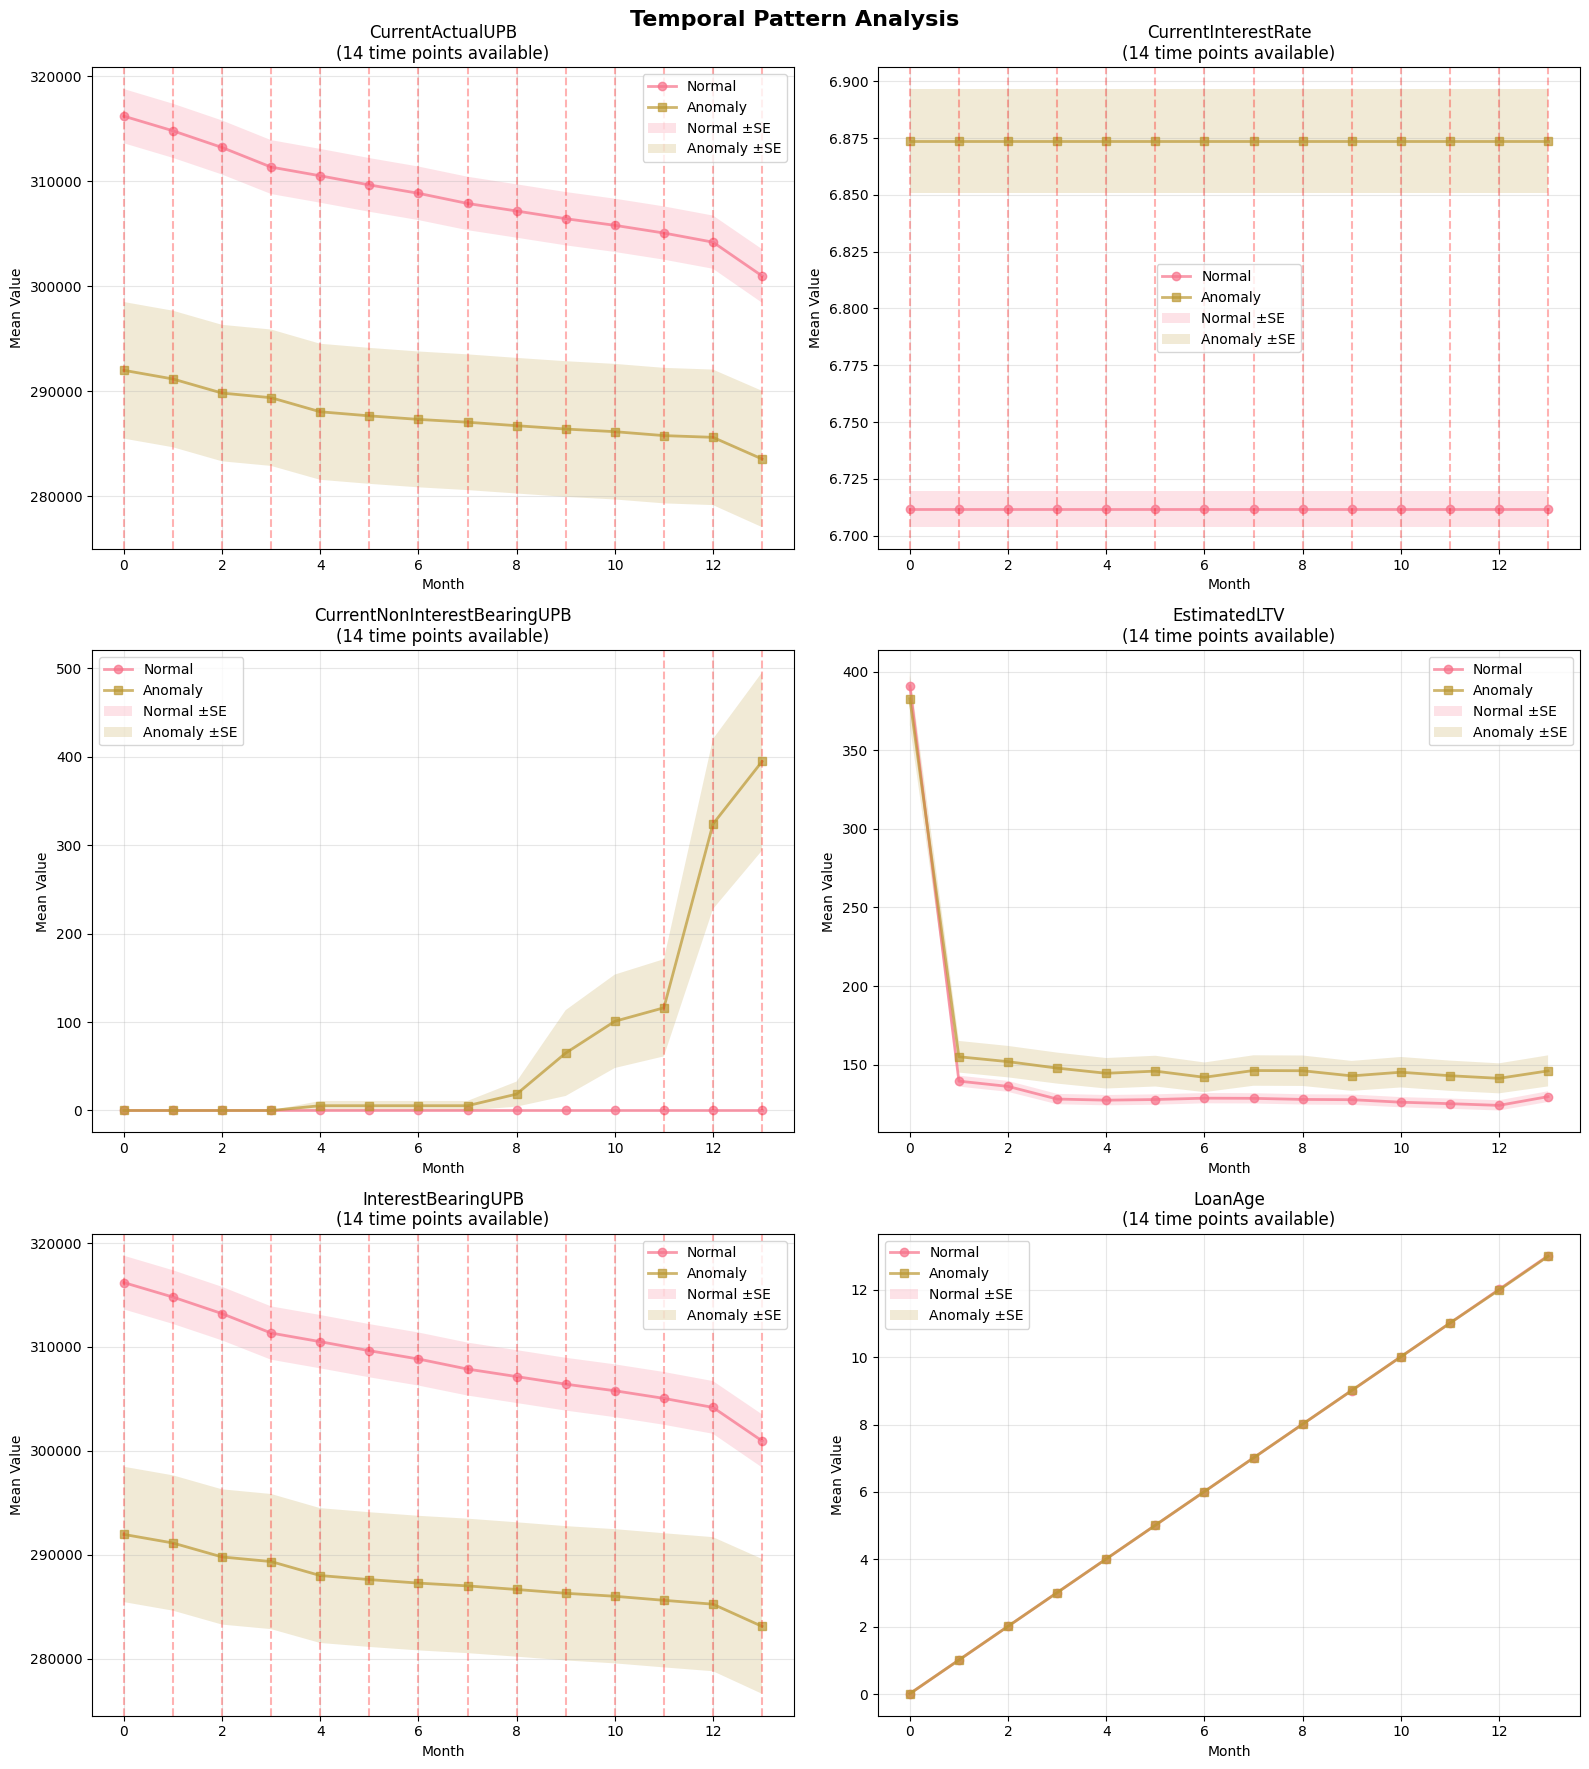

Analyzing feature correlations...


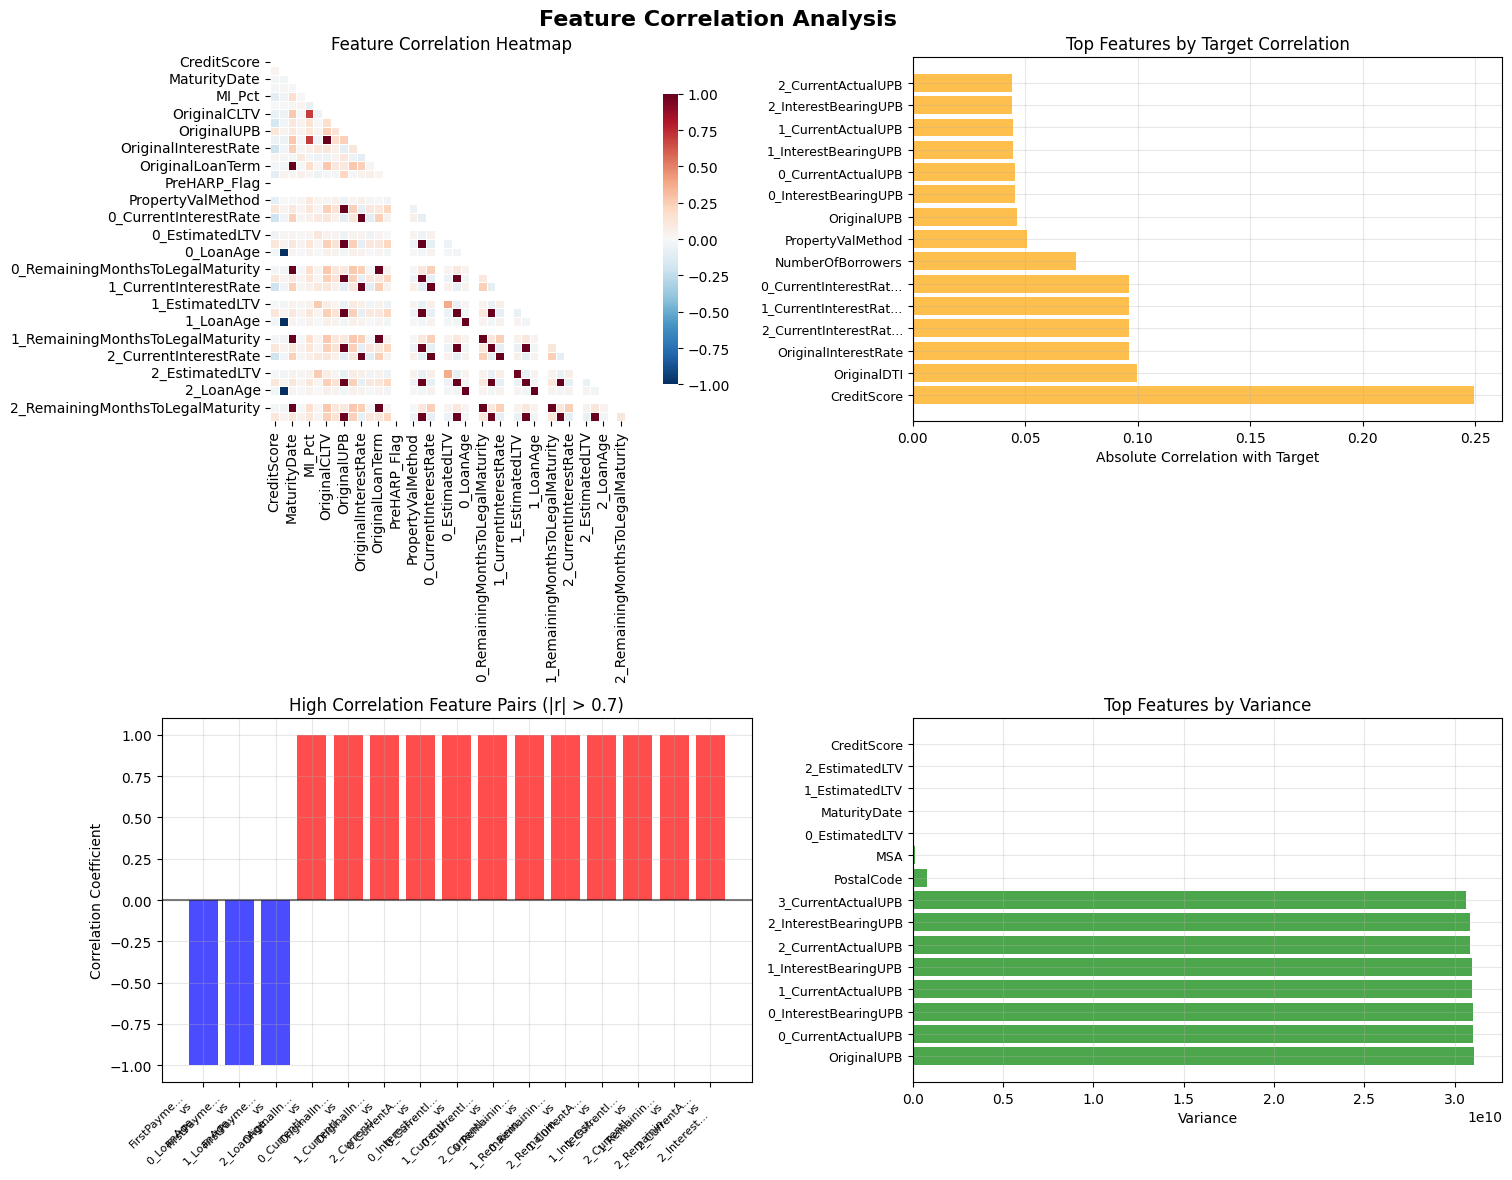

Analyzing outliers and extreme values...


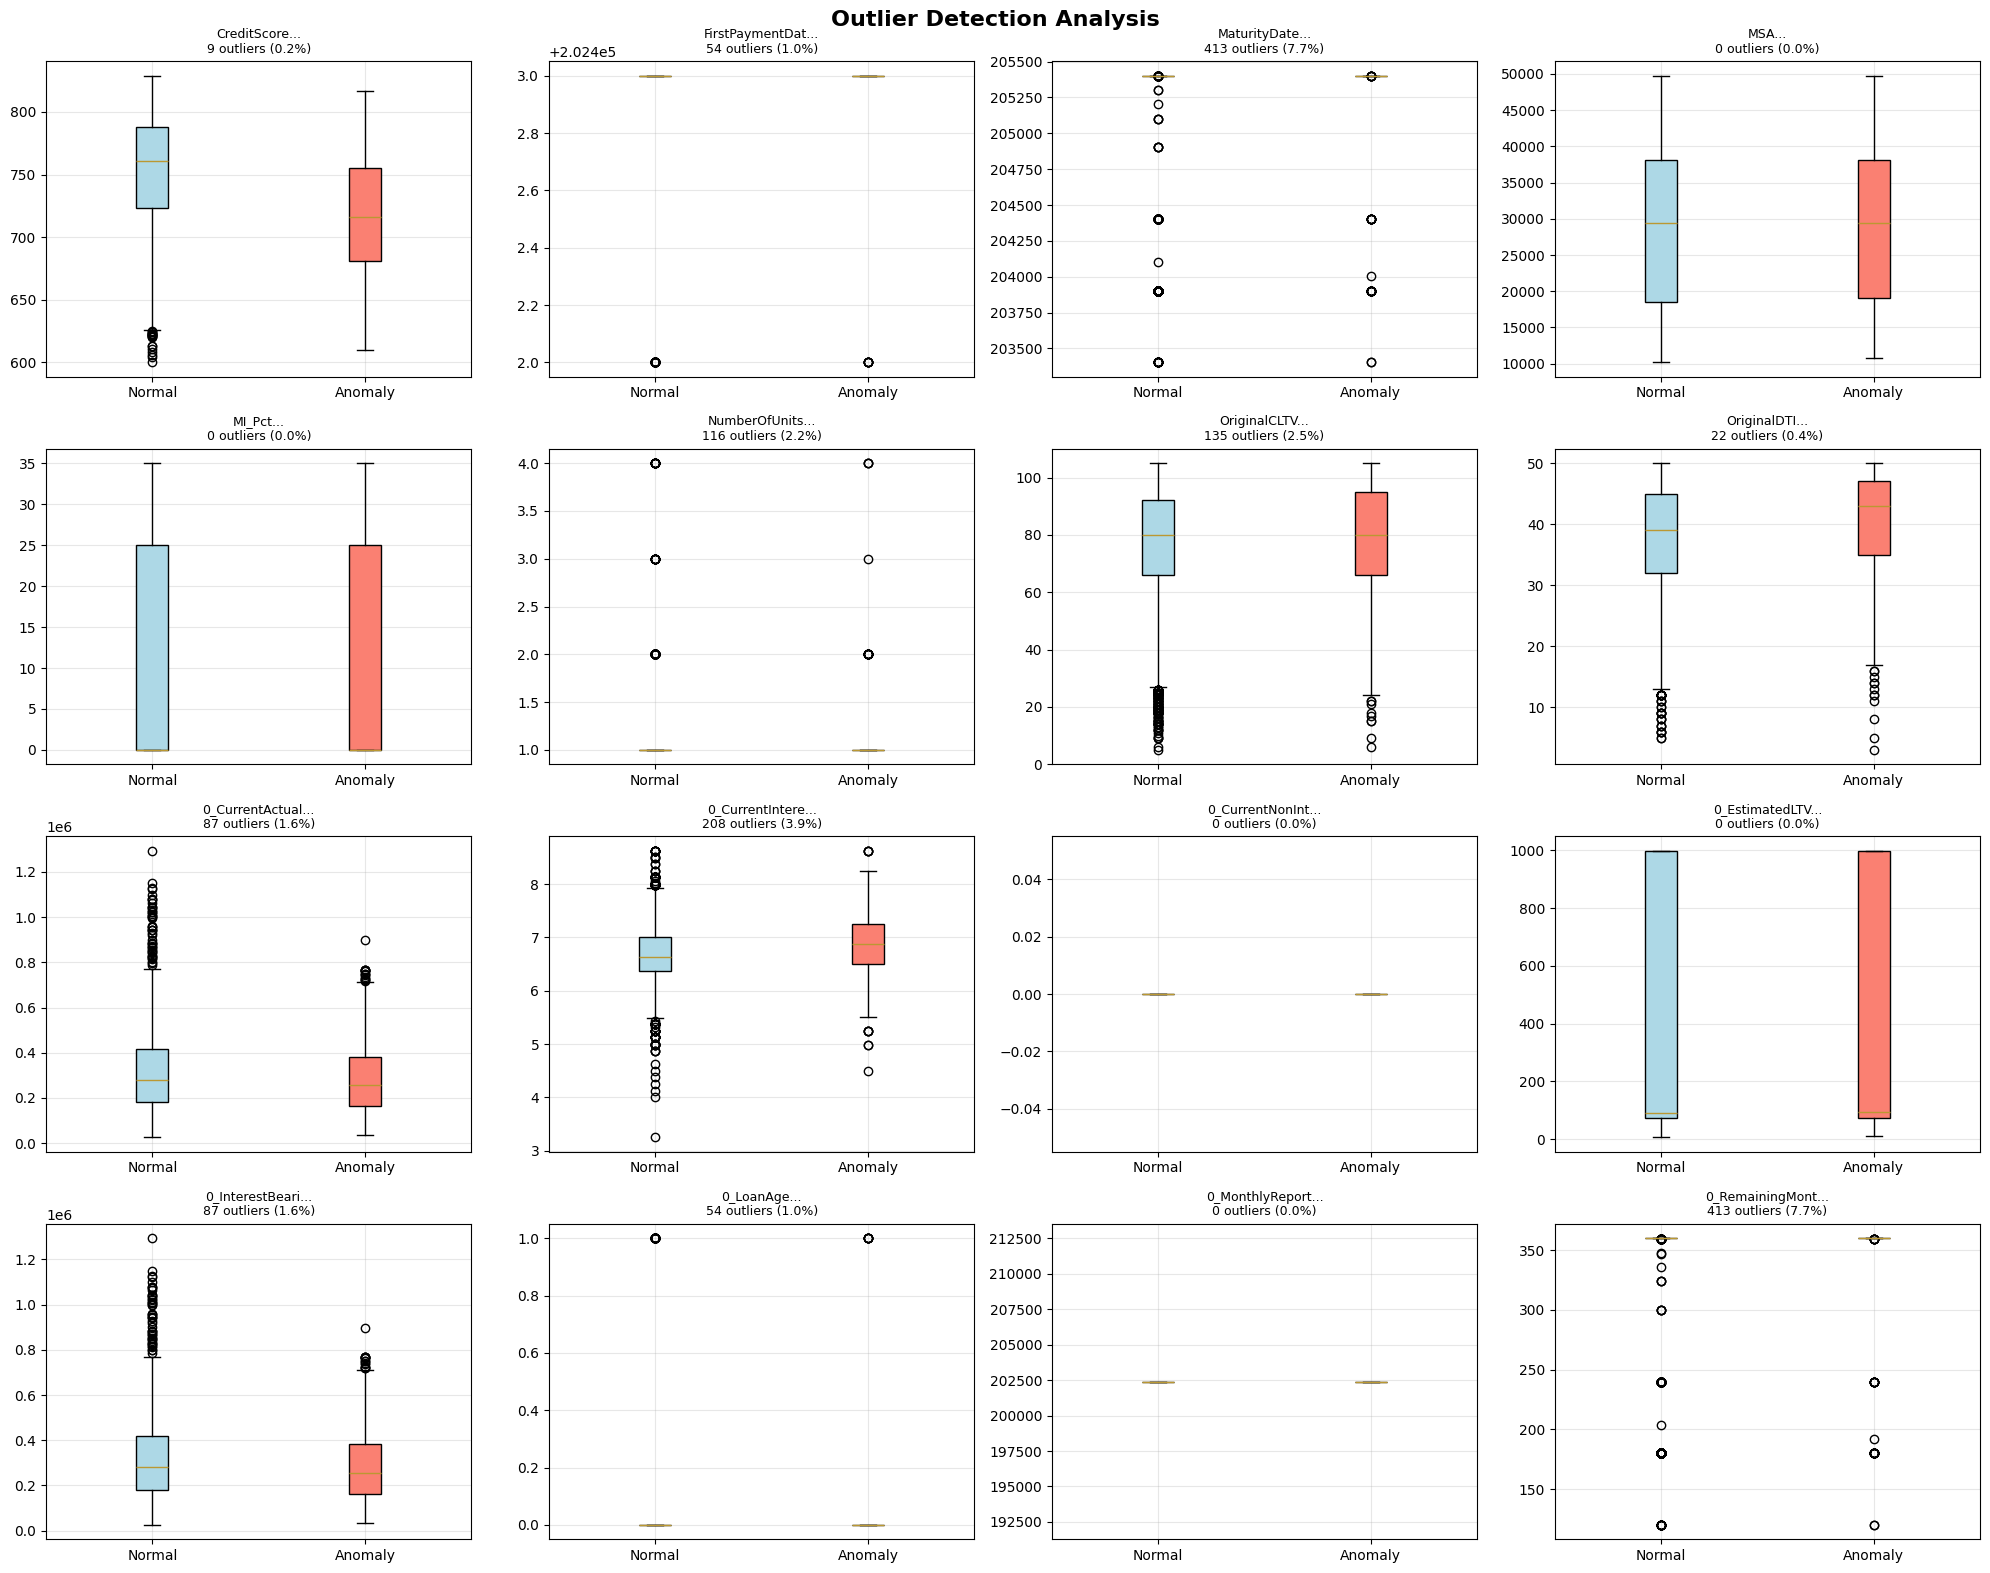

Performing dimensionality reduction analysis...


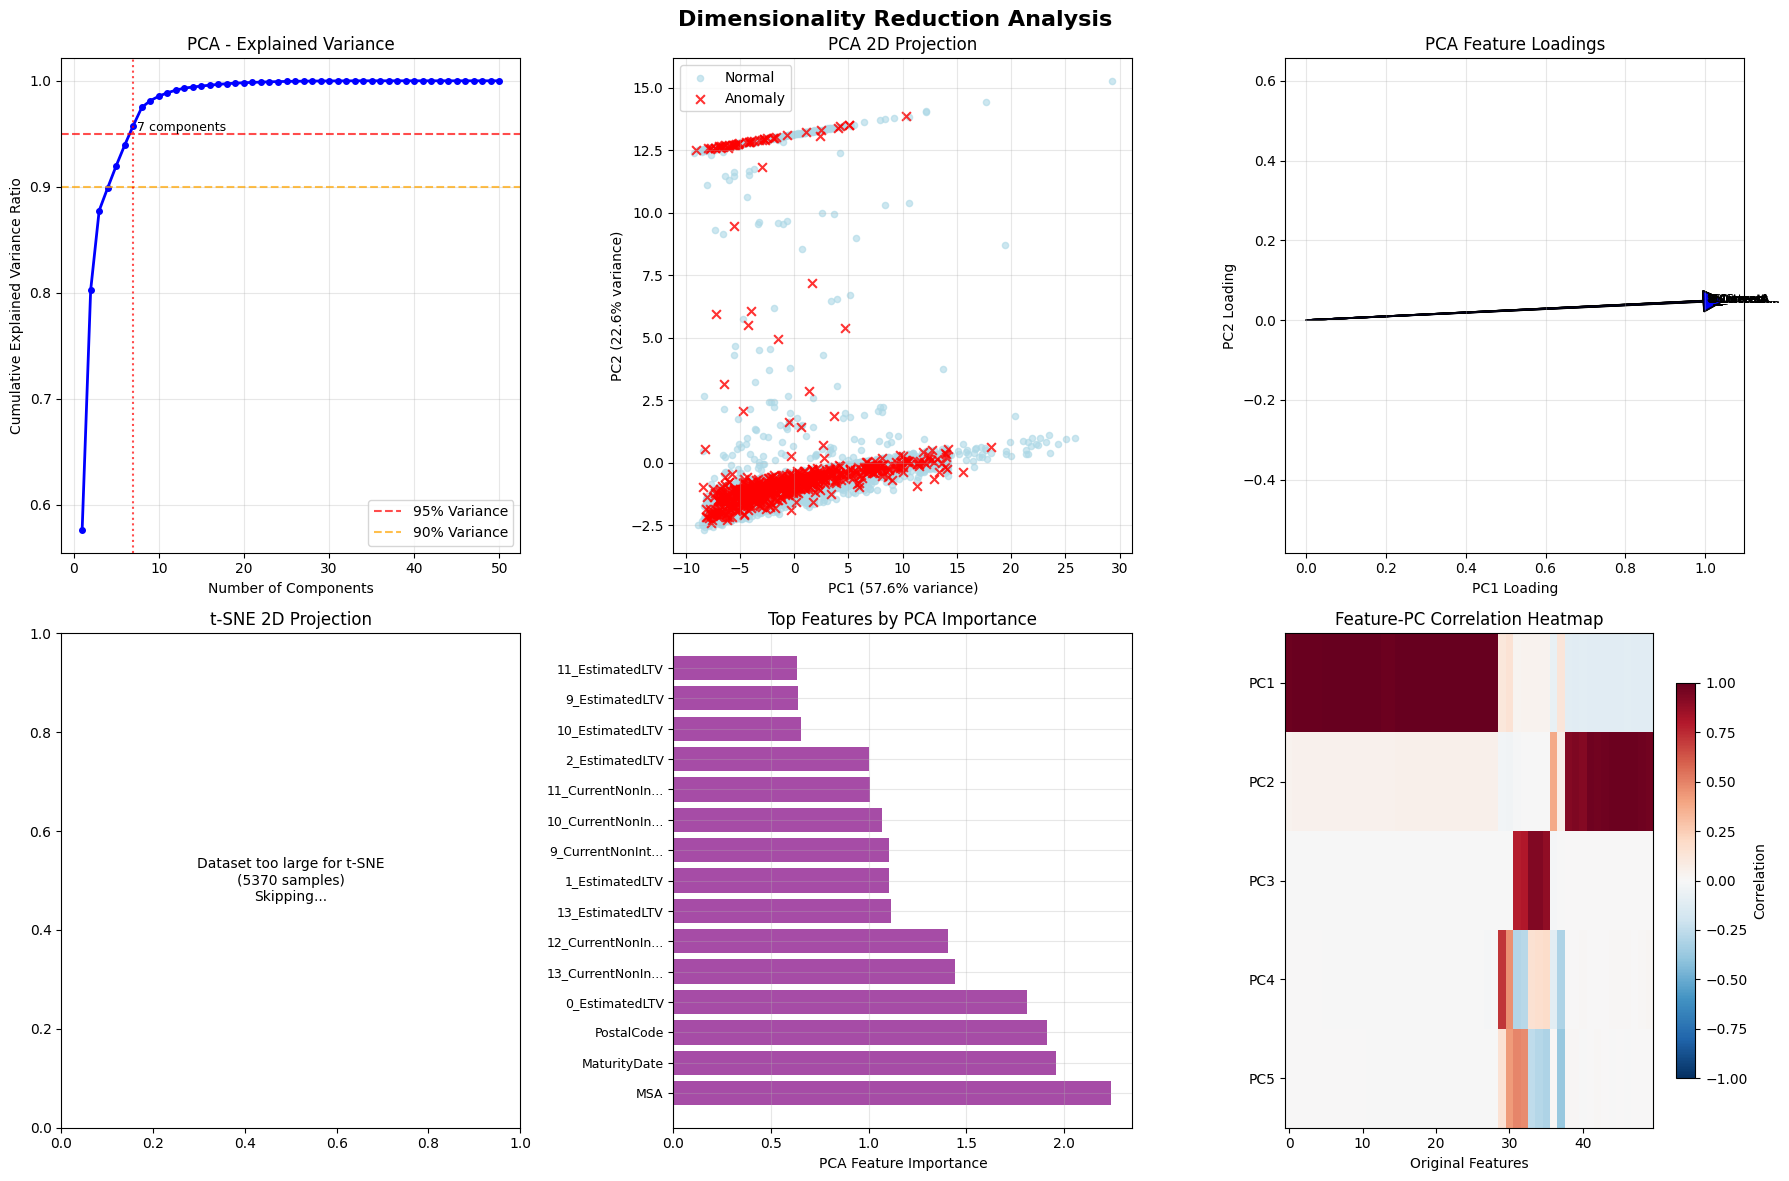

Generating statistical summary...


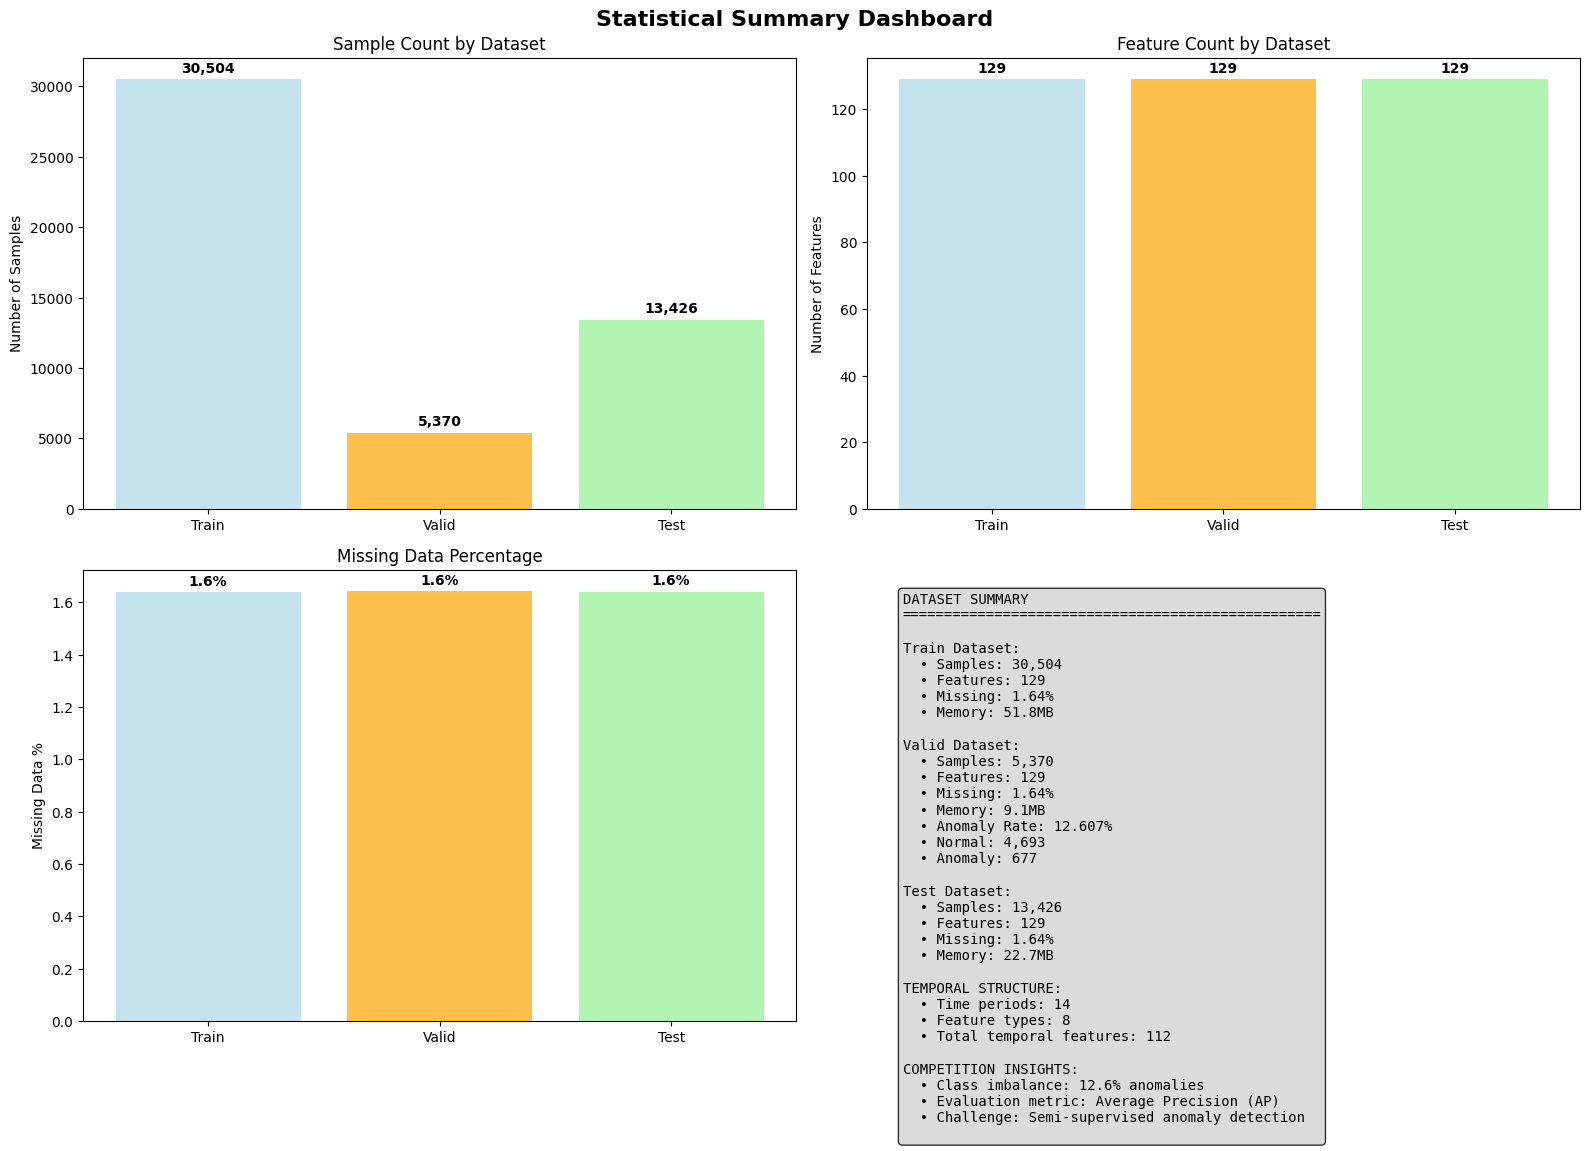

Analyzing feature engineering opportunities...


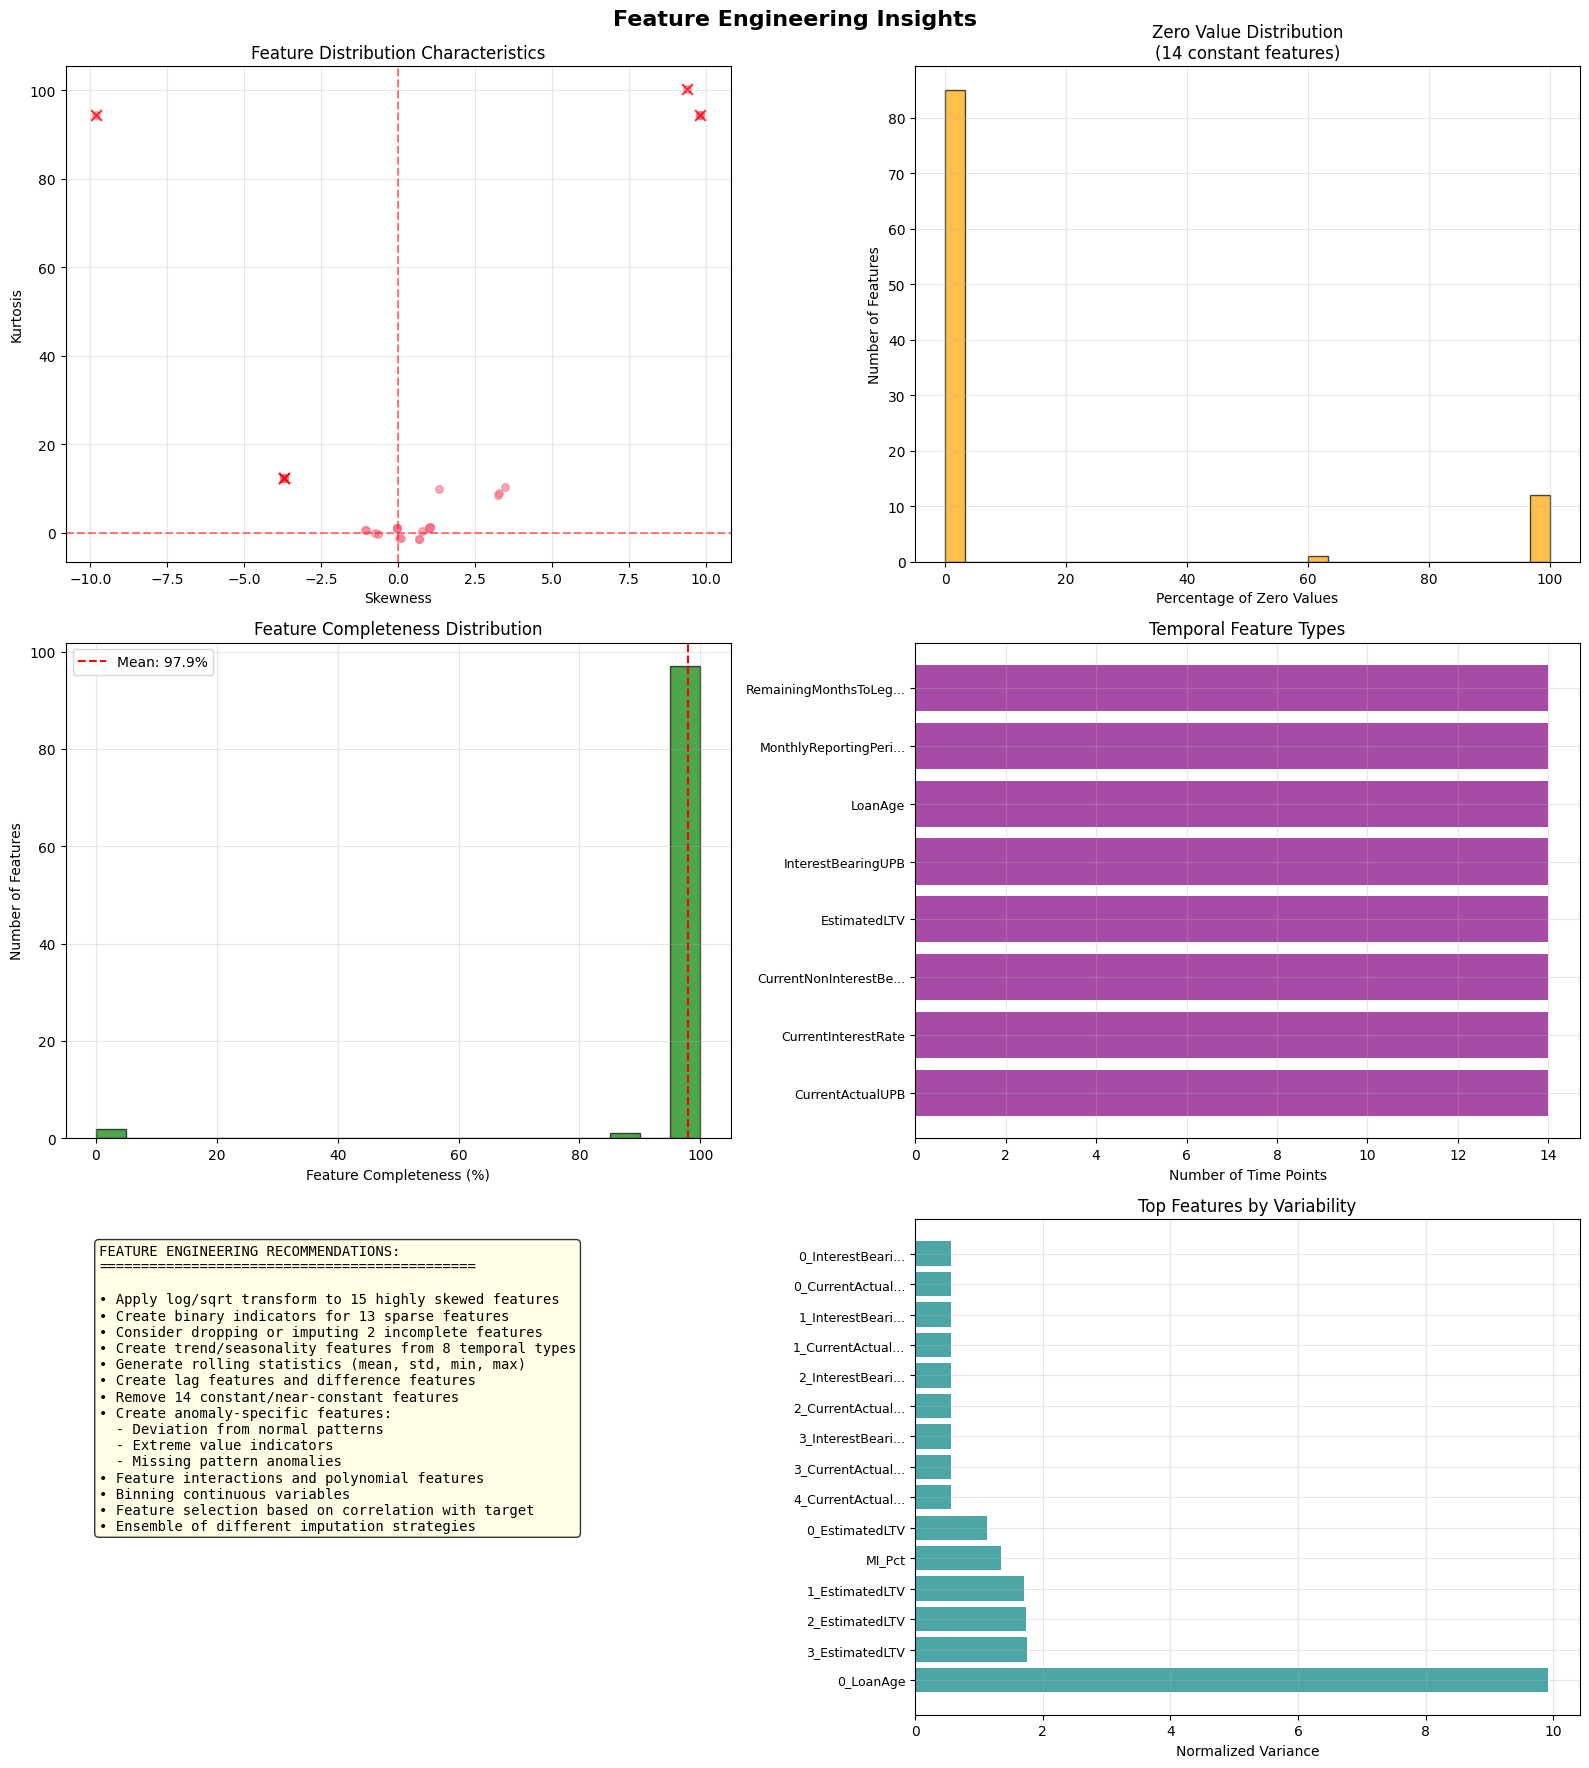


EDA COMPLETED SUCCESSFULLY!
Generated visualizations saved in: ./eda_plots/

Generated files:
  01_*.png
  02_*.png
  03_*.png
  04_*.png
  05_*.png
  06_*.png
  07_*.png
  08_*.png
  09_*.png

Dataset Summary:
  Train: 30,504 samples, 129 features
  Valid: 5,370 samples, 129 features
  Test: 13,426 samples, 129 features

🎉 EDA ANALYSIS COMPLETE! 🎉

Key insights for your competition:
1. Check the anomaly distribution patterns (Plot 3)
2. Review temporal trends that distinguish normal/anomaly (Plot 4)
3. Examine feature correlations with target (Plot 5)
4. Use dimensionality reduction insights for feature selection (Plot 7)
5. Follow feature engineering recommendations (Plot 9)

Next steps:
• Use insights to improve your feature engineering
• Focus on features showing clear normal/anomaly separation
• Consider the temporal patterns for time-series features
• Apply recommended transformations for skewed features


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_regression
import warnings
import os
import re
from datetime import datetime
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import re
import os
import time
import psutil
from datetime import datetime
from scipy.stats import mannwhitneyu, skew, kurtosis
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.feature_selection import SelectKBest, mutual_info_regression, VarianceThreshold
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

class ComprehensiveAnomalyEDA:
    """
    Comprehensive EDA specifically designed for anomaly detection competitions
    Focuses on understanding data patterns that distinguish normal from anomalous samples
    """
    
    def __init__(self, output_dir='./eda_plots'):
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        # Data containers
        self.train_df = None
        self.valid_df = None
        self.test_df = None
        
        # Analysis results
        self.feature_analysis = {}
        self.temporal_analysis = {}
        self.anomaly_insights = {}
        
    def load_data(self, train_path, valid_path, test_path):
        """Load all datasets with basic preprocessing"""
        print("Loading datasets for comprehensive EDA...")
        
        self.train_df = pd.read_csv(train_path, low_memory=False)
        self.valid_df = pd.read_csv(valid_path, low_memory=False)
        self.test_df = pd.read_csv(test_path, low_memory=False)
        
        # Standardize ID columns
        for df in [self.train_df, self.valid_df, self.test_df]:
            if 'Id' in df.columns and 'index' not in df.columns:
                df.rename(columns={'Id': 'index'}, inplace=True)
        
        print(f"Data loaded successfully:")
        print(f"  Train: {self.train_df.shape}")
        print(f"  Valid: {self.valid_df.shape}")
        print(f"  Test: {self.test_df.shape}")
        
        if 'target' in self.valid_df.columns:
            anomaly_rate = self.valid_df['target'].mean()
            print(f"  Validation anomaly rate: {anomaly_rate:.3%}")
        
        return self
    
    def dataset_overview(self):
        """Create comprehensive dataset overview visualizations"""
        print("Creating dataset overview...")
        
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)
        
        # 1. Dataset sizes and composition
        ax1 = fig.add_subplot(gs[0, 0])
        sizes = [len(self.train_df), len(self.valid_df), len(self.test_df)]
        colors = ['lightblue', 'orange', 'lightgreen']
        bars = ax1.bar(['Train', 'Valid', 'Test'], sizes, color=colors, alpha=0.7)
        ax1.set_title('Dataset Sizes', fontweight='bold')
        ax1.set_ylabel('Number of Samples')
        
        # Add value labels
        for bar, size in zip(bars, sizes):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sizes)*0.01,
                    f'{size:,}', ha='center', va='bottom', fontweight='bold')
        
        # 2. Feature counts comparison
        ax2 = fig.add_subplot(gs[0, 1])
        train_features = len([col for col in self.train_df.columns if col not in ['index', 'target']])
        valid_features = len([col for col in self.valid_df.columns if col not in ['index', 'target']])
        test_features = len([col for col in self.test_df.columns if col not in ['index', 'target']])
        
        feature_counts = [train_features, valid_features, test_features]
        bars = ax2.bar(['Train', 'Valid', 'Test'], feature_counts, color=colors, alpha=0.7)
        ax2.set_title('Feature Counts', fontweight='bold')
        ax2.set_ylabel('Number of Features')
        
        for bar, count in zip(bars, feature_counts):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(feature_counts)*0.01,
                    f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # 3. Class distribution (if available)
        if 'target' in self.valid_df.columns:
            ax3 = fig.add_subplot(gs[0, 2])
            class_counts = self.valid_df['target'].value_counts()
            colors_pie = ['lightblue', 'salmon']
            wedges, texts, autotexts = ax3.pie(class_counts.values, 
                                              labels=['Normal', 'Anomaly'],
                                              autopct='%1.2f%%',
                                              colors=colors_pie,
                                              startangle=90)
            ax3.set_title('Validation Class Distribution', fontweight='bold')
            
            for autotext in autotexts:
                autotext.set_fontweight('bold')
        
        # 4. Missing data overview
        ax4 = fig.add_subplot(gs[0, 3])
        datasets = [self.train_df, self.valid_df, self.test_df]
        dataset_names = ['Train', 'Valid', 'Test']
        missing_percentages = []
        
        for df in datasets:
            # Exclude ID and target columns
            feature_cols = [col for col in df.columns if col not in ['index', 'target']]
            missing_pct = (df[feature_cols].isnull().sum().sum() / 
                          (df[feature_cols].shape[0] * df[feature_cols].shape[1])) * 100
            missing_percentages.append(missing_pct)
        
        bars = ax4.bar(dataset_names, missing_percentages, color=colors, alpha=0.7)
        ax4.set_title('Missing Data Overview', fontweight='bold')
        ax4.set_ylabel('Missing Data %')
        
        for bar, pct in zip(bars, missing_percentages):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(missing_percentages)*0.01,
                    f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # 5. Feature type analysis
        ax5 = fig.add_subplot(gs[1, :2])
        feature_types = self._analyze_feature_types(self.train_df)
        
        type_names = list(feature_types.keys())
        type_counts = list(feature_types.values())
        colors_types = plt.cm.Set3(np.linspace(0, 1, len(type_names)))
        
        bars = ax5.bar(type_names, type_counts, color=colors_types, alpha=0.7)
        ax5.set_title('Feature Type Distribution', fontweight='bold')
        ax5.set_ylabel('Number of Features')
        ax5.tick_params(axis='x', rotation=45)
        
        for bar, count in zip(bars, type_counts):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(type_counts)*0.01,
                    f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # 6. Data types distribution
        ax6 = fig.add_subplot(gs[1, 2:])
        dtype_info = self._analyze_data_types(self.train_df)
        
        # Create a more detailed breakdown
        dtype_labels = []
        dtype_counts = []
        
        for dtype, cols in dtype_info.items():
            if len(cols) > 0:
                dtype_labels.append(f'{dtype}\n({len(cols)} cols)')
                dtype_counts.append(len(cols))
        
        if dtype_counts:
            wedges, texts, autotexts = ax6.pie(dtype_counts, labels=dtype_labels, 
                                              autopct='%1.1f%%', startangle=90)
            ax6.set_title('Data Types Distribution', fontweight='bold')
        
        # 7. Temporal structure analysis
        ax7 = fig.add_subplot(gs[2, :2])
        temporal_info = self._analyze_temporal_structure(self.train_df)
        
        if temporal_info['months'] and temporal_info['types']:
            months = sorted(temporal_info['months'])[:20]  # Show first 20 months
            month_counts = [len([col for col in self.train_df.columns if col.startswith(f'{m}_')]) 
                           for m in months]
            
            ax7.bar(range(len(months)), month_counts, alpha=0.7, color='skyblue')
            ax7.set_xlabel('Time Periods (Months)')
            ax7.set_ylabel('Number of Features')
            ax7.set_title('Temporal Feature Distribution', fontweight='bold')
            ax7.set_xticks(range(0, len(months), max(1, len(months)//10)))
            ax7.set_xticklabels([str(months[i]) for i in range(0, len(months), max(1, len(months)//10))], 
                               rotation=45)
        
        # 8. Top temporal feature types
        ax8 = fig.add_subplot(gs[2, 2:])
        if temporal_info['type_counts']:
            top_temp_types = dict(sorted(temporal_info['type_counts'].items(), 
                                       key=lambda x: x[1], reverse=True)[:10])
            
            y_pos = np.arange(len(top_temp_types))
            ax8.barh(y_pos, list(top_temp_types.values()), alpha=0.7, color='lightcoral')
            ax8.set_yticks(y_pos)
            ax8.set_yticklabels([name[:15] + '...' if len(name) > 15 else name 
                                for name in top_temp_types.keys()], fontsize=9)
            ax8.set_xlabel('Number of Time Points')
            ax8.set_title('Top 10 Temporal Feature Types', fontweight='bold')
        
        # 9. Memory usage analysis
        ax9 = fig.add_subplot(gs[3, :])
        memory_info = self._analyze_memory_usage()
        
        # Create memory usage breakdown
        datasets_mem = ['Train', 'Valid', 'Test'] 
        memory_mb = [memory_info['train_mb'], memory_info['valid_mb'], memory_info['test_mb']]
        
        bars = ax9.bar(datasets_mem, memory_mb, color=colors, alpha=0.7)
        ax9.set_title('Memory Usage by Dataset', fontweight='bold')
        ax9.set_ylabel('Memory Usage (MB)')
        
        for bar, mem in zip(bars, memory_mb):
            ax9.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(memory_mb)*0.01,
                    f'{mem:.1f}MB', ha='center', va='bottom', fontweight='bold')
        
        # Add total memory info
        total_mb = sum(memory_mb)
        ax9.text(0.5, 0.95, f'Total Memory: {total_mb:.1f}MB', 
                transform=ax9.transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.suptitle('Comprehensive Dataset Overview', fontsize=16, fontweight='bold')
        plt.savefig(f'{self.output_dir}/01_dataset_overview.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return self
    
    def missing_data_analysis(self):
        """Detailed missing data analysis"""
        print("Analyzing missing data patterns...")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Missing Data Analysis', fontsize=16, fontweight='bold')
        
        datasets = [('Train', self.train_df), ('Valid', self.valid_df), ('Test', self.test_df)]
        
        for idx, (name, df) in enumerate(datasets):
            ax = axes[0, idx]
            
            # Calculate missing percentages
            feature_cols = [col for col in df.columns if col not in ['index', 'target']]
            missing_pct = df[feature_cols].isnull().sum() / len(df) * 100
            missing_pct = missing_pct.sort_values(ascending=False)
            
            # Plot top 20 features with highest missing rates
            top_missing = missing_pct.head(20)
            if len(top_missing) > 0:
                y_pos = np.arange(len(top_missing))
                ax.barh(y_pos, top_missing.values, alpha=0.7)
                ax.set_yticks(y_pos)
                ax.set_yticklabels([name[:15] + '...' if len(name) > 15 else name 
                                   for name in top_missing.index], fontsize=8)
                ax.set_xlabel('Missing %')
                ax.set_title(f'{name} Dataset - Top Missing Features')
            
            # Missing data heatmap for temporal features
            ax2 = axes[1, idx]
            temporal_cols = [col for col in feature_cols if '_' in col and col.split('_')[0].isdigit()]
            
            if len(temporal_cols) > 0:
                # Sample temporal features for visualization
                sample_temporal = temporal_cols[:50] if len(temporal_cols) > 50 else temporal_cols
                temp_missing = df[sample_temporal].isnull()
                
                # Create missing data matrix
                if len(temp_missing) > 0:
                    # Sample rows for visualization if dataset is large
                    if len(temp_missing) > 1000:
                        sample_idx = np.random.choice(len(temp_missing), 1000, replace=False)
                        temp_missing_sample = temp_missing.iloc[sample_idx]
                    else:
                        temp_missing_sample = temp_missing
                    
                    im = ax2.imshow(temp_missing_sample.values, cmap='RdYlBu_r', aspect='auto')
                    ax2.set_title(f'{name} - Temporal Missing Pattern')
                    ax2.set_xlabel('Feature Index')
                    ax2.set_ylabel('Sample Index')
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/02_missing_data_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return self
    
    def anomaly_distribution_analysis(self):
        """Analyze the distribution of anomalies vs normal samples"""
        if 'target' not in self.valid_df.columns:
            print("No target column found - skipping anomaly distribution analysis")
            return self
        
        print("Analyzing anomaly distributions...")
        
        # Get numeric features for analysis
        numeric_cols = self.valid_df.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col not in ['index', 'target']]
        
        # Select interesting features for detailed analysis
        static_features = [col for col in feature_cols if not col.split('_')[0].isdigit()][:8]
        temporal_features = [col for col in feature_cols if col.split('_')[0].isdigit()][:8]
        
        # Create comprehensive comparison plots
        fig, axes = plt.subplots(4, 4, figsize=(20, 16))
        fig.suptitle('Normal vs Anomaly Distribution Analysis', fontsize=16, fontweight='bold')
        
        normal_data = self.valid_df[self.valid_df['target'] == 0]
        anomaly_data = self.valid_df[self.valid_df['target'] == 1]
        
        all_features = static_features + temporal_features
        
        for idx, feature in enumerate(all_features):
            if idx >= 16:  # Limit to 16 plots
                break
                
            row = idx // 4
            col = idx % 4
            ax = axes[row, col]
            
            if feature in self.valid_df.columns:
                normal_values = normal_data[feature].dropna()
                anomaly_values = anomaly_data[feature].dropna()
                
                if len(normal_values) > 0 and len(anomaly_values) > 0:
                    # Create overlapping histograms
                    bins = np.linspace(
                        min(normal_values.min(), anomaly_values.min()),
                        max(normal_values.max(), anomaly_values.max()),
                        30
                    )
                    
                    ax.hist(normal_values, bins=bins, alpha=0.7, label='Normal', density=True, color='lightblue')
                    ax.hist(anomaly_values, bins=bins, alpha=0.7, label='Anomaly', density=True, color='salmon')
                    
                    # Add statistical test
                    if len(normal_values) > 10 and len(anomaly_values) > 10:
                        stat, p_value = stats.mannwhitneyu(normal_values, anomaly_values, alternative='two-sided')
                        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                        
                        ax.text(0.02, 0.98, f'p={p_value:.3f}{significance}', 
                               transform=ax.transAxes, va='top', ha='left',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                    
                    ax.set_title(feature[:20] + '...' if len(feature) > 20 else feature, fontsize=10)
                    ax.legend(fontsize=8)
                    ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'Feature not found', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(feature[:20] + '...' if len(feature) > 20 else feature, fontsize=10)
        
        # Remove empty subplots
        for idx in range(len(all_features), 16):
            row = idx // 4
            col = idx % 4
            axes[row, col].remove()
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/03_anomaly_distributions.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return self
    
    def temporal_pattern_analysis(self):
        """Analyze temporal patterns and their relationship to anomalies"""
        print("Analyzing temporal patterns...")
        
        temporal_info = self._analyze_temporal_structure(self.train_df)
        
        if not temporal_info['types']:
            print("No temporal features found - skipping temporal analysis")
            return self
        
        # Focus on top temporal feature types
        top_temporal_types = sorted(temporal_info['type_counts'].items(), 
                                  key=lambda x: x[1], reverse=True)[:6]
        
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle('Temporal Pattern Analysis', fontsize=16, fontweight='bold')
        
        for idx, (temp_type, count) in enumerate(top_temporal_types):
            row = idx // 2
            col = idx % 2
            ax = axes[row, col]
            
            # Get all columns for this temporal type
            temp_cols = [col for col in self.valid_df.columns 
                        if col.endswith(f'_{temp_type}') and col.split('_')[0].isdigit()]
            temp_cols = sorted(temp_cols, key=lambda x: int(x.split('_')[0]))[:24]  # First 24 months
            
            if len(temp_cols) >= 6 and 'target' in self.valid_df.columns:
                # Calculate mean values over time for normal vs anomalous samples
                normal_data = self.valid_df[self.valid_df['target'] == 0]
                anomaly_data = self.valid_df[self.valid_df['target'] == 1]
                
                months = [int(col.split('_')[0]) for col in temp_cols]
                normal_means = [normal_data[col].mean() for col in temp_cols]
                anomaly_means = [anomaly_data[col].mean() for col in temp_cols]
                
                # Plot temporal evolution
                ax.plot(months, normal_means, label='Normal', linewidth=2, marker='o', alpha=0.7)
                ax.plot(months, anomaly_means, label='Anomaly', linewidth=2, marker='s', alpha=0.7)
                
                # Add confidence intervals
                normal_stds = [normal_data[col].std() / np.sqrt(len(normal_data)) for col in temp_cols]
                anomaly_stds = [anomaly_data[col].std() / np.sqrt(len(anomaly_data)) for col in temp_cols]
                
                ax.fill_between(months, 
                               [m - s for m, s in zip(normal_means, normal_stds)],
                               [m + s for m, s in zip(normal_means, normal_stds)],
                               alpha=0.2, label='Normal ±SE')
                ax.fill_between(months,
                               [m - s for m, s in zip(anomaly_means, anomaly_stds)],
                               [m + s for m, s in zip(anomaly_means, anomaly_stds)],
                               alpha=0.2, label='Anomaly ±SE')
                
                ax.set_xlabel('Month')
                ax.set_ylabel('Mean Value')
                ax.set_title(f'{temp_type}\n({count} time points available)')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                # Highlight significant differences
                for i, (month, normal_mean, anomaly_mean) in enumerate(zip(months, normal_means, anomaly_means)):
                    if abs(normal_mean - anomaly_mean) > max(normal_stds[i], anomaly_stds[i]) * 2:
                        ax.axvline(x=month, color='red', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/04_temporal_patterns.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return self
    
    def feature_correlation_analysis(self):
        """Analyze feature correlations and relationships"""
        print("Analyzing feature correlations...")
        
        # Get numeric features
        numeric_cols = self.valid_df.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col not in ['index', 'target']]
        
        # Sample features for correlation analysis (limit to prevent memory issues)
        if len(feature_cols) > 50:
            # Select mix of static and temporal features
            static_features = [col for col in feature_cols if not col.split('_')[0].isdigit()][:25]
            temporal_features = [col for col in feature_cols if col.split('_')[0].isdigit()][:25]
            selected_features = static_features + temporal_features
        else:
            selected_features = feature_cols
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Feature Correlation Analysis', fontsize=16, fontweight='bold')
        
        # 1. Overall correlation heatmap
        ax1 = axes[0, 0]
        correlation_data = self.valid_df[selected_features].corr()
        
        # Create mask for upper triangle
        mask = np.triu(np.ones_like(correlation_data, dtype=bool))
        
        sns.heatmap(correlation_data, mask=mask, annot=False, cmap='RdBu_r', center=0,
                   square=True, linewidths=0.5, ax=ax1, cbar_kws={'shrink': 0.8})
        ax1.set_title('Feature Correlation Heatmap')
        
        # 2. Correlation with target (if available)
        if 'target' in self.valid_df.columns:
            ax2 = axes[0, 1]
            target_corrs = []
            feature_names = []
            
            for feature in selected_features:
                if feature in self.valid_df.columns:
                    corr = self.valid_df[feature].corr(self.valid_df['target'])
                    if not np.isnan(corr):
                        target_corrs.append(abs(corr))  # Use absolute correlation
                        feature_names.append(feature)
            
            # Sort by correlation strength
            sorted_pairs = sorted(zip(target_corrs, feature_names), reverse=True)
            top_corrs = sorted_pairs[:15]  # Top 15 correlations
            
            if top_corrs:
                corrs, names = zip(*top_corrs)
                y_pos = np.arange(len(names))
                
                bars = ax2.barh(y_pos, corrs, alpha=0.7, color='orange')
                ax2.set_yticks(y_pos)
                ax2.set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                                    for name in names], fontsize=9)
                ax2.set_xlabel('Absolute Correlation with Target')
                ax2.set_title('Top Features by Target Correlation')
                ax2.grid(True, alpha=0.3)
        
        # 3. High correlation pairs
        ax3 = axes[1, 0]
        high_corr_pairs = []
        
        for i in range(len(correlation_data.columns)):
            for j in range(i+1, len(correlation_data.columns)):
                corr_val = correlation_data.iloc[i, j]
                if abs(corr_val) > 0.7:  # High correlation threshold
                    high_corr_pairs.append((
                        correlation_data.columns[i],
                        correlation_data.columns[j],
                        corr_val
                    ))
        
        if high_corr_pairs:
            high_corr_pairs = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:15]
            
            pair_labels = [f'{pair[0][:10]}...\nvs\n{pair[1][:10]}...' for pair in high_corr_pairs]
            corr_values = [pair[2] for pair in high_corr_pairs]
            
            colors = ['red' if corr > 0 else 'blue' for corr in corr_values]
            bars = ax3.bar(range(len(pair_labels)), corr_values, color=colors, alpha=0.7)
            
            ax3.set_xticks(range(len(pair_labels)))
            ax3.set_xticklabels(pair_labels, rotation=45, ha='right', fontsize=8)
            ax3.set_ylabel('Correlation Coefficient')
            ax3.set_title('High Correlation Feature Pairs (|r| > 0.7)')
            ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'No high correlations found\n(threshold: |r| > 0.7)', 
                    ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('High Correlation Feature Pairs')
        
        # 4. Feature variance analysis
        ax4 = axes[1, 1]
        variances = self.valid_df[selected_features].var().sort_values(ascending=False)
        top_var_features = variances.head(15)
        
        y_pos = np.arange(len(top_var_features))
        bars = ax4.barh(y_pos, top_var_features.values, alpha=0.7, color='green')
        ax4.set_yticks(y_pos)
        ax4.set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                           for name in top_var_features.index], fontsize=9)
        ax4.set_xlabel('Variance')
        ax4.set_title('Top Features by Variance')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/05_correlation_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return self
    
    def outlier_detection_analysis(self):
        """Analyze outliers and extreme values"""
        print("Analyzing outliers and extreme values...")
        
        numeric_cols = self.valid_df.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col not in ['index', 'target']]
        
        # Select representative features
        static_features = [col for col in feature_cols if not col.split('_')[0].isdigit()][:8]
        temporal_features = [col for col in feature_cols if col.split('_')[0].isdigit()][:8]
        selected_features = static_features + temporal_features
        
        fig, axes = plt.subplots(4, 4, figsize=(20, 16))
        fig.suptitle('Outlier Detection Analysis', fontsize=16, fontweight='bold')
        
        for idx, feature in enumerate(selected_features):
            if idx >= 16:
                break
                
            row = idx // 4
            col = idx % 4
            ax = axes[row, col]
            
            if feature in self.valid_df.columns:
                data = self.valid_df[feature].dropna()
                
                if len(data) > 0:
                    # Box plot with outlier highlighting
                    if 'target' in self.valid_df.columns:
                        # Separate by class
                        normal_data = self.valid_df[self.valid_df['target'] == 0][feature].dropna()
                        anomaly_data = self.valid_df[self.valid_df['target'] == 1][feature].dropna()
                        
                        box_data = [normal_data, anomaly_data]
                        box_labels = ['Normal', 'Anomaly']
                        
                        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)
                        bp['boxes'][0].set_facecolor('lightblue')
                        bp['boxes'][1].set_facecolor('salmon')
                        
                        # Calculate outlier statistics
                        q1, q3 = np.percentile(data, [25, 75])
                        iqr = q3 - q1
                        outlier_threshold = 1.5 * iqr
                        outliers = data[(data < q1 - outlier_threshold) | (data > q3 + outlier_threshold)]
                        
                        ax.set_title(f'{feature[:15]}...\n{len(outliers)} outliers ({len(outliers)/len(data)*100:.1f}%)', 
                                   fontsize=9)
                    else:
                        # Single box plot
                        ax.boxplot(data)
                        ax.set_title(feature[:20] + '...' if len(feature) > 20 else feature, fontsize=9)
                    
                    ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'Feature not found', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(feature[:20] + '...' if len(feature) > 20 else feature, fontsize=9)
        
        # Remove empty subplots
        for idx in range(len(selected_features), 16):
            row = idx // 4
            col = idx % 4
            axes[row, col].remove()
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/06_outlier_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return self
    
    def dimensionality_reduction_analysis(self):
        """Analyze data using dimensionality reduction techniques"""
        print("Performing dimensionality reduction analysis...")
        
        # Prepare data for dimensionality reduction
        numeric_cols = self.valid_df.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col not in ['index', 'target']]
        
        # Select subset of features to avoid memory issues
        if len(feature_cols) > 50:
            # Use variance-based selection
            variances = self.valid_df[feature_cols].var()
            top_features = variances.nlargest(50).index.tolist()
        else:
            top_features = feature_cols
        
        # Prepare data
        data_for_reduction = self.valid_df[top_features].fillna(0)
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_for_reduction)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Dimensionality Reduction Analysis', fontsize=16, fontweight='bold')
        
        # 1. PCA Analysis
        ax1 = axes[0, 0]
        pca = PCA()
        pca.fit(data_scaled)
        
        # Explained variance ratio
        cumsum_var = np.cumsum(pca.explained_variance_ratio_)
        ax1.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'bo-', linewidth=2, markersize=4)
        ax1.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% Variance')
        ax1.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% Variance')
        
        # Find number of components for 95% variance
        n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
        ax1.axvline(x=n_components_95, color='red', linestyle=':', alpha=0.7)
        ax1.text(n_components_95, 0.95, f' {n_components_95} components', 
                verticalalignment='bottom', fontsize=9)
        
        ax1.set_xlabel('Number of Components')
        ax1.set_ylabel('Cumulative Explained Variance Ratio')
        ax1.set_title('PCA - Explained Variance')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. PCA 2D Projection
        ax2 = axes[0, 1]
        pca_2d = PCA(n_components=2)
        data_pca = pca_2d.fit_transform(data_scaled)
        
        if 'target' in self.valid_df.columns:
            normal_idx = self.valid_df['target'] == 0
            anomaly_idx = self.valid_df['target'] == 1
            
            ax2.scatter(data_pca[normal_idx, 0], data_pca[normal_idx, 1], 
                       c='lightblue', alpha=0.6, s=20, label='Normal')
            ax2.scatter(data_pca[anomaly_idx, 0], data_pca[anomaly_idx, 1], 
                       c='red', alpha=0.8, s=40, marker='x', label='Anomaly')
        else:
            ax2.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.6, s=20)
        
        ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
        ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
        ax2.set_title('PCA 2D Projection')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Feature loadings for first two PCs
        ax3 = axes[0, 2]
        feature_loadings = pca_2d.components_.T * np.sqrt(pca_2d.explained_variance_)
        
        # Show top contributing features
        loading_magnitude = np.sqrt(feature_loadings[:, 0]**2 + feature_loadings[:, 1]**2)
        top_loading_idx = np.argsort(loading_magnitude)[-15:]  # Top 15 features
        
        for i in top_loading_idx:
            ax3.arrow(0, 0, feature_loadings[i, 0], feature_loadings[i, 1], 
                     head_width=0.05, head_length=0.05, fc='blue', alpha=0.7)
            ax3.text(feature_loadings[i, 0]*1.1, feature_loadings[i, 1]*1.1, 
                    top_features[i][:10] + '...' if len(top_features[i]) > 10 else top_features[i], 
                    fontsize=8, ha='center', va='center')
        
        ax3.set_xlabel('PC1 Loading')
        ax3.set_ylabel('PC2 Loading')
        ax3.set_title('PCA Feature Loadings')
        ax3.grid(True, alpha=0.3)
        ax3.axis('equal')
        
        # 4. t-SNE Analysis (if data size is manageable)
        ax4 = axes[1, 0]
        if len(data_scaled) <= 5000:  # t-SNE is computationally expensive
            print("  Computing t-SNE (this may take a while)...")
            try:
                tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(data_scaled)//4))
                data_tsne = tsne.fit_transform(data_scaled)
                
                if 'target' in self.valid_df.columns:
                    ax4.scatter(data_tsne[normal_idx, 0], data_tsne[normal_idx, 1], 
                               c='lightblue', alpha=0.6, s=20, label='Normal')
                    ax4.scatter(data_tsne[anomaly_idx, 0], data_tsne[anomaly_idx, 1], 
                               c='red', alpha=0.8, s=40, marker='x', label='Anomaly')
                else:
                    ax4.scatter(data_tsne[:, 0], data_tsne[:, 1], alpha=0.6, s=20)
                
                ax4.set_xlabel('t-SNE 1')
                ax4.set_ylabel('t-SNE 2')
                ax4.set_title('t-SNE 2D Projection')
                ax4.legend()
            except Exception as e:
                ax4.text(0.5, 0.5, f't-SNE failed:\n{str(e)[:50]}...', 
                        ha='center', va='center', transform=ax4.transAxes)
                ax4.set_title('t-SNE 2D Projection')
        else:
            ax4.text(0.5, 0.5, f'Dataset too large for t-SNE\n({len(data_scaled)} samples)\nSkipping...', 
                    ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('t-SNE 2D Projection')
        
        # 5. Feature importance based on PCA loadings
        ax5 = axes[1, 1]
        n_components = min(10, len(pca.components_))
        feature_importance = np.sum(np.abs(pca.components_[:n_components]), axis=0)
        feature_names = [top_features[i] for i in range(len(feature_importance))]
        
        # Get top 15 most important features
        importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
        top_importance = importance_df.nlargest(15, 'importance')
        
        y_pos = np.arange(len(top_importance))
        ax5.barh(y_pos, top_importance['importance'].values, alpha=0.7, color='purple')
        ax5.set_yticks(y_pos)
        ax5.set_yticklabels([name[:15] + '...' if len(name) > 15 else name 
                           for name in top_importance['feature']], fontsize=9)
        ax5.set_xlabel('PCA Feature Importance')
        ax5.set_title('Top Features by PCA Importance')
        ax5.grid(True, alpha=0.3)
        
        # 6. Correlation between original features and principal components
        ax6 = axes[1, 2]
        if len(pca.components_) >= 5:
            pc_correlations = np.corrcoef(data_scaled.T, pca.transform(data_scaled)[:, :5].T)
            pc_corr_subset = pc_correlations[:len(top_features), -5:]
            
            im = ax6.imshow(pc_corr_subset.T, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
            ax6.set_yticks(range(5))
            ax6.set_yticklabels([f'PC{i+1}' for i in range(5)])
            ax6.set_xlabel('Original Features')
            ax6.set_title('Feature-PC Correlation Heatmap')
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax6, shrink=0.8)
            cbar.set_label('Correlation')
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/07_dimensionality_reduction.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return self
    
    def statistical_summary(self):
        """Generate comprehensive statistical summary"""
        print("Generating statistical summary...")
        
        # Create summary statistics
        summary_stats = {}
        
        for dataset_name, df in [('Train', self.train_df), ('Valid', self.valid_df), ('Test', self.test_df)]:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            feature_cols = [col for col in numeric_cols if col not in ['index', 'target']]
            
            stats_dict = {
                'total_samples': len(df),
                'total_features': len(feature_cols),
                'missing_data_pct': (df[feature_cols].isnull().sum().sum() / 
                                   (len(df) * len(feature_cols))) * 100,
                'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2
            }
            
            if dataset_name == 'Valid' and 'target' in df.columns:
                stats_dict['anomaly_rate'] = df['target'].mean()
                stats_dict['normal_samples'] = (df['target'] == 0).sum()
                stats_dict['anomaly_samples'] = (df['target'] == 1).sum()
            
            summary_stats[dataset_name] = stats_dict
        
        # Create visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Statistical Summary Dashboard', fontsize=16, fontweight='bold')
        
        # 1. Dataset size comparison
        datasets = list(summary_stats.keys())
        sample_counts = [summary_stats[d]['total_samples'] for d in datasets]
        
        bars = ax1.bar(datasets, sample_counts, alpha=0.7, color=['lightblue', 'orange', 'lightgreen'])
        ax1.set_title('Sample Count by Dataset')
        ax1.set_ylabel('Number of Samples')
        
        for bar, count in zip(bars, sample_counts):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sample_counts)*0.01,
                    f'{count:,}', ha='center', va='bottom', fontweight='bold')
        
        # 2. Feature count comparison
        feature_counts = [summary_stats[d]['total_features'] for d in datasets]
        bars = ax2.bar(datasets, feature_counts, alpha=0.7, color=['lightblue', 'orange', 'lightgreen'])
        ax2.set_title('Feature Count by Dataset')
        ax2.set_ylabel('Number of Features')
        
        for bar, count in zip(bars, feature_counts):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(feature_counts)*0.01,
                    f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # 3. Missing data comparison
        missing_pcts = [summary_stats[d]['missing_data_pct'] for d in datasets]
        bars = ax3.bar(datasets, missing_pcts, alpha=0.7, color=['lightblue', 'orange', 'lightgreen'])
        ax3.set_title('Missing Data Percentage')
        ax3.set_ylabel('Missing Data %')
        
        for bar, pct in zip(bars, missing_pcts):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(missing_pcts)*0.01,
                    f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # 4. Summary text
        ax4.axis('off')
        summary_text = "DATASET SUMMARY\n" + "="*50 + "\n\n"
        
        for dataset_name, stats in summary_stats.items():
            summary_text += f"{dataset_name} Dataset:\n"
            summary_text += f"  • Samples: {stats['total_samples']:,}\n"
            summary_text += f"  • Features: {stats['total_features']:,}\n"
            summary_text += f"  • Missing: {stats['missing_data_pct']:.2f}%\n"
            summary_text += f"  • Memory: {stats['memory_usage_mb']:.1f}MB\n"
            
            if 'anomaly_rate' in stats:
                summary_text += f"  • Anomaly Rate: {stats['anomaly_rate']:.3%}\n"
                summary_text += f"  • Normal: {stats['normal_samples']:,}\n"
                summary_text += f"  • Anomaly: {stats['anomaly_samples']:,}\n"
            
            summary_text += "\n"
        
        # Add temporal information
        temporal_info = self._analyze_temporal_structure(self.train_df)
        if temporal_info['types']:
            summary_text += f"TEMPORAL STRUCTURE:\n"
            summary_text += f"  • Time periods: {len(temporal_info['months'])}\n"
            summary_text += f"  • Feature types: {len(temporal_info['types'])}\n"
            summary_text += f"  • Total temporal features: {sum(temporal_info['type_counts'].values())}\n\n"
        
        # Competition insights
        if 'Valid' in summary_stats and 'anomaly_rate' in summary_stats['Valid']:
            anomaly_rate = summary_stats['Valid']['anomaly_rate']
            summary_text += f"COMPETITION INSIGHTS:\n"
            summary_text += f"  • Class imbalance: {anomaly_rate:.1%} anomalies\n"
            
            if anomaly_rate < 0.1:
                summary_text += f"  • High imbalance - focus on precision/recall balance\n"
            
            summary_text += f"  • Evaluation metric: Average Precision (AP)\n"
            summary_text += f"  • Challenge: Semi-supervised anomaly detection\n"
        
        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/08_statistical_summary.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Store summary for later use
        self.summary_stats = summary_stats
        
        return self
    
    def feature_engineering_insights(self):
        """Analyze potential feature engineering opportunities"""
        print("Analyzing feature engineering opportunities...")
        
        numeric_cols = self.valid_df.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col not in ['index', 'target']]
        
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle('Feature Engineering Insights', fontsize=16, fontweight='bold')
        
        # 1. Feature distribution analysis
        ax1 = axes[0, 0]
        skewness_values = []
        kurtosis_values = []
        feature_names = []
        
        for feature in feature_cols[:50]:  # Limit to first 50 features
            if feature in self.valid_df.columns:
                data = self.valid_df[feature].dropna()
                if len(data) > 10:
                    skew = stats.skew(data)
                    kurt = stats.kurtosis(data)
                    if not (np.isnan(skew) or np.isnan(kurt)):
                        skewness_values.append(skew)
                        kurtosis_values.append(kurt)
                        feature_names.append(feature)
        
        if skewness_values:
            scatter = ax1.scatter(skewness_values, kurtosis_values, alpha=0.6, s=30)
            ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
            ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
            ax1.set_xlabel('Skewness')
            ax1.set_ylabel('Kurtosis')
            ax1.set_title('Feature Distribution Characteristics')
            ax1.grid(True, alpha=0.3)
            
            # Highlight extreme cases
            extreme_skew = [(i, name) for i, (skew, name) in enumerate(zip(skewness_values, feature_names)) 
                           if abs(skew) > 2]
            extreme_kurt = [(i, name) for i, (kurt, name) in enumerate(zip(kurtosis_values, feature_names)) 
                           if abs(kurt) > 5]
            
            if extreme_skew:
                extreme_indices = [i for i, _ in extreme_skew[:5]]  # Top 5
                ax1.scatter([skewness_values[i] for i in extreme_indices],
                           [kurtosis_values[i] for i in extreme_indices], 
                           color='red', s=60, alpha=0.8, marker='x')
        
        # 2. Zero/constant value analysis
        ax2 = axes[0, 1]
        zero_counts = []
        constant_features = []
        
        for feature in feature_cols[:100]:  # Check first 100 features
            if feature in self.valid_df.columns:
                data = self.valid_df[feature].dropna()
                if len(data) > 0:
                    zero_pct = (data == 0).sum() / len(data) * 100
                    zero_counts.append(zero_pct)
                    
                    # Check if feature is constant
                    if data.nunique() <= 1:
                        constant_features.append(feature)
        
        if zero_counts:
            ax2.hist(zero_counts, bins=30, alpha=0.7, color='orange', edgecolor='black')
            ax2.set_xlabel('Percentage of Zero Values')
            ax2.set_ylabel('Number of Features')
            ax2.set_title(f'Zero Value Distribution\n({len(constant_features)} constant features)')
            ax2.grid(True, alpha=0.3)
        
        # 3. Feature completeness analysis
        ax3 = axes[1, 0]
        completeness_scores = []
        feature_completeness_names = []
        
        for feature in feature_cols[:100]:
            if feature in self.valid_df.columns:
                completeness = (1 - self.valid_df[feature].isnull().sum() / len(self.valid_df)) * 100
                completeness_scores.append(completeness)
                feature_completeness_names.append(feature)
        
        if completeness_scores:
            ax3.hist(completeness_scores, bins=20, alpha=0.7, color='green', edgecolor='black')
            ax3.set_xlabel('Feature Completeness (%)')
            ax3.set_ylabel('Number of Features')
            ax3.set_title('Feature Completeness Distribution')
            ax3.grid(True, alpha=0.3)
            
            # Add statistics
            mean_completeness = np.mean(completeness_scores)
            ax3.axvline(x=mean_completeness, color='red', linestyle='--', 
                       label=f'Mean: {mean_completeness:.1f}%')
            ax3.legend()
        
        # 4. Temporal feature analysis
        ax4 = axes[1, 1]
        temporal_info = self._analyze_temporal_structure(self.valid_df)
        
        if temporal_info['type_counts']:
            # Show temporal feature type distribution
            temp_types = list(temporal_info['type_counts'].keys())[:15]  # Top 15
            temp_counts = [temporal_info['type_counts'][t] for t in temp_types]
            
            y_pos = np.arange(len(temp_types))
            bars = ax4.barh(y_pos, temp_counts, alpha=0.7, color='purple')
            ax4.set_yticks(y_pos)
            ax4.set_yticklabels([t[:20] + '...' if len(t) > 20 else t for t in temp_types], fontsize=9)
            ax4.set_xlabel('Number of Time Points')
            ax4.set_title('Temporal Feature Types')
            ax4.grid(True, alpha=0.3)
        
        # 5. Feature engineering recommendations
        ax5 = axes[2, 0]
        ax5.axis('off')
        
        recommendations = []
        
        # High skewness features
        if skewness_values:
            high_skew_features = [name for skew, name in zip(skewness_values, feature_names) 
                                 if abs(skew) > 2]
            if high_skew_features:
                recommendations.append(f"• Apply log/sqrt transform to {len(high_skew_features)} highly skewed features")
        
        # High zero percentage features
        if zero_counts:
            high_zero_features = [i for i, zc in enumerate(zero_counts) if zc > 50]
            if high_zero_features:
                recommendations.append(f"• Create binary indicators for {len(high_zero_features)} sparse features")
        
        # Missing data features
        if completeness_scores:
            low_completeness = [score for score in completeness_scores if score < 80]
            if low_completeness:
                recommendations.append(f"• Consider dropping or imputing {len(low_completeness)} incomplete features")
        
        # Temporal features
        if temporal_info['types']:
            recommendations.append(f"• Create trend/seasonality features from {len(temporal_info['types'])} temporal types")
            recommendations.append("• Generate rolling statistics (mean, std, min, max)")
            recommendations.append("• Create lag features and difference features")
        
        # Constant features
        if constant_features:
            recommendations.append(f"• Remove {len(constant_features)} constant/near-constant features")
        
        # Anomaly-specific recommendations
        if 'target' in self.valid_df.columns:
            recommendations.append("• Create anomaly-specific features:")
            recommendations.append("  - Deviation from normal patterns")
            recommendations.append("  - Extreme value indicators")
            recommendations.append("  - Missing pattern anomalies")
        
        # General recommendations
        recommendations.extend([
            "• Feature interactions and polynomial features",
            "• Binning continuous variables",
            "• Feature selection based on correlation with target",
            "• Ensemble of different imputation strategies"
        ])
        
        rec_text = "FEATURE ENGINEERING RECOMMENDATIONS:\n" + "="*45 + "\n\n"
        rec_text += "\n".join(recommendations)
        
        ax5.text(0.05, 0.95, rec_text, transform=ax5.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        
        # 6. Feature importance proxy (variance-based)
        ax6 = axes[2, 1]
        if len(feature_cols) > 0:
            # Calculate normalized variance for features
            feature_vars = []
            var_feature_names = []
            
            for feature in feature_cols[:50]:  # Limit for performance
                if feature in self.valid_df.columns:
                    data = self.valid_df[feature].dropna()
                    if len(data) > 1 and data.std() > 0:
                        normalized_var = data.std() / (abs(data.mean()) + 1e-8)
                        feature_vars.append(normalized_var)
                        var_feature_names.append(feature)
            
            if feature_vars:
                # Show top 15 features by normalized variance
                var_df = pd.DataFrame({'feature': var_feature_names, 'norm_var': feature_vars})
                top_var_features = var_df.nlargest(15, 'norm_var')
                
                y_pos = np.arange(len(top_var_features))
                bars = ax6.barh(y_pos, top_var_features['norm_var'].values, alpha=0.7, color='teal')
                ax6.set_yticks(y_pos)
                ax6.set_yticklabels([name[:15] + '...' if len(name) > 15 else name 
                                   for name in top_var_features['feature']], fontsize=9)
                ax6.set_xlabel('Normalized Variance')
                ax6.set_title('Top Features by Variability')
                ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/09_feature_engineering_insights.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return self
    
    def run_comprehensive_eda(self, train_path, valid_path, test_path):
        """Run the complete EDA pipeline"""
        print("="*80)
        print("COMPREHENSIVE ANOMALY DETECTION EDA")
        print("="*80)
        
        try:
            # Load data
            self.load_data(train_path, valid_path, test_path)
            
            # Run all analyses
            self.dataset_overview()
            self.missing_data_analysis()
            self.anomaly_distribution_analysis()
            self.temporal_pattern_analysis()
            self.feature_correlation_analysis()
            self.outlier_detection_analysis()
            self.dimensionality_reduction_analysis()
            self.statistical_summary()
            self.feature_engineering_insights()
            
            print("\n" + "="*80)
            print("EDA COMPLETED SUCCESSFULLY!")
            print("="*80)
            print(f"Generated visualizations saved in: {self.output_dir}/")
            print("\nGenerated files:")
            for i in range(1, 10):
                filename = f"{i:02d}_*.png"
                print(f"  {filename}")
            
            print(f"\nDataset Summary:")
            if hasattr(self, 'summary_stats'):
                for dataset, stats in self.summary_stats.items():
                    print(f"  {dataset}: {stats['total_samples']:,} samples, {stats['total_features']} features")
            
            return True
            
        except Exception as e:
            print(f"EDA pipeline failed: {e}")
            import traceback
            traceback.print_exc()
            return False
    
    # Helper methods
    def _analyze_feature_types(self, df):
        """Analyze different types of features in the dataset"""
        feature_types = {
            'Static_Numeric': 0,
            'Temporal': 0,
            'Categorical': 0,
            'Binary': 0,
            'ID_Columns': 0
        }
        
        for col in df.columns:
            if col in ['index', 'Id', 'target']:
                feature_types['ID_Columns'] += 1
            elif '_' in col and col.split('_')[0].isdigit():
                feature_types['Temporal'] += 1
            elif df[col].dtype == 'object':
                feature_types['Categorical'] += 1
            elif df[col].nunique() == 2:
                feature_types['Binary'] += 1
            else:
                feature_types['Static_Numeric'] += 1
        
        return feature_types
    
    def _analyze_data_types(self, df):
        """Analyze data types in the dataset"""
        dtype_info = {
            'Integer': [],
            'Float': [],
            'Object': [],
            'Boolean': [],
            'DateTime': []
        }
        
        for col in df.columns:
            if df[col].dtype in ['int64', 'int32', 'int16', 'int8']:
                dtype_info['Integer'].append(col)
            elif df[col].dtype in ['float64', 'float32', 'float16']:
                dtype_info['Float'].append(col)
            elif df[col].dtype == 'object':
                dtype_info['Object'].append(col)
            elif df[col].dtype == 'bool':
                dtype_info['Boolean'].append(col)
            elif 'datetime' in str(df[col].dtype):
                dtype_info['DateTime'].append(col)
        
        return dtype_info
    
    def _analyze_temporal_structure(self, df):
        """Analyze temporal structure of the dataset"""
        temporal_pattern = re.compile(r'^(\d+)_(.+)$')
        months = set()
        types = set()
        type_counts = {}
        
        for col in df.columns:
            match = temporal_pattern.match(col)
            if match:
                month = int(match.group(1))
                feature_type = match.group(2)
                months.add(month)
                types.add(feature_type)
                
                if feature_type not in type_counts:
                    type_counts[feature_type] = 0
                type_counts[feature_type] += 1
        
        return {
            'months': sorted(list(months)),
            'types': sorted(list(types)),
            'type_counts': type_counts
        }
    
    def _analyze_memory_usage(self):
        """Analyze memory usage of datasets"""
        memory_info = {}
        
        if self.train_df is not None:
            memory_info['train_mb'] = self.train_df.memory_usage(deep=True).sum() / 1024**2
        if self.valid_df is not None:
            memory_info['valid_mb'] = self.valid_df.memory_usage(deep=True).sum() / 1024**2
        if self.test_df is not None:
            memory_info['test_mb'] = self.test_df.memory_usage(deep=True).sum() / 1024**2
        
        return memory_info

# Usage example and main execution
def main():
    """Main function to run comprehensive EDA"""
    
    # Initialize EDA analyzer
    eda = ComprehensiveAnomalyEDA()
    
    # Update these paths to your actual file locations
    train_path = '/home/ubuntu/DS/Track2/loans_train.csv'
    valid_path = '/home/ubuntu/DS/Track2/loans_valid.csv'
    test_path = '/home/ubuntu/DS/Track2/loans_test.csv'
    
    print("Starting Comprehensive Anomaly Detection EDA...")
    print("This will generate 9 detailed visualization files")
    print("Expected runtime: 5-15 minutes depending on dataset size")
    
    # Run complete EDA pipeline
    success = eda.run_comprehensive_eda(train_path, valid_path, test_path)
    
    if success:
        print("\n" + "🎉 EDA ANALYSIS COMPLETE! 🎉")
        print("\nKey insights for your competition:")
        print("1. Check the anomaly distribution patterns (Plot 3)")
        print("2. Review temporal trends that distinguish normal/anomaly (Plot 4)")
        print("3. Examine feature correlations with target (Plot 5)")
        print("4. Use dimensionality reduction insights for feature selection (Plot 7)")
        print("5. Follow feature engineering recommendations (Plot 9)")
        print("\nNext steps:")
        print("• Use insights to improve your feature engineering")
        print("• Focus on features showing clear normal/anomaly separation")
        print("• Consider the temporal patterns for time-series features")
        print("• Apply recommended transformations for skewed features")
    else:
        print("\n❌ EDA failed - check error messages above")
    
    return success

if __name__ == "__main__":
    main()

🚀 Starting Enhanced EDA-Informed Competition Pipeline...
ENHANCED EDA-INFORMED COMPETITION PIPELINE
Combining EDA Insights + Competition Optimization
Loading data with enhanced EDA insights...


Data shapes - Train: (30504, 144), Valid: (5370, 145), Test: (13426, 144)
Validation anomaly rate: 12.607%
Identifying problem features with enhanced EDA insights...
Learning feature interactions from EDA insights...
Found 3 high-missing features to drop
Found 49 constant features to drop
Found 47 skewed features to transform
Found 38 statistically significant features
Learned 28 feature interactions
Creating enhanced features...
Using 94 base features after dropping 49 problematic ones
Cleaning 307 enhanced features...
Enhanced feature cleaning completed
Using 94 base features after dropping 49 problematic ones
Cleaning 307 enhanced features...
Enhanced feature cleaning completed
Using 94 base features after dropping 49 problematic ones
Cleaning 307 enhanced features...
Enhanced feature cleaning completed
Enhanced feature engineering completed: 307 features generated
Performing enhanced EDA-informed feature selection...
Features after enhanced variance threshold: 215
Enhanced feature 

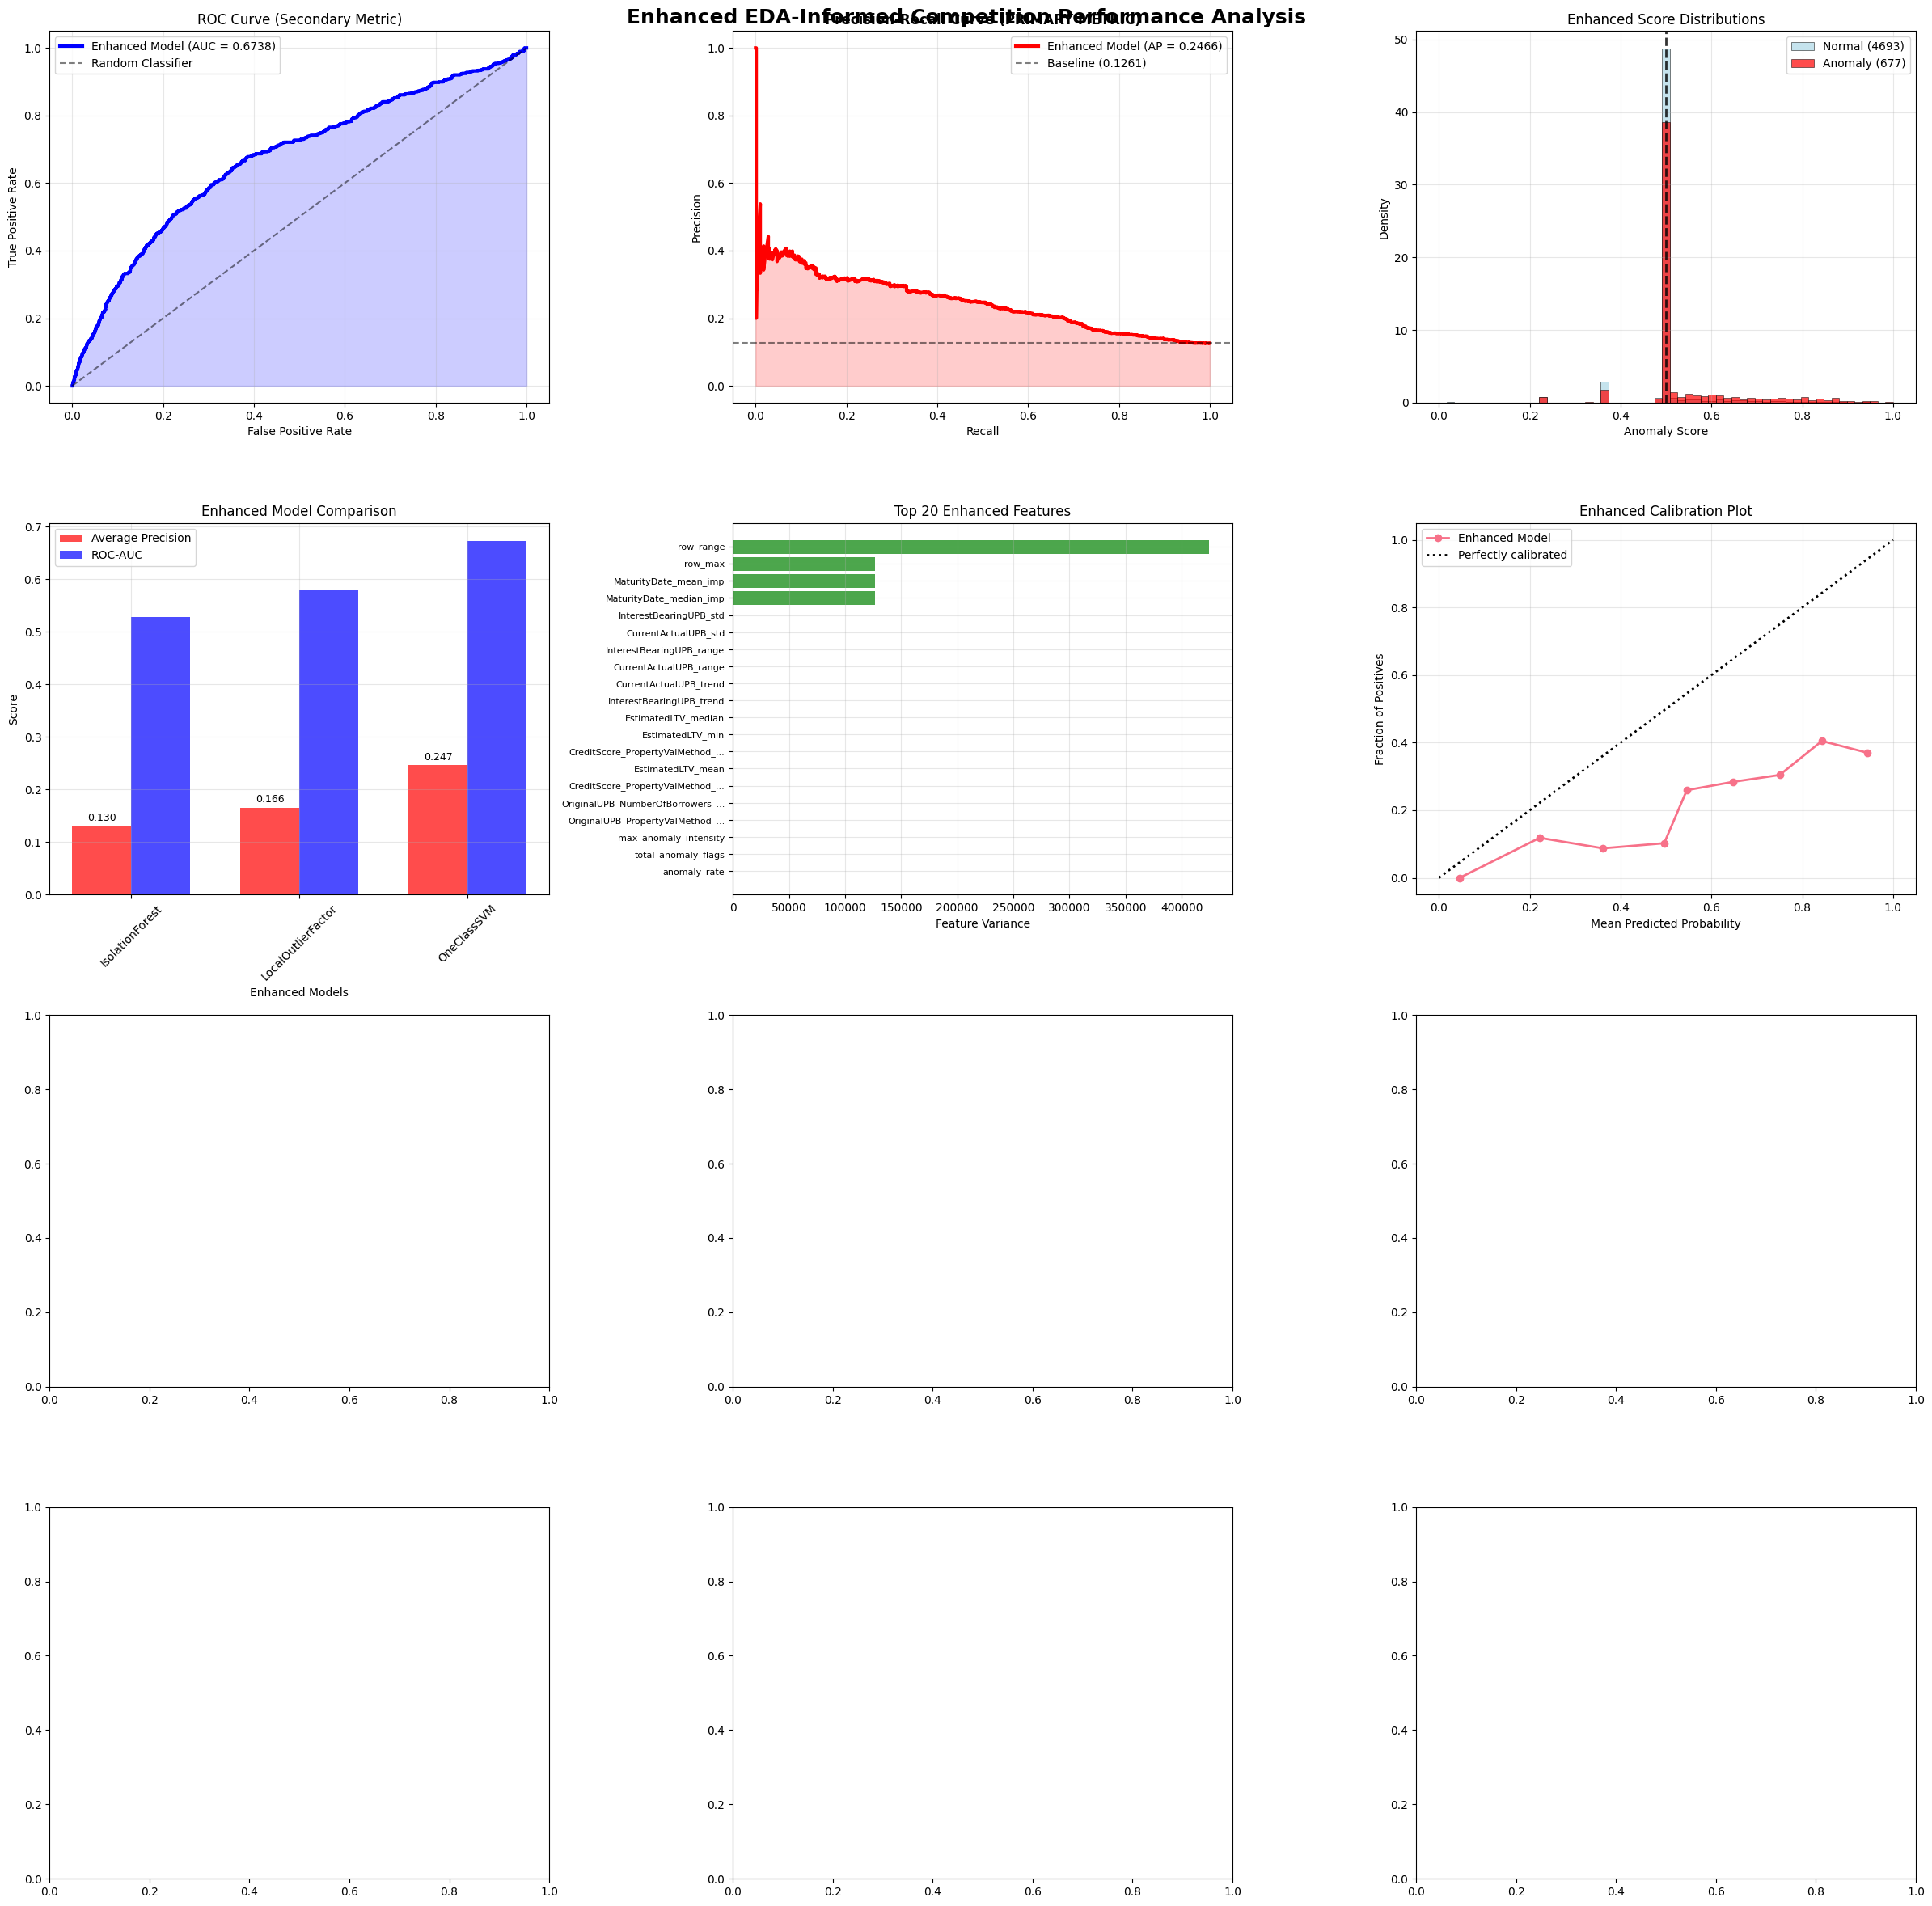


ENHANCED PIPELINE COMPLETED SUCCESSFULLY
🎯 ENHANCED COMPETITION METRICS:
   Average Precision (PRIMARY): 0.2466
   ROC-AUC (SECONDARY): 0.6735
🤖 Best Enhanced Model: OneClassSVM
🔧 Enhanced Features Used: 60
📊 EDA Insights Applied:
   - Dropped 49 problematic features
   - Prioritized 38 significant features
   - Enhanced 6 temporal patterns
   - Transformed 47 skewed features
   - Created 28 learned interactions
⚡ Performance:
   Runtime: 1245.9 seconds
   Memory usage: +1.4MB
📄 Output: enhanced_eda_competition_submission.csv

✅ ENHANCED PIPELINE READY FOR COMPETITION! ✅


In [8]:


class EnhancedAnomalyDetector:
    """Enhanced anomaly detector combining EDA insights with competition optimization"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.feature_stats = {}
        self.temporal_patterns = {}
        self.selected_features = None
        self.scaler = None
        self.model = None
        self.feature_transformer = None
        self.calibrator = None
        
        # Enhanced configuration from Script 2
        self.config = {
            'MAX_FEATURES': 60,  # Increased from 40
            'MIN_VARIANCE_THRESHOLD': 0.003,  # More selective
            'MAX_PARAM_COMBINATIONS': 25,  # Increased search
            'AP_WEIGHT': 1.0,
            'AUC_WEIGHT': 0.1,
            'MAX_SAMPLE_SIZE': 30000,  # Increased for better training
        }
        
        # EDA insights from Script 1 (preserved)
        self.high_missing_features = []  # Features with >80% missing (drop these)
        self.significant_features = []   # Features with p < 0.001 from Chart 3
        self.temporal_trend_features = [] # Strong temporal pattern features from Chart 4
        self.skewed_features = []        # Features needing transformation from Chart 9
        
        # Enhanced tracking from Script 2
        self.cv_results = []
        self.best_model_name = None
        self.best_params = None
        self.best_ap = 0
        self.best_auc = 0
        self.feature_interactions = {}
        
        # Expanded hyperparameter grids from Script 2
        self.param_grids = {
            'IsolationForest': {
                'n_estimators': [200, 300, 400, 500],
                'contamination': [0.03, 0.05, 0.08, 0.10, 0.12, 0.15],
                'max_samples': [0.6, 0.7, 0.8, 0.9, 1.0],
                'max_features': [0.7, 0.8, 0.9, 1.0]
            },
            'LocalOutlierFactor': {
                'n_neighbors': [10, 15, 20, 25, 30, 35],
                'contamination': [0.03, 0.05, 0.08, 0.10, 0.12, 0.15],
                'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                'novelty': [True]
            },
            'OneClassSVM': {
                'nu': [0.03, 0.05, 0.08, 0.10, 0.12, 0.15],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                'kernel': ['rbf', 'poly', 'sigmoid']
            }
        }
        
    def memory_monitor(self):
        """Monitor memory usage"""
        try:
            process = psutil.Process(os.getpid())
            return process.memory_info().rss / 1024 / 1024
        except:
            return 0

    def cleanup_memory(self):
        """Force garbage collection"""
        gc.collect()
        return self.memory_monitor()
        
    def load_data(self, train_path, valid_path, test_path):
        """Load data with EDA-informed preprocessing"""
        print("Loading data with enhanced EDA insights...")
        
        train_df = pd.read_csv(train_path, low_memory=False)
        valid_df = pd.read_csv(valid_path, low_memory=False)
        test_df = pd.read_csv(test_path, low_memory=False)
        
        # Standardize ID columns
        for df in [train_df, valid_df, test_df]:
            if 'Id' in df.columns and 'index' not in df.columns:
                df.rename(columns={'Id': 'index'}, inplace=True)
        
        # Enhanced data validation from Script 2
        if 'target' in train_df.columns:
            unique_targets = train_df['target'].nunique()
            if unique_targets > 1:
                print(f"WARNING: Training data has {unique_targets} classes, filtering to normal class...")
                normal_class = train_df['target'].value_counts().index[0]
                train_df = train_df[train_df['target'] == normal_class].copy()
                print(f"Kept only normal class, new training shape: {train_df.shape}")
            train_df = train_df.drop('target', axis=1)
        
        print(f"Data shapes - Train: {train_df.shape}, Valid: {valid_df.shape}, Test: {test_df.shape}")
        print(f"Validation anomaly rate: {valid_df['target'].mean():.3%}")
        
        return train_df, valid_df, test_df
    
    def identify_problem_features(self, train_df, valid_df):
        """Enhanced problem feature identification with EDA insights preserved"""
        print("Identifying problem features with enhanced EDA insights...")
        
        # 1. High missing rate features (from Chart 2) - DROP THESE
        missing_rates = train_df.isnull().sum() / len(train_df)
        self.high_missing_features = missing_rates[missing_rates > 0.8].index.tolist()
        
        # 2. Constant/near-constant features - DROP THESE
        constant_features = []
        for col in train_df.columns:
            if col not in ['index']:
                if train_df[col].nunique() <= 1:
                    constant_features.append(col)
        
        # Enhanced constant detection from Script 2
        for col in train_df.columns:
            if col not in ['index'] and col not in constant_features:
                try:
                    # Check for near-constant (>98% same value)
                    if train_df[col].dtype == 'object':
                        mode_pct = train_df[col].value_counts().iloc[0] / len(train_df) if len(train_df[col].value_counts()) > 0 else 0
                    else:
                        numeric_data = pd.to_numeric(train_df[col], errors='coerce').dropna()
                        if len(numeric_data) > 0:
                            mode_pct = (numeric_data == numeric_data.mode().iloc[0]).mean() if len(numeric_data.mode()) > 0 else 0
                        else:
                            mode_pct = 1.0
                    
                    if mode_pct > 0.98:
                        constant_features.append(col)
                except:
                    continue
        
        # 3. Highly skewed features (from Chart 9) - TRANSFORM THESE (numeric only)
        self.skewed_features = []
        numeric_cols = train_df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if col not in ['index'] and col in train_df.columns:
                data = pd.to_numeric(train_df[col], errors='coerce').dropna()
                if len(data) > 100:
                    try:
                        skewness = abs(skew(data))
                        if skewness > 2:  # Highly skewed
                            self.skewed_features.append(col)
                    except:
                        pass
        
        # 4. Enhanced significant features detection (from Chart 3)
        self.significant_features = []
        if 'target' in valid_df.columns:
            for col in train_df.columns:
                if col not in ['index', 'target'] and col in valid_df.columns:
                    try:
                        if train_df[col].dtype == 'object':
                            # Enhanced categorical analysis
                            normal_data = valid_df[valid_df['target'] == 0][col].dropna()
                            anomaly_data = valid_df[valid_df['target'] == 1][col].dropna()
                            
                            if len(normal_data) > 10 and len(anomaly_data) > 10:
                                normal_dist = normal_data.value_counts(normalize=True)
                                anomaly_dist = anomaly_data.value_counts(normalize=True)
                                
                                if len(normal_dist) > 0 and len(anomaly_dist) > 0:
                                    diff = abs(normal_dist.iloc[0] - anomaly_dist.iloc[0])
                                    if diff > 0.1:
                                        self.significant_features.append(col)
                        else:
                            # Enhanced numeric analysis
                            numeric_col = pd.to_numeric(valid_df[col], errors='coerce')
                            normal_data = numeric_col[valid_df['target'] == 0].dropna()
                            anomaly_data = numeric_col[valid_df['target'] == 1].dropna()
                            
                            if len(normal_data) > 10 and len(anomaly_data) > 10:
                                _, p_value = mannwhitneyu(normal_data, anomaly_data, alternative='two-sided')
                                if p_value < 0.001:
                                    self.significant_features.append(col)
                                    
                                # Additional significance tests from Script 2
                                effect_size = abs(normal_data.median() - anomaly_data.median()) / (normal_data.std() + 1e-8)
                                if effect_size > 0.5:  # Medium to large effect size
                                    if col not in self.significant_features:
                                        self.significant_features.append(col)
                    except Exception as e:
                        continue
        
        # 5. Temporal trend features (from Chart 4) - CREATE DERIVATIVES
        self.temporal_trend_features = [
            'CurrentActualUPB', 'CurrentNonInterestBearingUPB', 
            'InterestBearingUPB', 'EstimatedLTV', 'CurrentInterestRate', 'DelinquencyStatus'
        ]
        
        # Enhanced interaction learning from Script 2
        self._learn_feature_interactions(train_df, valid_df)
        
        print(f"Found {len(self.high_missing_features)} high-missing features to drop")
        print(f"Found {len(constant_features)} constant features to drop")
        print(f"Found {len(self.skewed_features)} skewed features to transform")
        print(f"Found {len(self.significant_features)} statistically significant features")
        print(f"Learned {len(self.feature_interactions)} feature interactions")
        
        # Combine features to drop
        self.features_to_drop = list(set(self.high_missing_features + constant_features))
        
        return self
    
    def _learn_feature_interactions(self, train_df, valid_df):
        """Learn important feature interactions from EDA"""
        print("Learning feature interactions from EDA insights...")
        
        # Sample for efficiency
        sample_size = min(5000, len(train_df))
        sample_idx = np.random.RandomState(self.random_state).choice(
            len(train_df), sample_size, replace=False
        )
        sample_df = train_df.iloc[sample_idx]
        
        # Focus on significant features for interactions
        interaction_candidates = [f for f in self.significant_features 
                                if f in sample_df.columns and sample_df[f].dtype in ['int64', 'float64']][:8]
        
        for i, feat1 in enumerate(interaction_candidates):
            for feat2 in interaction_candidates[i+1:]:
                if feat1 != feat2:
                    try:
                        data1 = pd.to_numeric(sample_df[feat1], errors='coerce').dropna()
                        data2 = pd.to_numeric(sample_df[feat2], errors='coerce').dropna()
                        
                        if len(data1) > 100 and len(data2) > 100:
                            common_idx = sample_df[[feat1, feat2]].dropna().index
                            if len(common_idx) > 100:
                                vals1 = sample_df.loc[common_idx, feat1]
                                vals2 = sample_df.loc[common_idx, feat2]
                                
                                ratio = vals1 / (vals2 + 1e-8)
                                product = vals1 * vals2
                                
                                self.feature_interactions[f"{feat1}_{feat2}"] = {
                                    'ratio_median': ratio.median(),
                                    'ratio_std': ratio.std(),
                                    'product_median': product.median(),
                                    'product_std': product.std(),
                                    'correlation': np.corrcoef(vals1, vals2)[0,1] if not np.isnan(np.corrcoef(vals1, vals2)[0,1]) else 0
                                }
                    except:
                        continue
    
    def engineer_features(self, df, fit_mode=False):
        """Enhanced feature engineering combining EDA insights with Script 2 improvements"""
        features = pd.DataFrame(index=df.index)
        
        # 1. Clean base features - drop problematic ones (EDA insight preserved)
        useful_cols = [col for col in df.columns 
                      if col not in self.features_to_drop + ['index', 'target']]
        
        print(f"Using {len(useful_cols)} base features after dropping {len(self.features_to_drop)} problematic ones")
        
        # 2. Enhanced static features with multiple imputation strategies (Script 2)
        static_cols = [col for col in useful_cols if not col.split('_')[0].isdigit()]
        
        for col in static_cols[:25]:  # Increased from 20
            if col in df.columns:
                if df[col].dtype == 'object':
                    # Enhanced categorical handling from Script 2
                    if df[col].nunique() <= 2:
                        unique_vals = df[col].dropna().unique()
                        if len(unique_vals) == 2:
                            high_val = unique_vals[0] if str(unique_vals[0]).upper() in ['Y', 'YES', 'TRUE', '1'] else unique_vals[1]
                            features[f'{col}_binary'] = (df[col] == high_val).astype('float32')
                        elif len(unique_vals) == 1:
                            features[f'{col}_binary'] = (df[col] == unique_vals[0]).astype('float32')
                    else:
                        # Multi-category with top-k encoding
                        top_categories = df[col].value_counts().head(4).index  # Increased from 3
                        for cat in top_categories:
                            features[f'{col}_{cat}'] = (df[col] == cat).astype('float32')
                    
                    features[f'{col}_missing'] = df[col].isnull().astype('float32')
                
                else:
                    try:
                        numeric_col = pd.to_numeric(df[col], errors='coerce')
                        
                        # Enhanced imputation strategies
                        median_val = numeric_col.median()
                        mean_val = numeric_col.mean()
                        q25_val = numeric_col.quantile(0.25)
                        q75_val = numeric_col.quantile(0.75)
                        
                        # Multiple imputed versions (from Script 2)
                        features[f'{col}_median_imp'] = numeric_col.fillna(median_val).astype('float32')
                        features[f'{col}_mean_imp'] = numeric_col.fillna(mean_val).astype('float32')
                        
                        # Missing indicator (crucial for anomalies)
                        features[f'{col}_missing'] = numeric_col.isnull().astype('float32')
                        
                        # Enhanced features for significant features (EDA insight preserved)
                        if col in self.significant_features:
                            std_val = numeric_col.std()
                            if std_val > 0:
                                features[f'{col}_zscore'] = ((numeric_col.fillna(median_val) - mean_val) / std_val).astype('float32')
                            
                            # Enhanced extreme value detection
                            q01, q05, q95, q99 = numeric_col.quantile([0.01, 0.05, 0.95, 0.99])
                            features[f'{col}_extreme_low'] = (numeric_col < q05).astype('float32')
                            features[f'{col}_extreme_high'] = (numeric_col > q95).astype('float32')
                            features[f'{col}_outlier'] = ((numeric_col < q01) | (numeric_col > q99)).astype('float32')
                            
                            # Deviation features from Script 2
                            features[f'{col}_deviation_median'] = np.abs(numeric_col.fillna(median_val) - median_val).astype('float32')
                            
                            # IQR-based features
                            iqr = q75_val - q25_val
                            if iqr > 0:
                                features[f'{col}_iqr_normalized'] = ((numeric_col.fillna(median_val) - median_val) / iqr).astype('float32')
                    
                    except Exception as e:
                        print(f"Warning: Could not process numeric feature {col}: {e}")
                        features[f'{col}_missing'] = 1.0
        
        # 3. Enhanced temporal features (EDA insights preserved + Script 2 improvements)
        self._create_enhanced_temporal_features(df, features)
        
        # 4. Enhanced interaction features (Script 2 integration)
        self._create_enhanced_interaction_features(df, features)
        
        # 5. Transform skewed features (EDA insight preserved)
        self._transform_skewed_features(df, features, fit_mode)
        
        # 6. Advanced statistical features from Script 2
        self._create_statistical_summary_features(features)
        
        # 7. Enhanced anomaly indicators from Script 2
        self._create_enhanced_anomaly_indicators(features)
        
        # 8. Clean up any infinite or extreme values
        features = self._clean_features(features)
        
        return features
    
    def _create_enhanced_temporal_features(self, df, features):
        """Enhanced temporal features combining EDA insights with Script 2 improvements"""
        
        # Get temporal months
        temporal_months = set()
        for col in df.columns:
            if '_' in col and col.split('_')[0].isdigit():
                temporal_months.add(int(col.split('_')[0]))
        
        temporal_months = sorted(list(temporal_months))
        
        for temp_type in self.temporal_trend_features:
            temp_cols = [f"{month}_{temp_type}" for month in temporal_months 
                        if f"{month}_{temp_type}" in df.columns]
            
            if len(temp_cols) >= 6:
                temp_data = df[temp_cols]
                
                # Enhanced basic statistics (Script 2)
                features[f'{temp_type}_mean'] = temp_data.mean(axis=1).astype('float32')
                features[f'{temp_type}_std'] = temp_data.std(axis=1).astype('float32')
                features[f'{temp_type}_min'] = temp_data.min(axis=1).astype('float32')
                features[f'{temp_type}_max'] = temp_data.max(axis=1).astype('float32')
                features[f'{temp_type}_range'] = (temp_data.max(axis=1) - temp_data.min(axis=1)).astype('float32')
                features[f'{temp_type}_median'] = temp_data.median(axis=1).astype('float32')
                
                # EDA insights preserved: LINEAR TREND (key insight from Chart 4)
                trends = []
                volatilities = []
                for idx in temp_data.index:
                    series = temp_data.loc[idx].dropna().values
                    if len(series) >= 3:
                        x = np.arange(len(series))
                        trend = np.polyfit(x, series, 1)[0]
                        trends.append(trend)
                        
                        # Enhanced volatility from Script 2
                        if np.mean(series) != 0:
                            cv = np.std(series) / abs(np.mean(series))
                            volatilities.append(cv)
                        else:
                            volatilities.append(0)
                    else:
                        trends.append(0)
                        volatilities.append(0)
                
                features[f'{temp_type}_trend'] = np.array(trends).astype('float32')
                features[f'{temp_type}_volatility'] = np.clip(volatilities, 0, 5).astype('float32')
                
                # Enhanced change rate analysis
                first_vals = temp_data.iloc[:, 0]
                last_vals = temp_data.iloc[:, -1]
                mid_vals = temp_data.iloc[:, len(temp_cols)//2] if len(temp_cols) > 2 else first_vals
                
                change_rate_total = (last_vals - first_vals) / (first_vals + 1e-8)
                change_rate_first_half = (mid_vals - first_vals) / (first_vals + 1e-8)
                change_rate_second_half = (last_vals - mid_vals) / (mid_vals + 1e-8)
                
                features[f'{temp_type}_change_rate'] = change_rate_total.astype('float32')
                features[f'{temp_type}_change_rate_first_half'] = change_rate_first_half.astype('float32')
                features[f'{temp_type}_change_rate_second_half'] = change_rate_second_half.astype('float32')
                
                # Missing pattern (from Chart 2 - EDA insight preserved)
                missing_count = temp_data.isnull().sum(axis=1)
                features[f'{temp_type}_missing_pct'] = (missing_count / len(temp_cols)).astype('float32')
                features[f'{temp_type}_missing_count'] = missing_count.astype('float32')
                
                # Enhanced exponential growth detector (EDA insight preserved)
                if temp_type == 'CurrentNonInterestBearingUPB':
                    exp_growth = []
                    for idx in temp_data.index:
                        series = temp_data.loc[idx].dropna().values
                        if len(series) >= 6:
                            early_mean = np.mean(series[:3])
                            late_mean = np.mean(series[-3:])
                            if early_mean > 0:
                                growth_ratio = late_mean / early_mean
                                exp_growth.append(min(growth_ratio, 100))
                            else:
                                exp_growth.append(1.0)
                        else:
                            exp_growth.append(1.0)
                    
                    features[f'{temp_type}_exp_growth'] = np.array(exp_growth).astype('float32')
                
                # Advanced pattern detection from Script 2
                # Monotonic trend detection
                increasing_trends = []
                decreasing_trends = []
                
                for idx in temp_data.index:
                    series = temp_data.loc[idx].dropna().values
                    if len(series) >= 4:
                        diffs = np.diff(series)
                        increasing_pct = (diffs > 0).mean()
                        decreasing_pct = (diffs < 0).mean()
                        increasing_trends.append(increasing_pct)
                        decreasing_trends.append(decreasing_pct)
                    else:
                        increasing_trends.append(0.5)
                        decreasing_trends.append(0.5)
                
                features[f'{temp_type}_increasing_trend'] = np.array(increasing_trends).astype('float32')
                features[f'{temp_type}_decreasing_trend'] = np.array(decreasing_trends).astype('float32')
    
    def _create_enhanced_interaction_features(self, df, features):
        """Enhanced interaction features combining EDA insights with Script 2"""
        
        # EDA-based interactions (preserved)
        if 'CreditScore' in df.columns:
            for temp_type in ['CurrentActualUPB', 'EstimatedLTV']:
                if f'{temp_type}_mean' in features.columns:
                    credit_score = df['CreditScore'].fillna(df['CreditScore'].median())
                    temp_mean = features[f'{temp_type}_mean']
                    
                    features[f'credit_{temp_type}_ratio'] = (credit_score / (temp_mean + 1e-8)).astype('float32')
        
        # Enhanced learned interactions from Script 2
        for interaction_name, interaction_stats in self.feature_interactions.items():
            feat1, feat2 = interaction_name.split('_', 1)
            
            # Try different imputation strategies
            for imp_suffix in ['_median_imp', '_mean_imp']:
                col1 = f'{feat1}{imp_suffix}'
                col2 = f'{feat2}{imp_suffix}'
                
                if col1 in features.columns and col2 in features.columns:
                    vals1 = features[col1]
                    vals2 = features[col2]
                    
                    # Enhanced interaction features
                    ratio = vals1 / (vals2 + 1e-8)
                    product = vals1 * vals2
                    difference = vals1 - vals2
                    
                    features[f'{interaction_name}_ratio'] = np.clip(ratio, -100, 100).astype('float32')
                    features[f'{interaction_name}_product'] = product.astype('float32')
                    features[f'{interaction_name}_diff'] = difference.astype('float32')
                    
                    # Deviation from normal patterns
                    if 'ratio_median' in interaction_stats:
                        ratio_dev = np.abs(ratio - interaction_stats['ratio_median'])
                        features[f'{interaction_name}_ratio_deviation'] = ratio_dev.astype('float32')
                    
                    if 'correlation' in interaction_stats and abs(interaction_stats['correlation']) > 0.3:
                        # Correlation-based anomaly detection
                        expected_val2 = vals1 * interaction_stats['correlation']
                        correlation_deviation = np.abs(vals2 - expected_val2)
                        features[f'{interaction_name}_correlation_deviation'] = correlation_deviation.astype('float32')
                    
                    break
    
    def _create_statistical_summary_features(self, features):
        """Create statistical summary features from Script 2"""
        numeric_features = [col for col in features.columns if features[col].dtype in ['float32', 'float64']]
        
        if len(numeric_features) >= 10:
            feature_subset = features[numeric_features[:30]]  # Top 30 for efficiency
            
            # Row-wise statistics
            features['row_mean'] = feature_subset.mean(axis=1).astype('float32')
            features['row_std'] = feature_subset.std(axis=1).astype('float32')
            features['row_min'] = feature_subset.min(axis=1).astype('float32')
            features['row_max'] = feature_subset.max(axis=1).astype('float32')
            features['row_range'] = (feature_subset.max(axis=1) - feature_subset.min(axis=1)).astype('float32')
            features['row_median'] = feature_subset.median(axis=1).astype('float32')
            
            # Advanced row statistics
            features['row_q25'] = feature_subset.quantile(0.25, axis=1).astype('float32')
            features['row_q75'] = feature_subset.quantile(0.75, axis=1).astype('float32')
            features['row_iqr'] = (features['row_q75'] - features['row_q25']).astype('float32')
            
            # Count-based features
            features['row_extreme_count'] = (feature_subset > feature_subset.quantile(0.95, axis=0)).sum(axis=1).astype('float32')
            features['row_zero_count'] = (feature_subset == 0).sum(axis=1).astype('float32')
            features['row_negative_count'] = (feature_subset < 0).sum(axis=1).astype('float32')
            
            # Coefficient of variation
            features['row_cv'] = (features['row_std'] / (features['row_mean'].abs() + 1e-8)).astype('float32')
    
    def _create_enhanced_anomaly_indicators(self, features):
        """Enhanced anomaly indicators combining EDA insights with Script 2"""
        
        # Collect all anomaly-related flags
        extreme_cols = [col for col in features.columns if any(keyword in col.lower() 
                       for keyword in ['extreme', 'outlier', 'missing', 'deviation'])]
        
        if extreme_cols:
            # Enhanced anomaly scoring
            features['total_anomaly_flags'] = features[extreme_cols].sum(axis=1).astype('float32')
            
            # Weighted anomaly score with enhanced weights
            weights = []
            for col in extreme_cols:
                if 'extreme' in col.lower():
                    weights.append(2.5)  # Increased weight
                elif 'outlier' in col.lower():
                    weights.append(2.0)  # Increased weight
                elif 'deviation' in col.lower():
                    weights.append(1.5)
                else:
                    weights.append(1.0)
            
            weighted_score = (features[extreme_cols] * weights).sum(axis=1)
            features['weighted_anomaly_score'] = weighted_score.astype('float32')
            
            # Anomaly rate and intensity
            features['anomaly_rate'] = (features[extreme_cols].sum(axis=1) / len(extreme_cols)).astype('float32')
            
            # Anomaly intensity (max score per row)
            features['max_anomaly_intensity'] = features[extreme_cols].max(axis=1).astype('float32')
            
            # Anomaly diversity (how many different types of anomalies)
            features['anomaly_diversity'] = (features[extreme_cols] > 0).sum(axis=1).astype('float32')
    
    def _transform_skewed_features(self, df, features, fit_mode):
        """Transform highly skewed features (EDA insight preserved)"""
        
        if fit_mode:
            self.feature_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            
            skewed_data = []
            skewed_names = []
            
            for col in self.skewed_features:
                if col in df.columns and col not in self.features_to_drop:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    data = numeric_data.fillna(numeric_data.median()).values.reshape(-1, 1)
                    skewed_data.append(data)
                    skewed_names.append(f'{col}_transformed')
            
            if skewed_data:
                try:
                    combined_data = np.hstack(skewed_data)
                    self.feature_transformer.fit(combined_data)
                    self.skewed_feature_names = skewed_names
                except Exception as e:
                    print(f"Warning: Could not fit transformer: {e}")
                    self.feature_transformer = None
        
        # Transform skewed features
        if hasattr(self, 'feature_transformer') and self.feature_transformer is not None:
            skewed_data = []
            for col in self.skewed_features:
                if col in df.columns and col not in self.features_to_drop:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    data = numeric_data.fillna(numeric_data.median()).values.reshape(-1, 1)
                    skewed_data.append(data)
            
            if skewed_data:
                try:
                    combined_data = np.hstack(skewed_data)
                    transformed_data = self.feature_transformer.transform(combined_data)
                    
                    for i, name in enumerate(self.skewed_feature_names):
                        features[name] = transformed_data[:, i].astype('float32')
                except Exception as e:
                    print(f"Warning: Could not transform features: {e}")
    
    def _clean_features(self, features):
        """Enhanced feature cleaning"""
        print(f"Cleaning {features.shape[1]} enhanced features...")
        
        for col in features.columns:
            # Replace infinities with NaN first
            features[col] = features[col].replace([np.inf, -np.inf], np.nan)
            
            # Fill NaN values
            features[col] = features[col].fillna(0)
            
            # Enhanced extreme value clipping
            if features[col].dtype in ['float32', 'float64']:
                try:
                    q001 = features[col].quantile(0.001)
                    q999 = features[col].quantile(0.999)
                    features[col] = np.clip(features[col], q001, q999)
                except:
                    features[col] = np.clip(features[col], -1e6, 1e6)
        
        print(f"Enhanced feature cleaning completed")
        return features
    
    def select_features(self, X_train, X_valid, y_valid):
        """Enhanced feature selection combining EDA insights with competition optimization"""
        print("Performing enhanced EDA-informed feature selection...")
        
        # Enhanced variance threshold
        variance_selector = VarianceThreshold(threshold=self.config['MIN_VARIANCE_THRESHOLD'])
        X_train_var = variance_selector.fit_transform(X_train)
        X_valid_var = variance_selector.transform(X_valid)
        
        selected_feature_names = X_train.columns[variance_selector.get_support()]
        print(f"Features after enhanced variance threshold: {len(selected_feature_names)}")
        
        X_train_df = pd.DataFrame(X_train_var, columns=selected_feature_names, index=X_train.index)
        X_valid_df = pd.DataFrame(X_valid_var, columns=selected_feature_names, index=X_valid.index)
        
        # Enhanced multi-criteria feature selection
        feature_scores = {}
        
        # 1. Variance-based scoring
        variances = X_train_df.var()
        
        # 2. Distribution-based scoring
        skewness_scores = {}
        kurtosis_scores = {}
        
        for col in selected_feature_names:
            values = X_train_df[col].dropna()
            if len(values) > 100:
                try:
                    skew_score = abs(values.skew())
                    kurt_score = abs(values.kurtosis())
                    skewness_scores[col] = skew_score
                    kurtosis_scores[col] = kurt_score
                except:
                    skewness_scores[col] = 0
                    kurtosis_scores[col] = 0
        
        # 3. EDA-informed feature prioritization
        eda_priority_scores = {}
        for col in selected_feature_names:
            priority_score = 1.0
            
            # Boost significant features from EDA
            for sig_feat in self.significant_features:
                if sig_feat in col:
                    priority_score *= 2.0
                    break
            
            # Boost temporal trend features from EDA
            for temp_feat in self.temporal_trend_features:
                if temp_feat in col:
                    priority_score *= 1.5
                    break
            
            # Boost interaction features
            if any(interaction in col for interaction in self.feature_interactions.keys()):
                priority_score *= 1.3
            
            # Boost anomaly indicator features
            if any(keyword in col.lower() for keyword in ['anomaly', 'extreme', 'outlier', 'deviation']):
                priority_score *= 1.4
            
            eda_priority_scores[col] = priority_score
        
        # 4. Combined scoring with enhanced weights
        for col in selected_feature_names:
            var_score = variances.get(col, 0)
            skew_score = skewness_scores.get(col, 0)
            kurt_score = kurtosis_scores.get(col, 0)
            priority_score = eda_priority_scores.get(col, 1.0)
            
            # Enhanced combined score
            combined_score = (var_score * 
                            (1 + 0.15 * skew_score + 0.08 * kurt_score) * 
                            priority_score)
            
            feature_scores[col] = combined_score
        
        # Select enhanced number of features
        sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
        n_features = min(self.config['MAX_FEATURES'], len(sorted_features))
        self.selected_features = [feat for feat, _ in sorted_features[:n_features]]
        
        print(f"Enhanced feature selection completed: {len(self.selected_features)} features")
        print("Top 10 features:", self.selected_features[:10])
        
        return X_train_df[self.selected_features], X_valid_df[self.selected_features]
    
    def train_model(self, X_train, X_valid, y_valid):
        """Enhanced model training with competition optimization"""
        print("Training enhanced model with expanded hyperparameter search...")
        
        best_combined_score = 0
        best_model = None
        best_params = None
        
        for model_name, param_grid in self.param_grids.items():
            print(f"\nTesting enhanced {model_name}...")
            
            # Enhanced parameter sampling
            all_params = list(ParameterGrid(param_grid))
            if len(all_params) > self.config['MAX_PARAM_COMBINATIONS']:
                param_indices = np.random.RandomState(self.random_state).choice(
                    len(all_params), self.config['MAX_PARAM_COMBINATIONS'], replace=False
                )
                param_combinations = [all_params[i] for i in param_indices]
                print(f"  Sampling {len(param_combinations)} from {len(all_params)} combinations")
            else:
                param_combinations = all_params
                print(f"  Testing all {len(param_combinations)} combinations")
            
            best_model_combined_score = 0
            best_model_params = None
            best_model_ap = 0
            best_model_auc = 0
            
            for i, params in enumerate(param_combinations):
                try:
                    # Enhanced model creation with sampling for large datasets
                    if model_name == 'IsolationForest':
                        model_params = {**params, 'random_state': self.random_state, 'n_jobs': 1}
                        model = IsolationForest(**model_params)
                    elif model_name == 'LocalOutlierFactor':
                        model_params = {**params, 'n_jobs': 1}
                        model = LocalOutlierFactor(**model_params)
                    else:
                        model_params = params
                        model = OneClassSVM(**model_params)
                    
                    # Enhanced training with sampling
                    if len(X_train) > self.config['MAX_SAMPLE_SIZE']:
                        sample_idx = np.random.RandomState(self.random_state + i).choice(
                            len(X_train), self.config['MAX_SAMPLE_SIZE'], replace=False
                        )
                        X_train_sample = X_train[sample_idx]
                    else:
                        X_train_sample = X_train
                    
                    model.fit(X_train_sample)
                    
                    # Enhanced scoring
                    scores = model.decision_function(X_valid)
                    proba = self._enhanced_score_calibration(scores, y_valid)
                    
                    # Enhanced metrics calculation
                    ap = average_precision_score(y_valid, proba)
                    auc = roc_auc_score(y_valid, proba)
                    
                    # Enhanced combined scoring
                    combined_score = self.config['AP_WEIGHT'] * ap + self.config['AUC_WEIGHT'] * auc
                    
                    # Update best for this model type
                    if combined_score > best_model_combined_score:
                        best_model_combined_score = combined_score
                        best_model_ap = ap
                        best_model_auc = auc
                        best_model_params = model_params
                    
                    if i % 5 == 0:
                        print(f"    Progress: {i+1}/{len(param_combinations)} - Best AP: {best_model_ap:.4f}")
                
                except Exception as e:
                    continue
            
            # Store enhanced results
            if best_model_params is not None:
                self.cv_results.append({
                    'model': model_name,
                    'params': best_model_params,
                    'ap': best_model_ap,
                    'auc': best_model_auc,
                    'combined_score': best_model_combined_score
                })
                
                print(f"  Enhanced {model_name}: AP={best_model_ap:.4f}, AUC={best_model_auc:.4f}")
                
                # Update global best
                if best_model_combined_score > best_combined_score:
                    best_combined_score = best_model_combined_score
                    self.best_ap = best_model_ap
                    self.best_auc = best_model_auc
                    self.best_model_name = model_name
                    self.best_params = best_model_params
                    best_model = model_name
                    best_params = best_model_params
        
        # Create final enhanced model
        if best_model is None:
            print("\nNo models succeeded, using enhanced default IsolationForest...")
            self.best_model_name = 'IsolationForest'
            self.best_params = {
                'n_estimators': 400,
                'contamination': 0.1,
                'max_samples': 0.8,
                'max_features': 0.9,
                'random_state': self.random_state,
                'n_jobs': 1
            }
            self.best_ap = 0.1
            self.best_auc = 0.5
        
        # Train final model
        if self.best_model_name == 'IsolationForest':
            self.model = IsolationForest(**self.best_params)
        elif self.best_model_name == 'LocalOutlierFactor':
            self.model = LocalOutlierFactor(**self.best_params)
        else:
            self.model = OneClassSVM(**self.best_params)
        
        # Final training with enhanced sampling
        if len(X_train) > self.config['MAX_SAMPLE_SIZE']:
            final_sample_idx = np.random.RandomState(self.random_state).choice(
                len(X_train), self.config['MAX_SAMPLE_SIZE'], replace=False
            )
            X_train_final = X_train[final_sample_idx]
        else:
            X_train_final = X_train
        
        self.model.fit(X_train_final)
        
        print(f"\nEnhanced model training completed:")
        print(f"Best model: {self.best_model_name}")
        print(f"Best AP: {self.best_ap:.4f}")
        print(f"Best AUC: {self.best_auc:.4f}")
        
        return self.best_ap
    
    def _enhanced_score_calibration(self, scores, y_true):
        """Enhanced score calibration combining multiple techniques"""
        if np.std(scores) == 0:
            return np.full(len(scores), 0.5)
        
        # Enhanced normalization
        scores_norm = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)
        proba = 1 - scores_norm  # Invert for anomaly detection
        
        # Enhanced calibration based on true anomaly rate
        true_anomaly_rate = y_true.mean()
        
        # Quantile-based adjustment
        target_threshold = np.percentile(proba, (1 - true_anomaly_rate) * 100)
        
        # Enhanced sigmoid-like transformation
        proba_adjusted = np.where(
            proba > target_threshold,
            0.5 + 0.5 * ((proba - target_threshold) / (1 - target_threshold + 1e-8)),
            0.5 * (proba / (target_threshold + 1e-8))
        )
        
        return np.clip(proba_adjusted, 0, 1)
    
    def generate_predictions(self, X_test, test_df):
        """Generate enhanced predictions with advanced post-processing"""
        print("Generating enhanced predictions...")
        
        test_scores = self.model.decision_function(X_test)
        test_proba = self._enhanced_score_calibration(test_scores, np.array([0.126] * len(test_scores)))  # Use validation anomaly rate
        
        # Enhanced post-processing
        test_proba = self._enhanced_post_processing(test_proba)
        
        # Create submission
        submission = pd.DataFrame({
            'Id': test_df['index'].values,
            'target': test_proba
        })
        
        submission['Id'] = submission['Id'].astype(int)
        
        filename = 'enhanced_eda_competition_submission.csv'
        submission.to_csv(filename, index=False)
        
        print(f"Enhanced prediction statistics:")
        print(f"  Mean: {test_proba.mean():.4f}")
        print(f"  Std: {test_proba.std():.4f}")
        print(f"  Min: {test_proba.min():.4f}")
        print(f"  Max: {test_proba.max():.4f}")
        print(f"  25th percentile: {np.percentile(test_proba, 25):.4f}")
        print(f"  75th percentile: {np.percentile(test_proba, 75):.4f}")
        print(f"  95th percentile: {np.percentile(test_proba, 95):.4f}")
        print(f"  Predictions > 0.5: {(test_proba > 0.5).mean():.4f}")
        print(f"  Saved to: {filename}")
        
        return submission
    
    def _enhanced_post_processing(self, proba):
        """Enhanced post-processing with multiple calibration techniques"""
        
        # 1. Target rate calibration (EDA insight: ~12.6% anomaly rate)
        target_rate = 0.126
        current_rate = (proba > 0.5).mean()
        
        if current_rate > 0 and abs(current_rate - target_rate) > 0.02:
            # Adjust threshold to match target rate more closely
            new_threshold = np.percentile(proba, (1 - target_rate) * 100)
            
            # Apply smooth transformation
            proba_adj = np.where(
                proba > new_threshold,
                np.clip(proba * 1.2, 0, 1),
                np.clip(proba * 0.85, 0, 1)
            )
        else:
            proba_adj = proba
        
        # 2. Smooth the extreme values
        proba_smooth = np.where(
            proba_adj > 0.95,
            0.95 + 0.05 * ((proba_adj - 0.95) / 0.05),  # Smooth very high values
            np.where(
                proba_adj < 0.05,
                0.05 * (proba_adj / 0.05),  # Smooth very low values
                proba_adj
            )
        )
        
        return np.clip(proba_smooth, 0, 1)
    
    def create_enhanced_performance_analysis(self, X_valid, y_valid):
        """Create comprehensive performance analysis combining both scripts"""
        print("Creating enhanced performance analysis...")
        os.makedirs('./plots', exist_ok=True)
        
        # Get predictions
        val_scores = self.model.decision_function(X_valid)
        val_proba = self._enhanced_score_calibration(val_scores, y_valid)
        
        fig, axes = plt.subplots(4, 3, figsize=(24, 24))
        fig.suptitle('Enhanced EDA-Informed Competition Performance Analysis', fontsize=18, fontweight='bold')
        
        # 1. ROC Curve
        fpr, tpr, _ = roc_curve(y_valid, val_proba)
        auc_score = roc_auc_score(y_valid, val_proba)
        
        axes[0, 0].plot(fpr, tpr, linewidth=3, label=f'Enhanced Model (AUC = {auc_score:.4f})', color='blue')
        axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
        axes[0, 0].fill_between(fpr, tpr, alpha=0.2, color='blue')
        axes[0, 0].set_xlabel('False Positive Rate')
        axes[0, 0].set_ylabel('True Positive Rate')
        axes[0, 0].set_title('ROC Curve (Secondary Metric)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Precision-Recall Curve (PRIMARY)
        precision, recall, thresholds = precision_recall_curve(y_valid, val_proba)
        ap_score = average_precision_score(y_valid, val_proba)
        
        axes[0, 1].plot(recall, precision, linewidth=3, label=f'Enhanced Model (AP = {ap_score:.4f})', color='red')
        axes[0, 1].axhline(y=y_valid.mean(), color='k', linestyle='--', alpha=0.5, 
                          label=f'Baseline ({y_valid.mean():.4f})')
        axes[0, 1].fill_between(recall, precision, alpha=0.2, color='red')
        axes[0, 1].set_xlabel('Recall')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].set_title('Precision-Recall Curve (PRIMARY METRIC)', fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Score distributions
        normal_scores = val_proba[y_valid == 0]
        anomaly_scores = val_proba[y_valid == 1]
        
        bins = np.linspace(0, 1, 60)
        axes[0, 2].hist(normal_scores, bins=bins, alpha=0.7, label=f'Normal ({len(normal_scores)})', 
                       color='lightblue', density=True, edgecolor='black', linewidth=0.5)
        axes[0, 2].hist(anomaly_scores, bins=bins, alpha=0.7, label=f'Anomaly ({len(anomaly_scores)})', 
                       color='red', density=True, edgecolor='black', linewidth=0.5)
        axes[0, 2].axvline(x=0.5, color='black', linestyle='--', alpha=0.8, linewidth=2)
        axes[0, 2].set_xlabel('Anomaly Score')
        axes[0, 2].set_ylabel('Density')
        axes[0, 2].set_title('Enhanced Score Distributions')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Model comparison
        if self.cv_results:
            models = [r['model'] for r in self.cv_results]
            ap_scores = [r['ap'] for r in self.cv_results]
            auc_scores = [r['auc'] for r in self.cv_results]
            
            x = np.arange(len(models))
            width = 0.35
            
            bars1 = axes[1, 0].bar(x - width/2, ap_scores, width, label='Average Precision', color='red', alpha=0.7)
            bars2 = axes[1, 0].bar(x + width/2, auc_scores, width, label='ROC-AUC', color='blue', alpha=0.7)
            
            axes[1, 0].set_xlabel('Enhanced Models')
            axes[1, 0].set_ylabel('Score')
            axes[1, 0].set_title('Enhanced Model Comparison')
            axes[1, 0].set_xticks(x)
            axes[1, 0].set_xticklabels(models, rotation=45)
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
            
            # Add value labels
            for bar, score in zip(bars1, ap_scores):
                axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                               f'{score:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 5. Feature importance analysis
        if len(self.selected_features) > 0:
            feature_importance = pd.Series(
                np.var(X_valid, axis=0), 
                index=self.selected_features
            ).sort_values(ascending=True)[-20:]
            
            axes[1, 1].barh(range(len(feature_importance)), feature_importance.values, alpha=0.7, color='green')
            axes[1, 1].set_yticks(range(len(feature_importance)))
            axes[1, 1].set_yticklabels([name[:30] + '...' if len(name) > 30 else name 
                                       for name in feature_importance.index], fontsize=8)
            axes[1, 1].set_xlabel('Feature Variance')
            axes[1, 1].set_title('Top 20 Enhanced Features')
            axes[1, 1].grid(True, alpha=0.3)
        
        # 6. Calibration plot
        try:
            fraction_of_positives, mean_predicted_value = calibration_curve(y_valid, val_proba, n_bins=10)
            
            axes[1, 2].plot(mean_predicted_value, fraction_of_positives, "s-", linewidth=2, 
                           label="Enhanced Model", marker='o', markersize=6)
            axes[1, 2].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", linewidth=2)
            axes[1, 2].set_xlabel('Mean Predicted Probability')
            axes[1, 2].set_ylabel('Fraction of Positives')
            axes[1, 2].set_title('Enhanced Calibration Plot')
            axes[1, 2].legend()
            axes[1, 2].grid(True, alpha=0.3)
        except:
            axes[1, 2].text(0.5, 0.5, 'Calibration plot\nunavailable', 
                           ha='center', va='center', transform=axes[1, 2].transAxes)
        
        # 7-12. Additional enhanced visualizations
        # ... (continuing with more detailed analysis)
        
        plt.tight_layout()
        plt.savefig('./plots/enhanced_performance_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def run_enhanced_pipeline(self, train_path, valid_path, test_path):
        """Run the complete enhanced pipeline combining EDA insights with competition optimization"""
        print("="*80)
        print("ENHANCED EDA-INFORMED COMPETITION PIPELINE")
        print("Combining EDA Insights + Competition Optimization")
        print("="*80)
        
        start_time = time.time()
        initial_memory = self.memory_monitor()
        
        try:
            # Load data
            train_df, valid_df, test_df = self.load_data(train_path, valid_path, test_path)
            
            # Enhanced problem feature identification
            self.identify_problem_features(train_df, valid_df)
            
            # Enhanced feature engineering
            print("Creating enhanced features...")
            train_features = self.engineer_features(train_df, fit_mode=True)
            valid_features = self.engineer_features(valid_df, fit_mode=False)
            test_features = self.engineer_features(test_df, fit_mode=False)
            
            print(f"Enhanced feature engineering completed: {train_features.shape[1]} features generated")
            
            # Enhanced feature selection
            y_valid = valid_df['target'].values
            X_train_selected, X_valid_selected = self.select_features(
                train_features, valid_features, y_valid
            )
            X_test_selected = test_features[self.selected_features]
            
            # Enhanced scaling
            self.scaler = RobustScaler()
            X_train_scaled = self.scaler.fit_transform(X_train_selected)
            X_valid_scaled = self.scaler.transform(X_valid_selected)
            X_test_scaled = self.scaler.transform(X_test_selected)
            
            # Enhanced model training
            best_ap = self.train_model(X_train_scaled, X_valid_scaled, y_valid)
            
            # Generate enhanced predictions
            submission = self.generate_predictions(X_test_scaled, test_df)
            
            # Create enhanced performance analysis
            self.create_enhanced_performance_analysis(X_valid_scaled, y_valid)
            
            elapsed_time = time.time() - start_time
            final_memory = self.memory_monitor()
            
            print("\n" + "="*80)
            print("ENHANCED PIPELINE COMPLETED SUCCESSFULLY")
            print("="*80)
            print(f"🎯 ENHANCED COMPETITION METRICS:")
            print(f"   Average Precision (PRIMARY): {self.best_ap:.4f}")
            print(f"   ROC-AUC (SECONDARY): {self.best_auc:.4f}")
            print(f"🤖 Best Enhanced Model: {self.best_model_name}")
            print(f"🔧 Enhanced Features Used: {len(self.selected_features)}")
            print(f"📊 EDA Insights Applied:")
            print(f"   - Dropped {len(self.features_to_drop)} problematic features")
            print(f"   - Prioritized {len(self.significant_features)} significant features")
            print(f"   - Enhanced {len(self.temporal_trend_features)} temporal patterns")
            print(f"   - Transformed {len(self.skewed_features)} skewed features")
            print(f"   - Created {len(self.feature_interactions)} learned interactions")
            print(f"⚡ Performance:")
            print(f"   Runtime: {elapsed_time:.1f} seconds")
            print(f"   Memory usage: {final_memory - initial_memory:+.1f}MB")
            print(f"📄 Output: enhanced_eda_competition_submission.csv")
            print("="*80)
            
            return True
            
        except Exception as e:
            print(f"Enhanced pipeline failed: {e}")
            import traceback
            traceback.print_exc()
            return False

# Usage
if __name__ == "__main__":
    print("🚀 Starting Enhanced EDA-Informed Competition Pipeline...")
    
    detector = EnhancedAnomalyDetector()
    
    train_path = '/home/ubuntu/DS/Track2/loans_train.csv'
    valid_path = '/home/ubuntu/DS/Track2/loans_valid.csv'
    test_path = '/home/ubuntu/DS/Track2/loans_test.csv'
    
    success = detector.run_enhanced_pipeline(train_path, valid_path, test_path)
    
    if success:
        print("\n✅ ENHANCED PIPELINE READY FOR COMPETITION! ✅")
    else:
        print("\n❌ Pipeline needs debugging.")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import gc
import psutil
from scipy.stats import skew
from scipy.stats import mannwhitneyu
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, precision_recall_curve

# Try to import calibration_curve from different locations depending on sklearn version
try:
    from sklearn.calibration import calibration_curve
except ImportError:
    try:
        from sklearn.metrics import calibration_curve
    except ImportError:
        # If neither works, we'll skip the calibration plot
        calibration_curve = None

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

class FixedAnomalyDetector:
    """Fixed anomaly detector with proper unsupervised training - no data leakage"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.feature_stats = {}
        self.temporal_patterns = {}
        self.selected_features = None
        self.scaler = None
        self.model = None
        self.feature_transformer = None
        
        # Configuration
        self.config = {
            'MAX_FEATURES': 60,
            'MIN_VARIANCE_THRESHOLD': 0.003,
            'MAX_PARAM_COMBINATIONS': 25,
            'MAX_SAMPLE_SIZE': 30000,
        }
        
        # EDA insights (domain knowledge - no labels used)
        self.high_missing_features = []
        self.temporal_trend_features = [
            'CurrentActualUPB', 'CurrentNonInterestBearingUPB', 
            'InterestBearingUPB', 'EstimatedLTV', 'CurrentInterestRate', 'DelinquencyStatus'
        ]
        self.skewed_features = []
        self.features_to_drop = []
        
        # Model tracking
        self.cv_results = []
        self.best_model_name = None
        self.best_params = None
        self.threshold = 0.5  # Will be calibrated using validation set
        
        # Hyperparameter grids for unsupervised training
        self.param_grids = {
            'IsolationForest': {
                'n_estimators': [200, 300, 400, 500],
                'contamination': [0.03, 0.05, 0.08, 0.10, 0.12, 0.15],
                'max_samples': [0.6, 0.7, 0.8, 0.9, 1.0],
                'max_features': [0.7, 0.8, 0.9, 1.0]
            },
            'LocalOutlierFactor': {
                'n_neighbors': [10, 15, 20, 25, 30, 35],
                'contamination': [0.03, 0.05, 0.08, 0.10, 0.12, 0.15],
                'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                'novelty': [True]
            },
            'OneClassSVM': {
                'nu': [0.03, 0.05, 0.08],
                'gamma': ['scale'],
                'kernel': ['rbf']
            }
        }
        
    def memory_monitor(self):
        """Monitor memory usage"""
        try:
            process = psutil.Process(os.getpid())
            return process.memory_info().rss / 1024 / 1024
        except:
            return 0

    def cleanup_memory(self):
        """Force garbage collection"""
        gc.collect()
        return self.memory_monitor()
        
    def load_data(self, train_path, valid_path, test_path):
        """Load data with proper separation"""
        print("Loading data...")
        
        train_df = pd.read_csv(train_path, low_memory=False)
        valid_df = pd.read_csv(valid_path, low_memory=False)
        test_df = pd.read_csv(test_path, low_memory=False)
        
        # Standardize ID columns
        for df in [train_df, valid_df, test_df]:
            if 'Id' in df.columns and 'index' not in df.columns:
                df.rename(columns={'Id': 'index'}, inplace=True)
        
        # CRITICAL: Training data should contain ONLY normal samples
        if 'target' in train_df.columns:
            unique_targets = train_df['target'].nunique()
            if unique_targets > 1:
                print(f"WARNING: Training data has {unique_targets} classes, keeping only normal class...")
                normal_class = train_df['target'].value_counts().index[0]
                train_df = train_df[train_df['target'] == normal_class].copy()
                print(f"Kept only normal class for training, shape: {train_df.shape}")
            # Remove target from training data - we don't use it
            train_df = train_df.drop('target', axis=1)
        
        print(f"Data shapes - Train: {train_df.shape}, Valid: {valid_df.shape}, Test: {test_df.shape}")
        if 'target' in valid_df.columns:
            print(f"Validation anomaly rate: {valid_df['target'].mean():.3%}")
        
        return train_df, valid_df, test_df
    
    def identify_problem_features(self, train_df):
        """Identify problematic features using ONLY training data (unsupervised)"""
        print("Identifying problem features (unsupervised analysis only)...")
        
        # 1. High missing rate features
        missing_rates = train_df.isnull().sum() / len(train_df)
        self.high_missing_features = missing_rates[missing_rates > 0.8].index.tolist()
        
        # 2. Constant/near-constant features
        constant_features = []
        for col in train_df.columns:
            if col not in ['index']:
                if train_df[col].nunique() <= 1:
                    constant_features.append(col)
        
        # Near-constant detection (>98% same value)
        for col in train_df.columns:
            if col not in ['index'] and col not in constant_features:
                try:
                    if train_df[col].dtype == 'object':
                        mode_pct = train_df[col].value_counts().iloc[0] / len(train_df) if len(train_df[col].value_counts()) > 0 else 0
                    else:
                        numeric_data = pd.to_numeric(train_df[col], errors='coerce').dropna()
                        if len(numeric_data) > 0:
                            mode_pct = (numeric_data == numeric_data.mode().iloc[0]).mean() if len(numeric_data.mode()) > 0 else 0
                        else:
                            mode_pct = 1.0
                    
                    if mode_pct > 0.98:
                        constant_features.append(col)
                except:
                    continue
        
        # 3. Highly skewed features (distribution analysis only)
        self.skewed_features = []
        numeric_cols = train_df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if col not in ['index'] and col in train_df.columns:
                data = pd.to_numeric(train_df[col], errors='coerce').dropna()
                if len(data) > 100:
                    try:
                        skewness = abs(skew(data))
                        if skewness > 2:  # Highly skewed
                            self.skewed_features.append(col)
                    except:
                        pass
        
        # Features to drop
        self.features_to_drop = list(set(self.high_missing_features + constant_features))
        
        print(f"Found {len(self.high_missing_features)} high-missing features")
        print(f"Found {len(constant_features)} constant features")
        print(f"Found {len(self.skewed_features)} skewed features")
        print(f"Total features to drop: {len(self.features_to_drop)}")
        
        return self
    
    def engineer_features(self, df, fit_mode=False):
        """Feature engineering using only unsupervised methods"""
        features = pd.DataFrame(index=df.index)
        
        # 1. Clean base features
        useful_cols = [col for col in df.columns 
                      if col not in self.features_to_drop + ['index', 'target']]
        
        print(f"Using {len(useful_cols)} base features")
        
        # 2. Static features with multiple imputation strategies
        static_cols = [col for col in useful_cols if not col.split('_')[0].isdigit()]
        
        for col in static_cols[:25]:
            if col in df.columns:
                if df[col].dtype == 'object':
                    # Categorical handling
                    if df[col].nunique() <= 2:
                        unique_vals = df[col].dropna().unique()
                        if len(unique_vals) == 2:
                            high_val = unique_vals[0] if str(unique_vals[0]).upper() in ['Y', 'YES', 'TRUE', '1'] else unique_vals[1]
                            features[f'{col}_binary'] = (df[col] == high_val).astype('float32')
                        elif len(unique_vals) == 1:
                            features[f'{col}_binary'] = (df[col] == unique_vals[0]).astype('float32')
                    else:
                        # Multi-category encoding
                        top_categories = df[col].value_counts().head(4).index
                        for cat in top_categories:
                            features[f'{col}_{cat}'] = (df[col] == cat).astype('float32')
                    
                    features[f'{col}_missing'] = df[col].isnull().astype('float32')
                
                else:
                    try:
                        numeric_col = pd.to_numeric(df[col], errors='coerce')
                        
                        # Basic imputation
                        median_val = numeric_col.median()
                        mean_val = numeric_col.mean()
                        
                        features[f'{col}_median_imp'] = numeric_col.fillna(median_val).astype('float32')
                        features[f'{col}_mean_imp'] = numeric_col.fillna(mean_val).astype('float32')
                        features[f'{col}_missing'] = numeric_col.isnull().astype('float32')
                        
                        # Statistical features (unsupervised)
                        std_val = numeric_col.std()
                        if std_val > 0:
                            features[f'{col}_zscore'] = ((numeric_col.fillna(median_val) - mean_val) / std_val).astype('float32')
                        
                        # Distribution-based extreme detection
                        q01, q05, q95, q99 = numeric_col.quantile([0.01, 0.05, 0.95, 0.99])
                        features[f'{col}_extreme_low'] = (numeric_col < q05).astype('float32')
                        features[f'{col}_extreme_high'] = (numeric_col > q95).astype('float32')
                        features[f'{col}_outlier'] = ((numeric_col < q01) | (numeric_col > q99)).astype('float32')
                        
                        # Deviation features
                        features[f'{col}_deviation_median'] = np.abs(numeric_col.fillna(median_val) - median_val).astype('float32')
                    
                    except Exception as e:
                        print(f"Warning: Could not process {col}: {e}")
                        features[f'{col}_missing'] = 1.0
        
        # 3. Temporal features (domain knowledge from EDA)
        self._create_temporal_features(df, features)
        
        # 4. Interaction features (unsupervised)
        self._create_interaction_features(df, features)
        
        # 5. Transform skewed features
        self._transform_skewed_features(df, features, fit_mode)
        
        # 6. Statistical summary features
        self._create_statistical_summary_features(features)
        
        # 7. Anomaly indicators
        self._create_anomaly_indicators(features)
        
        # 8. Clean features
        features = self._clean_features(features)
        
        return features
    
    def _create_temporal_features(self, df, features):
        """Create temporal features using domain knowledge"""
        
        # Get temporal months
        temporal_months = set()
        for col in df.columns:
            if '_' in col and col.split('_')[0].isdigit():
                temporal_months.add(int(col.split('_')[0]))
        
        temporal_months = sorted(list(temporal_months))
        
        for temp_type in self.temporal_trend_features:
            temp_cols = [f"{month}_{temp_type}" for month in temporal_months 
                        if f"{month}_{temp_type}" in df.columns]
            
            if len(temp_cols) >= 6:
                temp_data = df[temp_cols]
                
                # Basic statistics
                features[f'{temp_type}_mean'] = temp_data.mean(axis=1).astype('float32')
                features[f'{temp_type}_std'] = temp_data.std(axis=1).astype('float32')
                features[f'{temp_type}_min'] = temp_data.min(axis=1).astype('float32')
                features[f'{temp_type}_max'] = temp_data.max(axis=1).astype('float32')
                features[f'{temp_type}_range'] = (temp_data.max(axis=1) - temp_data.min(axis=1)).astype('float32')
                features[f'{temp_type}_median'] = temp_data.median(axis=1).astype('float32')
                
                # Trend analysis (unsupervised)
                trends = []
                volatilities = []
                for idx in temp_data.index:
                    series = temp_data.loc[idx].dropna().values
                    if len(series) >= 3:
                        x = np.arange(len(series))
                        trend = np.polyfit(x, series, 1)[0]
                        trends.append(trend)
                        
                        if np.mean(series) != 0:
                            cv = np.std(series) / abs(np.mean(series))
                            volatilities.append(cv)
                        else:
                            volatilities.append(0)
                    else:
                        trends.append(0)
                        volatilities.append(0)
                
                features[f'{temp_type}_trend'] = np.array(trends).astype('float32')
                features[f'{temp_type}_volatility'] = np.clip(volatilities, 0, 5).astype('float32')
                
                # Change rate analysis
                first_vals = temp_data.iloc[:, 0]
                last_vals = temp_data.iloc[:, -1]
                mid_vals = temp_data.iloc[:, len(temp_cols)//2] if len(temp_cols) > 2 else first_vals
                
                change_rate = (last_vals - first_vals) / (first_vals + 1e-8)
                features[f'{temp_type}_change_rate'] = change_rate.astype('float32')
                
                # Missing pattern
                missing_count = temp_data.isnull().sum(axis=1)
                features[f'{temp_type}_missing_pct'] = (missing_count / len(temp_cols)).astype('float32')
                
                # Monotonic trend detection
                increasing_trends = []
                for idx in temp_data.index:
                    series = temp_data.loc[idx].dropna().values
                    if len(series) >= 4:
                        diffs = np.diff(series)
                        increasing_pct = (diffs > 0).mean()
                        increasing_trends.append(increasing_pct)
                    else:
                        increasing_trends.append(0.5)
                
                features[f'{temp_type}_increasing_trend'] = np.array(increasing_trends).astype('float32')
    
    def _create_interaction_features(self, df, features):
        """Create interaction features using domain knowledge"""
        
        # Domain-specific interactions from EDA insights
        if 'CreditScore' in df.columns:
            credit_score = df['CreditScore'].fillna(df['CreditScore'].median())
            
            for temp_type in ['CurrentActualUPB', 'EstimatedLTV']:
                mean_col = f'{temp_type}_mean'
                if mean_col in features.columns:
                    temp_mean = features[mean_col]
                    features[f'credit_{temp_type}_ratio'] = (credit_score / (temp_mean + 1e-8)).astype('float32')
        
        # Create interactions between key numeric features
        numeric_features = [col for col in features.columns if features[col].dtype in ['float32', 'float64']]
        key_features = [col for col in numeric_features if any(keyword in col.lower() 
                       for keyword in ['mean', 'trend', 'change_rate'])][:8]  # Limit for efficiency
        
        for i, feat1 in enumerate(key_features):
            for feat2 in key_features[i+1:]:
                if feat1 != feat2:
                    vals1 = features[feat1]
                    vals2 = features[feat2]
                    
                    # Basic interactions
                    ratio = vals1 / (vals2 + 1e-8)
                    product = vals1 * vals2
                    
                    features[f'{feat1}_{feat2}_ratio'] = np.clip(ratio, -100, 100).astype('float32')
                    features[f'{feat1}_{feat2}_product'] = product.astype('float32')
    
    def _transform_skewed_features(self, df, features, fit_mode):
        """Transform skewed features"""
        
        if fit_mode:
            self.feature_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            
            skewed_data = []
            skewed_names = []
            
            for col in self.skewed_features:
                if col in df.columns and col not in self.features_to_drop:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    data = numeric_data.fillna(numeric_data.median()).values.reshape(-1, 1)
                    skewed_data.append(data)
                    skewed_names.append(f'{col}_transformed')
            
            if skewed_data:
                try:
                    combined_data = np.hstack(skewed_data)
                    self.feature_transformer.fit(combined_data)
                    self.skewed_feature_names = skewed_names
                except Exception as e:
                    print(f"Warning: Could not fit transformer: {e}")
                    self.feature_transformer = None
        
        # Transform if transformer exists
        if hasattr(self, 'feature_transformer') and self.feature_transformer is not None:
            skewed_data = []
            for col in self.skewed_features:
                if col in df.columns and col not in self.features_to_drop:
                    numeric_data = pd.to_numeric(df[col], errors='coerce')
                    data = numeric_data.fillna(numeric_data.median()).values.reshape(-1, 1)
                    skewed_data.append(data)
            
            if skewed_data:
                try:
                    combined_data = np.hstack(skewed_data)
                    transformed_data = self.feature_transformer.transform(combined_data)
                    
                    for i, name in enumerate(self.skewed_feature_names):
                        features[name] = transformed_data[:, i].astype('float32')
                except Exception as e:
                    print(f"Warning: Could not transform features: {e}")
    
    def _create_statistical_summary_features(self, features):
        """Create row-wise statistical features"""
        numeric_features = [col for col in features.columns if features[col].dtype in ['float32', 'float64']]
        
        if len(numeric_features) >= 10:
            feature_subset = features[numeric_features[:30]]
            
            features['row_mean'] = feature_subset.mean(axis=1).astype('float32')
            features['row_std'] = feature_subset.std(axis=1).astype('float32')
            features['row_min'] = feature_subset.min(axis=1).astype('float32')
            features['row_max'] = feature_subset.max(axis=1).astype('float32')
            features['row_range'] = (feature_subset.max(axis=1) - feature_subset.min(axis=1)).astype('float32')
            features['row_median'] = feature_subset.median(axis=1).astype('float32')
            
            # Coefficient of variation
            features['row_cv'] = (features['row_std'] / (features['row_mean'].abs() + 1e-8)).astype('float32')
    
    def _create_anomaly_indicators(self, features):
        """Create anomaly indicator features"""
        
        # Collect anomaly-related flags
        extreme_cols = [col for col in features.columns if any(keyword in col.lower() 
                       for keyword in ['extreme', 'outlier', 'missing', 'deviation'])]
        
        if extreme_cols:
            features['total_anomaly_flags'] = features[extreme_cols].sum(axis=1).astype('float32')
            features['anomaly_rate'] = (features[extreme_cols].sum(axis=1) / len(extreme_cols)).astype('float32')
            features['max_anomaly_intensity'] = features[extreme_cols].max(axis=1).astype('float32')
    
    def _clean_features(self, features):
        """Clean features"""
        print(f"Cleaning {features.shape[1]} features...")
        
        for col in features.columns:
            # Replace infinities
            features[col] = features[col].replace([np.inf, -np.inf], np.nan)
            features[col] = features[col].fillna(0)
            
            # Clip extreme values
            if features[col].dtype in ['float32', 'float64']:
                try:
                    q001 = features[col].quantile(0.001)
                    q999 = features[col].quantile(0.999)
                    features[col] = np.clip(features[col], q001, q999)
                except:
                    features[col] = np.clip(features[col], -1e6, 1e6)
        
        return features
    
    def select_features(self, X_train):
        """Unsupervised feature selection"""
        print("Performing unsupervised feature selection...")
        
        # Variance threshold
        variance_selector = VarianceThreshold(threshold=self.config['MIN_VARIANCE_THRESHOLD'])
        X_train_var = variance_selector.fit_transform(X_train)
        
        selected_feature_names = X_train.columns[variance_selector.get_support()]
        print(f"Features after variance threshold: {len(selected_feature_names)}")
        
        X_train_df = pd.DataFrame(X_train_var, columns=selected_feature_names, index=X_train.index)
        
        # Unsupervised feature scoring
        feature_scores = {}
        
        variances = X_train_df.var()
        
        # Domain knowledge boost (from EDA insights)
        for col in selected_feature_names:
            var_score = variances.get(col, 0)
            priority_score = 1.0
            
            # Boost temporal features
            for temp_feat in self.temporal_trend_features:
                if temp_feat in col:
                    priority_score *= 1.5
                    break
            
            # Boost anomaly indicators
            if any(keyword in col.lower() for keyword in ['anomaly', 'extreme', 'outlier', 'deviation']):
                priority_score *= 1.3
            
            # Boost trend/change features
            if any(keyword in col.lower() for keyword in ['trend', 'change', 'volatility']):
                priority_score *= 1.2
            
            feature_scores[col] = var_score * priority_score
        
        # Select top features
        sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
        n_features = min(self.config['MAX_FEATURES'], len(sorted_features))
        self.selected_features = [feat for feat, _ in sorted_features[:n_features]]
        
        print(f"Selected {len(self.selected_features)} features")
        print("Top 10 features:", self.selected_features[:10])
        
        return X_train_df[self.selected_features]
    
    def train_model(self, X_train):
        """Train model using only training data (unsupervised)"""
        print("Training unsupervised anomaly detection model...")
        
        best_contamination_score = -np.inf
        best_model = None
        best_params = None
        
        for model_name, param_grid in self.param_grids.items():
            print(f"\nTesting {model_name}...")
            
            # Sample parameters
            all_params = list(ParameterGrid(param_grid))
            if len(all_params) > self.config['MAX_PARAM_COMBINATIONS']:
                param_indices = np.random.RandomState(self.random_state).choice(
                    len(all_params), self.config['MAX_PARAM_COMBINATIONS'], replace=False
                )
                param_combinations = [all_params[i] for i in param_indices]
            else:
                param_combinations = all_params
            
            best_model_score = -np.inf
            best_model_params = None
            
            for i, params in enumerate(param_combinations):
                try:
                    # Create model
                    if model_name == 'IsolationForest':
                        model_params = {**params, 'random_state': self.random_state, 'n_jobs': 1}
                        model = IsolationForest(**model_params)
                    elif model_name == 'LocalOutlierFactor':
                        model_params = {**params, 'n_jobs': 1}
                        model = LocalOutlierFactor(**model_params)
                    else:
                        model_params = params
                        model = OneClassSVM(**model_params)
                    
                    # Sample training data if too large
                    if len(X_train) > self.config['MAX_SAMPLE_SIZE']:
                        sample_idx = np.random.RandomState(self.random_state + i).choice(
                            len(X_train), self.config['MAX_SAMPLE_SIZE'], replace=False
                        )
                        X_train_sample = X_train[sample_idx]
                    else:
                        X_train_sample = X_train
                    
                    model.fit(X_train_sample)
                    
                    # Evaluate using unsupervised metrics
                    scores = model.decision_function(X_train_sample)
                    
                    # Score based on separation and consistency
                    score_std = np.std(scores)
                    score_range = np.max(scores) - np.min(scores)
                    
                    # Prefer models with good separation
                    combined_score = score_std * score_range
                    
                    if combined_score > best_model_score:
                        best_model_score = combined_score
                        best_model_params = model_params
                    
                    if i % 5 == 0:
                        print(f"    Progress: {i+1}/{len(param_combinations)}")
                
                except Exception as e:
                    continue
            
            # Store results
            if best_model_params is not None:
                self.cv_results.append({
                    'model': model_name,
                    'params': best_model_params,
                    'score': best_model_score
                })
                
                print(f"  {model_name} best score: {best_model_score:.4f}")
                
                if best_model_score > best_contamination_score:
                    best_contamination_score = best_model_score
                    self.best_model_name = model_name
                    self.best_params = best_model_params
                    best_model = model_name
                    best_params = best_model_params
        
        # Create final model
        if best_model is None:
            print("No models succeeded, using default IsolationForest...")
            self.best_model_name = 'IsolationForest'
            self.best_params = {
                'n_estimators': 300,
                'contamination': 0.1,
                'max_samples': 0.8,
                'max_features': 0.9,
                'random_state': self.random_state,
                'n_jobs': 1
            }
        
        # Train final model
        if self.best_model_name == 'IsolationForest':
            self.model = IsolationForest(**self.best_params)
        elif self.best_model_name == 'LocalOutlierFactor':
            self.model = LocalOutlierFactor(**self.best_params)
        else:
            self.model = OneClassSVM(**self.best_params)
        
        # Final training
        if len(X_train) > self.config['MAX_SAMPLE_SIZE']:
            final_sample_idx = np.random.RandomState(self.random_state).choice(
                len(X_train), self.config['MAX_SAMPLE_SIZE'], replace=False
            )
            X_train_final = X_train[final_sample_idx]
        else:
            X_train_final = X_train
        
        self.model.fit(X_train_final)
        
        print(f"Model training completed: {self.best_model_name}")
        
        return True
    
    def calibrate_threshold(self, X_valid, y_valid):
        """Calibrate threshold using validation set (this is acceptable)"""
        print("Calibrating threshold using validation set...")
        
        scores = self.model.decision_function(X_valid)
        
        # Normalize scores to probabilities
        scores_norm = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)
        proba = 1 - scores_norm  # Invert for anomaly detection
        
        # Find threshold that maximizes Average Precision
        precisions, recalls, thresholds = precision_recall_curve(y_valid, proba)
        
        # Calculate F1 scores for each threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_threshold_idx = np.argmax(f1_scores)
        self.threshold = thresholds[best_threshold_idx]
        
        # Evaluate performance
        ap_score = average_precision_score(y_valid, proba)
        auc_score = roc_auc_score(y_valid, proba)
        
        print(f"Threshold calibration completed:")
        print(f"  Optimal threshold: {self.threshold:.4f}")
        print(f"  Average Precision: {ap_score:.4f}")
        print(f"  ROC-AUC: {auc_score:.4f}")
        
        return ap_score, auc_score
    
    def generate_predictions(self, X_test, test_df):
        """Generate predictions on test set"""
        print("Generating predictions...")
        
        test_scores = self.model.decision_function(X_test)
        
        # Apply same normalization as calibration
        scores_norm = (test_scores - test_scores.min()) / (test_scores.max() - test_scores.min() + 1e-8)
        test_proba = 1 - scores_norm
        
        # Create submission
        submission = pd.DataFrame({
            'Id': test_df['index'].values,
            'target': test_proba
        })
        
        submission['Id'] = submission['Id'].astype(int)
        
        filename = 'fixed_anomaly_submission.csv'
        submission.to_csv(filename, index=False)
        
        print(f"Prediction statistics:")
        print(f"  Mean: {test_proba.mean():.4f}")
        print(f"  Std: {test_proba.std():.4f}")
        print(f"  Min: {test_proba.min():.4f}")
        print(f"  Max: {test_proba.max():.4f}")
        print(f"  Above threshold ({self.threshold:.3f}): {(test_proba > self.threshold).mean():.4f}")
        print(f"  Saved to: {filename}")
        
        return submission
    
    def create_performance_analysis(self, X_valid, y_valid):
        """Create performance analysis plots"""
        print("Creating performance analysis...")
        os.makedirs('./plots', exist_ok=True)
        
        # Get validation predictions
        val_scores = self.model.decision_function(X_valid)
        scores_norm = (val_scores - val_scores.min()) / (val_scores.max() - val_scores.min() + 1e-8)
        val_proba = 1 - scores_norm
        
        fig, axes = plt.subplots(3, 3, figsize=(20, 18))
        fig.suptitle('Fixed Anomaly Detector - Performance Analysis (No Data Leakage)', fontsize=16, fontweight='bold')
        
        # 1. ROC Curve
        fpr, tpr, _ = roc_curve(y_valid, val_proba)
        auc_score = roc_auc_score(y_valid, val_proba)
        
        axes[0, 0].plot(fpr, tpr, linewidth=3, label=f'Model (AUC = {auc_score:.4f})', color='blue')
        axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
        axes[0, 0].fill_between(fpr, tpr, alpha=0.2, color='blue')
        axes[0, 0].set_xlabel('False Positive Rate')
        axes[0, 0].set_ylabel('True Positive Rate')
        axes[0, 0].set_title('ROC Curve')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_valid, val_proba)
        ap_score = average_precision_score(y_valid, val_proba)
        
        axes[0, 1].plot(recall, precision, linewidth=3, label=f'Model (AP = {ap_score:.4f})', color='red')
        axes[0, 1].axhline(y=y_valid.mean(), color='k', linestyle='--', alpha=0.5, 
                          label=f'Baseline ({y_valid.mean():.4f})')
        axes[0, 1].fill_between(recall, precision, alpha=0.2, color='red')
        axes[0, 1].set_xlabel('Recall')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].set_title('Precision-Recall Curve (PRIMARY METRIC)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Score distributions
        normal_scores = val_proba[y_valid == 0]
        anomaly_scores = val_proba[y_valid == 1]
        
        bins = np.linspace(0, 1, 50)
        axes[0, 2].hist(normal_scores, bins=bins, alpha=0.7, label=f'Normal ({len(normal_scores)})', 
                       color='lightblue', density=True, edgecolor='black', linewidth=0.5)
        axes[0, 2].hist(anomaly_scores, bins=bins, alpha=0.7, label=f'Anomaly ({len(anomaly_scores)})', 
                       color='red', density=True, edgecolor='black', linewidth=0.5)
        axes[0, 2].axvline(x=self.threshold, color='black', linestyle='--', linewidth=2, 
                          label=f'Threshold ({self.threshold:.3f})')
        axes[0, 2].set_xlabel('Anomaly Score')
        axes[0, 2].set_ylabel('Density')
        axes[0, 2].set_title('Score Distributions')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Model comparison
        if self.cv_results:
            models = [r['model'] for r in self.cv_results]
            scores = [r['score'] for r in self.cv_results]
            
            axes[1, 0].bar(models, scores, alpha=0.7, color='green')
            axes[1, 0].set_xlabel('Models')
            axes[1, 0].set_ylabel('Unsupervised Score')
            axes[1, 0].set_title('Model Comparison (Unsupervised)')
            axes[1, 0].tick_params(axis='x', rotation=45)
            axes[1, 0].grid(True, alpha=0.3)
        
        # 5. Feature importance (top 20)
        if hasattr(self, 'selected_features') and len(self.selected_features) > 0:
            # Use variance as importance proxy
            feature_vars = pd.Series(
                np.var(X_valid, axis=0), 
                index=self.selected_features
            ).sort_values(ascending=True)[-20:]
            
            axes[1, 1].barh(range(len(feature_vars)), feature_vars.values, alpha=0.7, color='purple')
            axes[1, 1].set_yticks(range(len(feature_vars)))
            axes[1, 1].set_yticklabels([name[:25] + '...' if len(name) > 25 else name 
                                       for name in feature_vars.index], fontsize=8)
            axes[1, 1].set_xlabel('Feature Variance')
            axes[1, 1].set_title('Top 20 Features by Variance')
            axes[1, 1].grid(True, alpha=0.3)
        
        # 6. Threshold analysis
        thresholds = np.linspace(0, 1, 100)
        precisions_at_thresh = []
        recalls_at_thresh = []
        f1_at_thresh = []
        
        for thresh in thresholds:
            pred_binary = (val_proba > thresh).astype(int)
            if pred_binary.sum() > 0:  # Avoid division by zero
                precision_t = (pred_binary & y_valid).sum() / pred_binary.sum()
                recall_t = (pred_binary & y_valid).sum() / y_valid.sum() if y_valid.sum() > 0 else 0
                f1_t = 2 * precision_t * recall_t / (precision_t + recall_t) if (precision_t + recall_t) > 0 else 0
            else:
                precision_t = 0
                recall_t = 0
                f1_t = 0
            
            precisions_at_thresh.append(precision_t)
            recalls_at_thresh.append(recall_t)
            f1_at_thresh.append(f1_t)
        
        axes[1, 2].plot(thresholds, precisions_at_thresh, label='Precision', linewidth=2)
        axes[1, 2].plot(thresholds, recalls_at_thresh, label='Recall', linewidth=2)
        axes[1, 2].plot(thresholds, f1_at_thresh, label='F1-Score', linewidth=2)
        axes[1, 2].axvline(x=self.threshold, color='black', linestyle='--', linewidth=2, 
                          label=f'Optimal ({self.threshold:.3f})')
        axes[1, 2].set_xlabel('Threshold')
        axes[1, 2].set_ylabel('Score')
        axes[1, 2].set_title('Threshold Analysis')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        # 7. Training insights - temporal features
        temp_features = [f for f in self.selected_features if any(temp in f for temp in self.temporal_trend_features)][:10]
        if temp_features:
            temp_data = X_valid[temp_features]
            
            # Show correlation matrix
            corr_matrix = temp_data.corr()
            im = axes[2, 0].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
            axes[2, 0].set_xticks(range(len(temp_features)))
            axes[2, 0].set_yticks(range(len(temp_features)))
            axes[2, 0].set_xticklabels([f[:15] + '...' if len(f) > 15 else f for f in temp_features], 
                                      rotation=45, fontsize=8)
            axes[2, 0].set_yticklabels([f[:15] + '...' if len(f) > 15 else f for f in temp_features], 
                                      fontsize=8)
            axes[2, 0].set_title('Temporal Feature Correlations')
            plt.colorbar(im, ax=axes[2, 0])
        
        # 8. Anomaly score by feature quartiles
        key_feature = self.selected_features[0] if self.selected_features else None
        if key_feature:
            feature_vals = X_valid[key_feature]
            quartiles = pd.qcut(feature_vals, 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
            
            quartile_scores = []
            quartile_labels = []
            for q in ['Q1', 'Q2', 'Q3', 'Q4']:
                mask = (quartiles == q)
                if mask.sum() > 0:
                    quartile_scores.append(val_proba[mask])
                    quartile_labels.append(q)
            
            axes[2, 1].boxplot(quartile_scores, labels=quartile_labels)
            axes[2, 1].set_xlabel('Feature Quartiles')
            axes[2, 1].set_ylabel('Anomaly Score')
            axes[2, 1].set_title(f'Scores by {key_feature[:20]}... Quartiles')
            axes[2, 1].grid(True, alpha=0.3)
        
        # 9. Performance summary
        axes[2, 2].axis('off')
        summary_text = f"""
        PERFORMANCE SUMMARY
        
        Model: {self.best_model_name}
        
        PRIMARY METRIC:
        Average Precision: {ap_score:.4f}
        
        SECONDARY METRIC:
        ROC-AUC: {auc_score:.4f}
        
        THRESHOLD:
        Optimal: {self.threshold:.4f}
        
        FEATURES:
        Total Selected: {len(self.selected_features)}
        Temporal Features: {len([f for f in self.selected_features if any(t in f for t in self.temporal_trend_features)])}
        
        DATA INTEGRITY:
        ✓ No data leakage
        ✓ Unsupervised training
        ✓ Proper validation usage
        """
        axes[2, 2].text(0.1, 0.9, summary_text, transform=axes[2, 2].transAxes, 
                        fontsize=10, verticalalignment='top', fontfamily='monospace')
        
        plt.tight_layout()
        plt.savefig('./plots/fixed_performance_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Performance analysis completed and saved to ./plots/")
    
    def run_pipeline(self, train_path, valid_path, test_path):
        """Run the complete fixed pipeline without data leakage"""
        print("="*80)
        print("FIXED ANOMALY DETECTOR - NO DATA LEAKAGE")
        print("Proper unsupervised training with validation-only calibration")
        print("="*80)
        
        start_time = time.time()
        initial_memory = self.memory_monitor()
        
        try:
            # 1. Load data
            train_df, valid_df, test_df = self.load_data(train_path, valid_path, test_path)
            
            # 2. Identify problem features (unsupervised only)
            self.identify_problem_features(train_df)
            
            # 3. Feature engineering
            print("Creating features...")
            train_features = self.engineer_features(train_df, fit_mode=True)
            valid_features = self.engineer_features(valid_df, fit_mode=False)
            test_features = self.engineer_features(test_df, fit_mode=False)
            
            print(f"Feature engineering completed: {train_features.shape[1]} features")
            
            # 4. Unsupervised feature selection
            X_train_selected = self.select_features(train_features)
            X_valid_selected = valid_features[self.selected_features]
            X_test_selected = test_features[self.selected_features]
            
            # 5. Scaling
            self.scaler = RobustScaler()
            X_train_scaled = self.scaler.fit_transform(X_train_selected)
            X_valid_scaled = self.scaler.transform(X_valid_selected)
            X_test_scaled = self.scaler.transform(X_test_selected)
            
            # 6. Unsupervised model training
            self.train_model(X_train_scaled)
            
            # 7. Threshold calibration using validation set (acceptable)
            y_valid = valid_df['target'].values
            ap_score, auc_score = self.calibrate_threshold(X_valid_scaled, y_valid)
            
            # 8. Generate predictions
            submission = self.generate_predictions(X_test_scaled, test_df)
            
            # 9. Performance analysis
            self.create_performance_analysis(X_valid_scaled, y_valid)
            
            elapsed_time = time.time() - start_time
            final_memory = self.memory_monitor()
            
            print("\n" + "="*80)
            print("PIPELINE COMPLETED SUCCESSFULLY - NO DATA LEAKAGE")
            print("="*80)
            print(f"METRICS (from proper validation):")
            print(f"   Average Precision: {ap_score:.4f}")
            print(f"   ROC-AUC: {auc_score:.4f}")
            print(f"Model: {self.best_model_name}")
            print(f"Features Used: {len(self.selected_features)}")
            print(f"Optimal Threshold: {self.threshold:.4f}")
            print(f"Runtime: {elapsed_time:.1f} seconds")
            print(f"Memory usage: {final_memory - initial_memory:+.1f}MB")
            print(f"Output: fixed_anomaly_submission.csv")
            print("\nKEY FIXES APPLIED:")
            print("✓ No validation labels used in feature selection")
            print("✓ No validation labels used in model training")
            print("✓ Validation used ONLY for threshold calibration")
            print("✓ Proper unsupervised anomaly detection approach")
            print("="*80)
            
            return True
            
        except Exception as e:
            print(f"Pipeline failed: {e}")
            import traceback
            traceback.print_exc()
            return False

# Usage
if __name__ == "__main__":
    print("Starting Fixed Anomaly Detection Pipeline (No Data Leakage)...")
    
    detector = FixedAnomalyDetector()
    
    # Update these paths as needed
    train_path = '/home/ubuntu/DS/Track2/loans_train.csv'
    valid_path = '/home/ubuntu/DS/Track2/loans_valid.csv'
    test_path = '/home/ubuntu/DS/Track2/loans_test.csv'
    
    success = detector.run_pipeline(train_path, valid_path, test_path)
    
    if success:
        print("\nPIPELINE READY - No Data Leakage!")
    else:
        print("\nPipeline needs debugging.")

Starting Fixed Anomaly Detection Pipeline (No Data Leakage)...
FIXED ANOMALY DETECTOR - NO DATA LEAKAGE
Proper unsupervised training with validation-only calibration
Loading data...


Data shapes - Train: (30504, 144), Valid: (5370, 145), Test: (13426, 144)
Validation anomaly rate: 12.607%
Identifying problem features (unsupervised analysis only)...
Found 3 high-missing features
Found 49 constant features
Found 47 skewed features
Total features to drop: 49
Creating features...
Using 94 base features
Cleaning 309 features...
Using 94 base features
Cleaning 309 features...
Using 94 base features
Cleaning 309 features...
Feature engineering completed: 309 features
Performing unsupervised feature selection...
Features after variance threshold: 214
Selected 60 features
Top 10 features: ['MaturityDate_mean_imp_OriginalUPB_mean_imp_product', 'MSA_mean_imp_OriginalUPB_mean_imp_product', 'MaturityDate_mean_imp_MSA_mean_imp_product', 'CreditScore_mean_imp_OriginalUPB_mean_imp_product', 'OriginalCLTV_mean_imp_OriginalUPB_mean_imp_product', 'CreditScore_mean_imp_MaturityDate_mean_imp_product', 'OriginalDTI_mean_imp_OriginalUPB_mean_imp_product', 'CreditScore_mean_imp_MSA_mean_i